# Libraries and modules

In [4]:
#!/usr/bin/python
import sys, os
import math

import pandas as pd
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes=True)
sns.set_style("ticks")
sns.set_context("talk", font_scale=1.0)

In [5]:
import MDAnalysis as mda
import MDAnalysis.analysis.msd as msd
from scipy.stats import linregress

# Figures

## Water diffusion regime

In [268]:
def load_universe_replica_water(nwater=14000, replica=1, state="simNPT"):
    # trajectory info: T=50e-9s, nts=25000000, dts=2e-15s, nfr=100, dfr=dts*nts/nfr=0.5e-9s
    main_dir = "/Users/vassaux/sng_wrk72/tmp/NPT50NS1ATM298K12550WAT/"
    data_dir = main_dir+"{}WAT/rep{}/".format(nwater,replica)
    sim_name = "3hr2_clean_amber_mutations_modifications_missing_charged_minim_pbc_solvated_equilibrated_hydrated".format(nwater)
    if state=="simNPT":
        u = mda.Universe(data_dir+sim_name+".pdb", data_dir+"/simNPT_unwrapped.dcd")
        dt=2e-15*50000
        start = 80
    elif state=="relax_constraint":
        u = mda.Universe(data_dir+sim_name+".pdb", data_dir+"/relax_constraint_extended/relax_constraint_unwrapped.dcd")
        dt=2e-15*10000
        start = 1
    print(u.trajectory)
    print(type(u))
    return u, dt, start

In [269]:
def compute_MSD_water_stime(universe, zone=[0,0,0,0,0,0], diff_dir="xyz", stime=0, sstep=1, dt=0.5e-9):
    selection = "resname WAT and name O \
          and prop x >= {} and prop x<{} \
          and prop y >= {} and prop y<{} \
          and prop z >= {} and prop z<{}".format(zone[0], zone[1], zone[2], zone[3], zone[4], zone[5])
    #print(selection)
    MSD_analysis = msd.EinsteinMSD(universe, selection, msd_type=diff_dir, fft=False)
    MSD_analysis.run(start=stime, step=sstep)
    MSD_res = MSD_analysis.results
    lagtimes = np.arange(0,len(MSD_res.timeseries))*dt
    return lagtimes, MSD_res.timeseries

In [216]:
msd_tdf = pd.DataFrame()
#column_names=["xmin","xmax","ymin","ymax","zmin","zmax", "self-diffusivity", "regerr"]

# mapping
x = np.linspace(-10000, 10000, num=2) # np.linspace(-80, 60, num=12)
y = np.linspace(-10000, 10000, num=2) # np.linspace(-20, 40, num=10)
z = np.linspace(-100, 800, num=30) # np.linspace(-100, 800, num=30)

# list water molecule counts
list_water=np.arange(12550, 57000, 4000)
#list_water=[12550] #["D13500","I14000","I15000","I16000","I17000"]

# ensemble of replicas
list_rep=[1,2,3,4,5,6]

# state
list_state=["simNPT"] # "relax_constraint" "simNPT"

# MSD directions
list_dir= ['x','y','z','xyz'] # ['x','y','z','xyz']
#msd_wrftdf = pd.DataFrame()
for nwat in list_water:
    # loop over ranges and compute msd in square zones
    for rep in list_rep:
        sstep=1
        for state in list_state:
            # load water molecules
            univ, sdt, sstime = load_universe_replica_water(nwat,rep,state)
            # wrap/unwrap atoms coordinates
            for d in list_dir:
                for j in range(len(z)-1):
                    zone = [x[0],x[-1],y[0],y[-1],z[j],z[j+1]]
                    print(zone)
                    time, MSD = compute_MSD_water_stime(univ, zone, diff_dir=d,stime=sstime,sstep=sstep,dt=sdt)
                    msd_df = pd.DataFrame(MSD, columns=['MSD'])
                    msd_df['time'] = time
                    msd_df['direction'] = d
                    msd_df['replica'] = rep
                    msd_df['nwater'] = nwat
                    msd_df['state'] = state
                    msd_df['hydration_degree'] = np.rint(np.round(nwat/22000,2)*100)
                    msd_df["x"] = (zone[0]+zone[1])/2
                    msd_df["y"] = (zone[2]+zone[3])/2
                    msd_df["z"] = (zone[4]+zone[5])/2
                    msd_tdf = msd_tdf.append(msd_df, ignore_index=True)

/Users/vassaux/source/miniconda3/envs/biomolecular-mdadev/lib/python3.8/site-packages/MDAnalysis/topology/PDBParser.py:317: UserWarning: Element information is missing, elements attribute will not be populated. If needed these can be guessed using MDAnalysis.topology.guessers.
  warnings.warn("Element information is missing, elements attribute "


<DCDReader /Users/vassaux/sng_wrk72/tmp/NPT50NS1ATM298K12550WAT/12550WAT/rep1//simNPT_unwrapped.dcd with 100 frames of 76744 atoms>
<class 'MDAnalysis.core.universe.Universe'>
[-10000.0, 10000.0, -10000.0, 10000.0, -100.0, -68.9655172413793]


/Users/vassaux/source/miniconda3/envs/biomolecular-mdadev/lib/python3.8/site-packages/MDAnalysis/analysis/msd.py:379: RuntimeWarning: Mean of empty slice.
  self.results.timeseries = self.results.msds_by_particle.mean(axis=1)
/Users/vassaux/source/miniconda3/envs/biomolecular-mdadev/lib/python3.8/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


[-10000.0, 10000.0, -10000.0, 10000.0, -68.9655172413793, -37.93103448275862]
[-10000.0, 10000.0, -10000.0, 10000.0, -37.93103448275862, -6.896551724137936]
[-10000.0, 10000.0, -10000.0, 10000.0, -6.896551724137936, 24.13793103448276]
[-10000.0, 10000.0, -10000.0, 10000.0, 24.13793103448276, 55.17241379310346]
[-10000.0, 10000.0, -10000.0, 10000.0, 55.17241379310346, 86.20689655172413]
[-10000.0, 10000.0, -10000.0, 10000.0, 86.20689655172413, 117.24137931034483]
[-10000.0, 10000.0, -10000.0, 10000.0, 117.24137931034483, 148.27586206896552]
[-10000.0, 10000.0, -10000.0, 10000.0, 148.27586206896552, 179.31034482758622]
[-10000.0, 10000.0, -10000.0, 10000.0, 179.31034482758622, 210.34482758620692]
[-10000.0, 10000.0, -10000.0, 10000.0, 210.34482758620692, 241.37931034482762]
[-10000.0, 10000.0, -10000.0, 10000.0, 241.37931034482762, 272.41379310344826]
[-10000.0, 10000.0, -10000.0, 10000.0, 272.41379310344826, 303.44827586206895]
[-10000.0, 10000.0, -10000.0, 10000.0, 303.44827586206895, 

[-10000.0, 10000.0, -10000.0, 10000.0, 582.7586206896552, 613.7931034482759]
[-10000.0, 10000.0, -10000.0, 10000.0, 613.7931034482759, 644.8275862068965]
[-10000.0, 10000.0, -10000.0, 10000.0, 644.8275862068965, 675.8620689655172]
[-10000.0, 10000.0, -10000.0, 10000.0, 675.8620689655172, 706.8965517241379]
[-10000.0, 10000.0, -10000.0, 10000.0, 706.8965517241379, 737.9310344827586]
[-10000.0, 10000.0, -10000.0, 10000.0, 737.9310344827586, 768.9655172413793]
[-10000.0, 10000.0, -10000.0, 10000.0, 768.9655172413793, 800.0]
<DCDReader /Users/vassaux/sng_wrk72/tmp/NPT50NS1ATM298K12550WAT/12550WAT/rep2//simNPT_unwrapped.dcd with 100 frames of 76744 atoms>
<class 'MDAnalysis.core.universe.Universe'>
[-10000.0, 10000.0, -10000.0, 10000.0, -100.0, -68.9655172413793]
[-10000.0, 10000.0, -10000.0, 10000.0, -68.9655172413793, -37.93103448275862]
[-10000.0, 10000.0, -10000.0, 10000.0, -37.93103448275862, -6.896551724137936]
[-10000.0, 10000.0, -10000.0, 10000.0, -6.896551724137936, 24.137931034482

[-10000.0, 10000.0, -10000.0, 10000.0, 210.34482758620692, 241.37931034482762]
[-10000.0, 10000.0, -10000.0, 10000.0, 241.37931034482762, 272.41379310344826]
[-10000.0, 10000.0, -10000.0, 10000.0, 272.41379310344826, 303.44827586206895]
[-10000.0, 10000.0, -10000.0, 10000.0, 303.44827586206895, 334.48275862068965]
[-10000.0, 10000.0, -10000.0, 10000.0, 334.48275862068965, 365.51724137931035]
[-10000.0, 10000.0, -10000.0, 10000.0, 365.51724137931035, 396.55172413793105]
[-10000.0, 10000.0, -10000.0, 10000.0, 396.55172413793105, 427.58620689655174]
[-10000.0, 10000.0, -10000.0, 10000.0, 427.58620689655174, 458.62068965517244]
[-10000.0, 10000.0, -10000.0, 10000.0, 458.62068965517244, 489.65517241379314]
[-10000.0, 10000.0, -10000.0, 10000.0, 489.65517241379314, 520.6896551724138]
[-10000.0, 10000.0, -10000.0, 10000.0, 520.6896551724138, 551.7241379310345]
[-10000.0, 10000.0, -10000.0, 10000.0, 551.7241379310345, 582.7586206896552]
[-10000.0, 10000.0, -10000.0, 10000.0, 582.7586206896552,

[-10000.0, 10000.0, -10000.0, 10000.0, 768.9655172413793, 800.0]
[-10000.0, 10000.0, -10000.0, 10000.0, -100.0, -68.9655172413793]
[-10000.0, 10000.0, -10000.0, 10000.0, -68.9655172413793, -37.93103448275862]
[-10000.0, 10000.0, -10000.0, 10000.0, -37.93103448275862, -6.896551724137936]
[-10000.0, 10000.0, -10000.0, 10000.0, -6.896551724137936, 24.13793103448276]
[-10000.0, 10000.0, -10000.0, 10000.0, 24.13793103448276, 55.17241379310346]
[-10000.0, 10000.0, -10000.0, 10000.0, 55.17241379310346, 86.20689655172413]
[-10000.0, 10000.0, -10000.0, 10000.0, 86.20689655172413, 117.24137931034483]
[-10000.0, 10000.0, -10000.0, 10000.0, 117.24137931034483, 148.27586206896552]
[-10000.0, 10000.0, -10000.0, 10000.0, 148.27586206896552, 179.31034482758622]
[-10000.0, 10000.0, -10000.0, 10000.0, 179.31034482758622, 210.34482758620692]
[-10000.0, 10000.0, -10000.0, 10000.0, 210.34482758620692, 241.37931034482762]
[-10000.0, 10000.0, -10000.0, 10000.0, 241.37931034482762, 272.41379310344826]
[-10000

[-10000.0, 10000.0, -10000.0, 10000.0, 427.58620689655174, 458.62068965517244]
[-10000.0, 10000.0, -10000.0, 10000.0, 458.62068965517244, 489.65517241379314]
[-10000.0, 10000.0, -10000.0, 10000.0, 489.65517241379314, 520.6896551724138]
[-10000.0, 10000.0, -10000.0, 10000.0, 520.6896551724138, 551.7241379310345]
[-10000.0, 10000.0, -10000.0, 10000.0, 551.7241379310345, 582.7586206896552]
[-10000.0, 10000.0, -10000.0, 10000.0, 582.7586206896552, 613.7931034482759]
[-10000.0, 10000.0, -10000.0, 10000.0, 613.7931034482759, 644.8275862068965]
[-10000.0, 10000.0, -10000.0, 10000.0, 644.8275862068965, 675.8620689655172]
[-10000.0, 10000.0, -10000.0, 10000.0, 675.8620689655172, 706.8965517241379]
[-10000.0, 10000.0, -10000.0, 10000.0, 706.8965517241379, 737.9310344827586]
[-10000.0, 10000.0, -10000.0, 10000.0, 737.9310344827586, 768.9655172413793]
[-10000.0, 10000.0, -10000.0, 10000.0, 768.9655172413793, 800.0]
[-10000.0, 10000.0, -10000.0, 10000.0, -100.0, -68.9655172413793]
[-10000.0, 10000.

[-10000.0, 10000.0, -10000.0, 10000.0, 86.20689655172413, 117.24137931034483]
[-10000.0, 10000.0, -10000.0, 10000.0, 117.24137931034483, 148.27586206896552]
[-10000.0, 10000.0, -10000.0, 10000.0, 148.27586206896552, 179.31034482758622]
[-10000.0, 10000.0, -10000.0, 10000.0, 179.31034482758622, 210.34482758620692]
[-10000.0, 10000.0, -10000.0, 10000.0, 210.34482758620692, 241.37931034482762]
[-10000.0, 10000.0, -10000.0, 10000.0, 241.37931034482762, 272.41379310344826]
[-10000.0, 10000.0, -10000.0, 10000.0, 272.41379310344826, 303.44827586206895]
[-10000.0, 10000.0, -10000.0, 10000.0, 303.44827586206895, 334.48275862068965]
[-10000.0, 10000.0, -10000.0, 10000.0, 334.48275862068965, 365.51724137931035]
[-10000.0, 10000.0, -10000.0, 10000.0, 365.51724137931035, 396.55172413793105]
[-10000.0, 10000.0, -10000.0, 10000.0, 396.55172413793105, 427.58620689655174]
[-10000.0, 10000.0, -10000.0, 10000.0, 427.58620689655174, 458.62068965517244]
[-10000.0, 10000.0, -10000.0, 10000.0, 458.6206896551

[-10000.0, 10000.0, -10000.0, 10000.0, 644.8275862068965, 675.8620689655172]
[-10000.0, 10000.0, -10000.0, 10000.0, 675.8620689655172, 706.8965517241379]
[-10000.0, 10000.0, -10000.0, 10000.0, 706.8965517241379, 737.9310344827586]
[-10000.0, 10000.0, -10000.0, 10000.0, 737.9310344827586, 768.9655172413793]
[-10000.0, 10000.0, -10000.0, 10000.0, 768.9655172413793, 800.0]
[-10000.0, 10000.0, -10000.0, 10000.0, -100.0, -68.9655172413793]
[-10000.0, 10000.0, -10000.0, 10000.0, -68.9655172413793, -37.93103448275862]
[-10000.0, 10000.0, -10000.0, 10000.0, -37.93103448275862, -6.896551724137936]
[-10000.0, 10000.0, -10000.0, 10000.0, -6.896551724137936, 24.13793103448276]
[-10000.0, 10000.0, -10000.0, 10000.0, 24.13793103448276, 55.17241379310346]
[-10000.0, 10000.0, -10000.0, 10000.0, 55.17241379310346, 86.20689655172413]
[-10000.0, 10000.0, -10000.0, 10000.0, 86.20689655172413, 117.24137931034483]
[-10000.0, 10000.0, -10000.0, 10000.0, 117.24137931034483, 148.27586206896552]
[-10000.0, 1000

[-10000.0, 10000.0, -10000.0, 10000.0, 272.41379310344826, 303.44827586206895]
[-10000.0, 10000.0, -10000.0, 10000.0, 303.44827586206895, 334.48275862068965]
[-10000.0, 10000.0, -10000.0, 10000.0, 334.48275862068965, 365.51724137931035]
[-10000.0, 10000.0, -10000.0, 10000.0, 365.51724137931035, 396.55172413793105]
[-10000.0, 10000.0, -10000.0, 10000.0, 396.55172413793105, 427.58620689655174]
[-10000.0, 10000.0, -10000.0, 10000.0, 427.58620689655174, 458.62068965517244]
[-10000.0, 10000.0, -10000.0, 10000.0, 458.62068965517244, 489.65517241379314]
[-10000.0, 10000.0, -10000.0, 10000.0, 489.65517241379314, 520.6896551724138]
[-10000.0, 10000.0, -10000.0, 10000.0, 520.6896551724138, 551.7241379310345]
[-10000.0, 10000.0, -10000.0, 10000.0, 551.7241379310345, 582.7586206896552]
[-10000.0, 10000.0, -10000.0, 10000.0, 582.7586206896552, 613.7931034482759]
[-10000.0, 10000.0, -10000.0, 10000.0, 613.7931034482759, 644.8275862068965]
[-10000.0, 10000.0, -10000.0, 10000.0, 644.8275862068965, 675

[-10000.0, 10000.0, -10000.0, 10000.0, -68.9655172413793, -37.93103448275862]
[-10000.0, 10000.0, -10000.0, 10000.0, -37.93103448275862, -6.896551724137936]
[-10000.0, 10000.0, -10000.0, 10000.0, -6.896551724137936, 24.13793103448276]
[-10000.0, 10000.0, -10000.0, 10000.0, 24.13793103448276, 55.17241379310346]
[-10000.0, 10000.0, -10000.0, 10000.0, 55.17241379310346, 86.20689655172413]
[-10000.0, 10000.0, -10000.0, 10000.0, 86.20689655172413, 117.24137931034483]
[-10000.0, 10000.0, -10000.0, 10000.0, 117.24137931034483, 148.27586206896552]
[-10000.0, 10000.0, -10000.0, 10000.0, 148.27586206896552, 179.31034482758622]
[-10000.0, 10000.0, -10000.0, 10000.0, 179.31034482758622, 210.34482758620692]
[-10000.0, 10000.0, -10000.0, 10000.0, 210.34482758620692, 241.37931034482762]
[-10000.0, 10000.0, -10000.0, 10000.0, 241.37931034482762, 272.41379310344826]
[-10000.0, 10000.0, -10000.0, 10000.0, 272.41379310344826, 303.44827586206895]
[-10000.0, 10000.0, -10000.0, 10000.0, 303.44827586206895, 

[-10000.0, 10000.0, -10000.0, 10000.0, 458.62068965517244, 489.65517241379314]
[-10000.0, 10000.0, -10000.0, 10000.0, 489.65517241379314, 520.6896551724138]
[-10000.0, 10000.0, -10000.0, 10000.0, 520.6896551724138, 551.7241379310345]
[-10000.0, 10000.0, -10000.0, 10000.0, 551.7241379310345, 582.7586206896552]
[-10000.0, 10000.0, -10000.0, 10000.0, 582.7586206896552, 613.7931034482759]
[-10000.0, 10000.0, -10000.0, 10000.0, 613.7931034482759, 644.8275862068965]
[-10000.0, 10000.0, -10000.0, 10000.0, 644.8275862068965, 675.8620689655172]
[-10000.0, 10000.0, -10000.0, 10000.0, 675.8620689655172, 706.8965517241379]
[-10000.0, 10000.0, -10000.0, 10000.0, 706.8965517241379, 737.9310344827586]
[-10000.0, 10000.0, -10000.0, 10000.0, 737.9310344827586, 768.9655172413793]
[-10000.0, 10000.0, -10000.0, 10000.0, 768.9655172413793, 800.0]
[-10000.0, 10000.0, -10000.0, 10000.0, -100.0, -68.9655172413793]
[-10000.0, 10000.0, -10000.0, 10000.0, -68.9655172413793, -37.93103448275862]
[-10000.0, 10000.0

[-10000.0, 10000.0, -10000.0, 10000.0, 148.27586206896552, 179.31034482758622]
[-10000.0, 10000.0, -10000.0, 10000.0, 179.31034482758622, 210.34482758620692]
[-10000.0, 10000.0, -10000.0, 10000.0, 210.34482758620692, 241.37931034482762]
[-10000.0, 10000.0, -10000.0, 10000.0, 241.37931034482762, 272.41379310344826]
[-10000.0, 10000.0, -10000.0, 10000.0, 272.41379310344826, 303.44827586206895]
[-10000.0, 10000.0, -10000.0, 10000.0, 303.44827586206895, 334.48275862068965]
[-10000.0, 10000.0, -10000.0, 10000.0, 334.48275862068965, 365.51724137931035]
[-10000.0, 10000.0, -10000.0, 10000.0, 365.51724137931035, 396.55172413793105]
[-10000.0, 10000.0, -10000.0, 10000.0, 396.55172413793105, 427.58620689655174]
[-10000.0, 10000.0, -10000.0, 10000.0, 427.58620689655174, 458.62068965517244]
[-10000.0, 10000.0, -10000.0, 10000.0, 458.62068965517244, 489.65517241379314]
[-10000.0, 10000.0, -10000.0, 10000.0, 489.65517241379314, 520.6896551724138]
[-10000.0, 10000.0, -10000.0, 10000.0, 520.6896551724

[-10000.0, 10000.0, -10000.0, 10000.0, 737.9310344827586, 768.9655172413793]
[-10000.0, 10000.0, -10000.0, 10000.0, 768.9655172413793, 800.0]
<DCDReader /Users/vassaux/sng_wrk72/tmp/NPT50NS1ATM298K12550WAT/16550WAT/rep5//simNPT_unwrapped.dcd with 100 frames of 88744 atoms>
<class 'MDAnalysis.core.universe.Universe'>
[-10000.0, 10000.0, -10000.0, 10000.0, -100.0, -68.9655172413793]
[-10000.0, 10000.0, -10000.0, 10000.0, -68.9655172413793, -37.93103448275862]
[-10000.0, 10000.0, -10000.0, 10000.0, -37.93103448275862, -6.896551724137936]
[-10000.0, 10000.0, -10000.0, 10000.0, -6.896551724137936, 24.13793103448276]
[-10000.0, 10000.0, -10000.0, 10000.0, 24.13793103448276, 55.17241379310346]
[-10000.0, 10000.0, -10000.0, 10000.0, 55.17241379310346, 86.20689655172413]
[-10000.0, 10000.0, -10000.0, 10000.0, 86.20689655172413, 117.24137931034483]
[-10000.0, 10000.0, -10000.0, 10000.0, 117.24137931034483, 148.27586206896552]
[-10000.0, 10000.0, -10000.0, 10000.0, 148.27586206896552, 179.3103448

[-10000.0, 10000.0, -10000.0, 10000.0, 365.51724137931035, 396.55172413793105]
[-10000.0, 10000.0, -10000.0, 10000.0, 396.55172413793105, 427.58620689655174]
[-10000.0, 10000.0, -10000.0, 10000.0, 427.58620689655174, 458.62068965517244]
[-10000.0, 10000.0, -10000.0, 10000.0, 458.62068965517244, 489.65517241379314]
[-10000.0, 10000.0, -10000.0, 10000.0, 489.65517241379314, 520.6896551724138]
[-10000.0, 10000.0, -10000.0, 10000.0, 520.6896551724138, 551.7241379310345]
[-10000.0, 10000.0, -10000.0, 10000.0, 551.7241379310345, 582.7586206896552]
[-10000.0, 10000.0, -10000.0, 10000.0, 582.7586206896552, 613.7931034482759]
[-10000.0, 10000.0, -10000.0, 10000.0, 613.7931034482759, 644.8275862068965]
[-10000.0, 10000.0, -10000.0, 10000.0, 644.8275862068965, 675.8620689655172]
[-10000.0, 10000.0, -10000.0, 10000.0, 675.8620689655172, 706.8965517241379]
[-10000.0, 10000.0, -10000.0, 10000.0, 706.8965517241379, 737.9310344827586]
[-10000.0, 10000.0, -10000.0, 10000.0, 737.9310344827586, 768.96551

[-10000.0, 10000.0, -10000.0, 10000.0, -6.896551724137936, 24.13793103448276]
[-10000.0, 10000.0, -10000.0, 10000.0, 24.13793103448276, 55.17241379310346]
[-10000.0, 10000.0, -10000.0, 10000.0, 55.17241379310346, 86.20689655172413]
[-10000.0, 10000.0, -10000.0, 10000.0, 86.20689655172413, 117.24137931034483]
[-10000.0, 10000.0, -10000.0, 10000.0, 117.24137931034483, 148.27586206896552]
[-10000.0, 10000.0, -10000.0, 10000.0, 148.27586206896552, 179.31034482758622]
[-10000.0, 10000.0, -10000.0, 10000.0, 179.31034482758622, 210.34482758620692]
[-10000.0, 10000.0, -10000.0, 10000.0, 210.34482758620692, 241.37931034482762]
[-10000.0, 10000.0, -10000.0, 10000.0, 241.37931034482762, 272.41379310344826]
[-10000.0, 10000.0, -10000.0, 10000.0, 272.41379310344826, 303.44827586206895]
[-10000.0, 10000.0, -10000.0, 10000.0, 303.44827586206895, 334.48275862068965]
[-10000.0, 10000.0, -10000.0, 10000.0, 334.48275862068965, 365.51724137931035]
[-10000.0, 10000.0, -10000.0, 10000.0, 365.51724137931035,

[-10000.0, 10000.0, -10000.0, 10000.0, 520.6896551724138, 551.7241379310345]
[-10000.0, 10000.0, -10000.0, 10000.0, 551.7241379310345, 582.7586206896552]
[-10000.0, 10000.0, -10000.0, 10000.0, 582.7586206896552, 613.7931034482759]
[-10000.0, 10000.0, -10000.0, 10000.0, 613.7931034482759, 644.8275862068965]
[-10000.0, 10000.0, -10000.0, 10000.0, 644.8275862068965, 675.8620689655172]
[-10000.0, 10000.0, -10000.0, 10000.0, 675.8620689655172, 706.8965517241379]
[-10000.0, 10000.0, -10000.0, 10000.0, 706.8965517241379, 737.9310344827586]
[-10000.0, 10000.0, -10000.0, 10000.0, 737.9310344827586, 768.9655172413793]
[-10000.0, 10000.0, -10000.0, 10000.0, 768.9655172413793, 800.0]
[-10000.0, 10000.0, -10000.0, 10000.0, -100.0, -68.9655172413793]
[-10000.0, 10000.0, -10000.0, 10000.0, -68.9655172413793, -37.93103448275862]
[-10000.0, 10000.0, -10000.0, 10000.0, -37.93103448275862, -6.896551724137936]
[-10000.0, 10000.0, -10000.0, 10000.0, -6.896551724137936, 24.13793103448276]
[-10000.0, 10000.0

[-10000.0, 10000.0, -10000.0, 10000.0, 210.34482758620692, 241.37931034482762]
[-10000.0, 10000.0, -10000.0, 10000.0, 241.37931034482762, 272.41379310344826]
[-10000.0, 10000.0, -10000.0, 10000.0, 272.41379310344826, 303.44827586206895]
[-10000.0, 10000.0, -10000.0, 10000.0, 303.44827586206895, 334.48275862068965]
[-10000.0, 10000.0, -10000.0, 10000.0, 334.48275862068965, 365.51724137931035]
[-10000.0, 10000.0, -10000.0, 10000.0, 365.51724137931035, 396.55172413793105]
[-10000.0, 10000.0, -10000.0, 10000.0, 396.55172413793105, 427.58620689655174]
[-10000.0, 10000.0, -10000.0, 10000.0, 427.58620689655174, 458.62068965517244]
[-10000.0, 10000.0, -10000.0, 10000.0, 458.62068965517244, 489.65517241379314]
[-10000.0, 10000.0, -10000.0, 10000.0, 489.65517241379314, 520.6896551724138]
[-10000.0, 10000.0, -10000.0, 10000.0, 520.6896551724138, 551.7241379310345]
[-10000.0, 10000.0, -10000.0, 10000.0, 551.7241379310345, 582.7586206896552]
[-10000.0, 10000.0, -10000.0, 10000.0, 582.7586206896552,

[-10000.0, 10000.0, -10000.0, 10000.0, 737.9310344827586, 768.9655172413793]
[-10000.0, 10000.0, -10000.0, 10000.0, 768.9655172413793, 800.0]
[-10000.0, 10000.0, -10000.0, 10000.0, -100.0, -68.9655172413793]
[-10000.0, 10000.0, -10000.0, 10000.0, -68.9655172413793, -37.93103448275862]
[-10000.0, 10000.0, -10000.0, 10000.0, -37.93103448275862, -6.896551724137936]
[-10000.0, 10000.0, -10000.0, 10000.0, -6.896551724137936, 24.13793103448276]
[-10000.0, 10000.0, -10000.0, 10000.0, 24.13793103448276, 55.17241379310346]
[-10000.0, 10000.0, -10000.0, 10000.0, 55.17241379310346, 86.20689655172413]
[-10000.0, 10000.0, -10000.0, 10000.0, 86.20689655172413, 117.24137931034483]
[-10000.0, 10000.0, -10000.0, 10000.0, 117.24137931034483, 148.27586206896552]
[-10000.0, 10000.0, -10000.0, 10000.0, 148.27586206896552, 179.31034482758622]
[-10000.0, 10000.0, -10000.0, 10000.0, 179.31034482758622, 210.34482758620692]
[-10000.0, 10000.0, -10000.0, 10000.0, 210.34482758620692, 241.37931034482762]
[-10000.0

[-10000.0, 10000.0, -10000.0, 10000.0, 396.55172413793105, 427.58620689655174]
[-10000.0, 10000.0, -10000.0, 10000.0, 427.58620689655174, 458.62068965517244]
[-10000.0, 10000.0, -10000.0, 10000.0, 458.62068965517244, 489.65517241379314]
[-10000.0, 10000.0, -10000.0, 10000.0, 489.65517241379314, 520.6896551724138]
[-10000.0, 10000.0, -10000.0, 10000.0, 520.6896551724138, 551.7241379310345]
[-10000.0, 10000.0, -10000.0, 10000.0, 551.7241379310345, 582.7586206896552]
[-10000.0, 10000.0, -10000.0, 10000.0, 582.7586206896552, 613.7931034482759]
[-10000.0, 10000.0, -10000.0, 10000.0, 613.7931034482759, 644.8275862068965]
[-10000.0, 10000.0, -10000.0, 10000.0, 644.8275862068965, 675.8620689655172]
[-10000.0, 10000.0, -10000.0, 10000.0, 675.8620689655172, 706.8965517241379]
[-10000.0, 10000.0, -10000.0, 10000.0, 706.8965517241379, 737.9310344827586]
[-10000.0, 10000.0, -10000.0, 10000.0, 737.9310344827586, 768.9655172413793]
[-10000.0, 10000.0, -10000.0, 10000.0, 768.9655172413793, 800.0]
[-10

[-10000.0, 10000.0, -10000.0, 10000.0, 55.17241379310346, 86.20689655172413]
[-10000.0, 10000.0, -10000.0, 10000.0, 86.20689655172413, 117.24137931034483]
[-10000.0, 10000.0, -10000.0, 10000.0, 117.24137931034483, 148.27586206896552]
[-10000.0, 10000.0, -10000.0, 10000.0, 148.27586206896552, 179.31034482758622]
[-10000.0, 10000.0, -10000.0, 10000.0, 179.31034482758622, 210.34482758620692]
[-10000.0, 10000.0, -10000.0, 10000.0, 210.34482758620692, 241.37931034482762]
[-10000.0, 10000.0, -10000.0, 10000.0, 241.37931034482762, 272.41379310344826]
[-10000.0, 10000.0, -10000.0, 10000.0, 272.41379310344826, 303.44827586206895]
[-10000.0, 10000.0, -10000.0, 10000.0, 303.44827586206895, 334.48275862068965]
[-10000.0, 10000.0, -10000.0, 10000.0, 334.48275862068965, 365.51724137931035]
[-10000.0, 10000.0, -10000.0, 10000.0, 365.51724137931035, 396.55172413793105]
[-10000.0, 10000.0, -10000.0, 10000.0, 396.55172413793105, 427.58620689655174]
[-10000.0, 10000.0, -10000.0, 10000.0, 427.586206896551

[-10000.0, 10000.0, -10000.0, 10000.0, 582.7586206896552, 613.7931034482759]
[-10000.0, 10000.0, -10000.0, 10000.0, 613.7931034482759, 644.8275862068965]
[-10000.0, 10000.0, -10000.0, 10000.0, 644.8275862068965, 675.8620689655172]
[-10000.0, 10000.0, -10000.0, 10000.0, 675.8620689655172, 706.8965517241379]
[-10000.0, 10000.0, -10000.0, 10000.0, 706.8965517241379, 737.9310344827586]
[-10000.0, 10000.0, -10000.0, 10000.0, 737.9310344827586, 768.9655172413793]
[-10000.0, 10000.0, -10000.0, 10000.0, 768.9655172413793, 800.0]
[-10000.0, 10000.0, -10000.0, 10000.0, -100.0, -68.9655172413793]
[-10000.0, 10000.0, -10000.0, 10000.0, -68.9655172413793, -37.93103448275862]
[-10000.0, 10000.0, -10000.0, 10000.0, -37.93103448275862, -6.896551724137936]
[-10000.0, 10000.0, -10000.0, 10000.0, -6.896551724137936, 24.13793103448276]
[-10000.0, 10000.0, -10000.0, 10000.0, 24.13793103448276, 55.17241379310346]
[-10000.0, 10000.0, -10000.0, 10000.0, 55.17241379310346, 86.20689655172413]
[-10000.0, 10000.0

[-10000.0, 10000.0, -10000.0, 10000.0, 210.34482758620692, 241.37931034482762]
[-10000.0, 10000.0, -10000.0, 10000.0, 241.37931034482762, 272.41379310344826]
[-10000.0, 10000.0, -10000.0, 10000.0, 272.41379310344826, 303.44827586206895]
[-10000.0, 10000.0, -10000.0, 10000.0, 303.44827586206895, 334.48275862068965]
[-10000.0, 10000.0, -10000.0, 10000.0, 334.48275862068965, 365.51724137931035]
[-10000.0, 10000.0, -10000.0, 10000.0, 365.51724137931035, 396.55172413793105]
[-10000.0, 10000.0, -10000.0, 10000.0, 396.55172413793105, 427.58620689655174]
[-10000.0, 10000.0, -10000.0, 10000.0, 427.58620689655174, 458.62068965517244]
[-10000.0, 10000.0, -10000.0, 10000.0, 458.62068965517244, 489.65517241379314]
[-10000.0, 10000.0, -10000.0, 10000.0, 489.65517241379314, 520.6896551724138]
[-10000.0, 10000.0, -10000.0, 10000.0, 520.6896551724138, 551.7241379310345]
[-10000.0, 10000.0, -10000.0, 10000.0, 551.7241379310345, 582.7586206896552]
[-10000.0, 10000.0, -10000.0, 10000.0, 582.7586206896552,

[-10000.0, 10000.0, -10000.0, 10000.0, -68.9655172413793, -37.93103448275862]
[-10000.0, 10000.0, -10000.0, 10000.0, -37.93103448275862, -6.896551724137936]
[-10000.0, 10000.0, -10000.0, 10000.0, -6.896551724137936, 24.13793103448276]
[-10000.0, 10000.0, -10000.0, 10000.0, 24.13793103448276, 55.17241379310346]
[-10000.0, 10000.0, -10000.0, 10000.0, 55.17241379310346, 86.20689655172413]
[-10000.0, 10000.0, -10000.0, 10000.0, 86.20689655172413, 117.24137931034483]
[-10000.0, 10000.0, -10000.0, 10000.0, 117.24137931034483, 148.27586206896552]
[-10000.0, 10000.0, -10000.0, 10000.0, 148.27586206896552, 179.31034482758622]
[-10000.0, 10000.0, -10000.0, 10000.0, 179.31034482758622, 210.34482758620692]
[-10000.0, 10000.0, -10000.0, 10000.0, 210.34482758620692, 241.37931034482762]
[-10000.0, 10000.0, -10000.0, 10000.0, 241.37931034482762, 272.41379310344826]
[-10000.0, 10000.0, -10000.0, 10000.0, 272.41379310344826, 303.44827586206895]
[-10000.0, 10000.0, -10000.0, 10000.0, 303.44827586206895, 

[-10000.0, 10000.0, -10000.0, 10000.0, 551.7241379310345, 582.7586206896552]
[-10000.0, 10000.0, -10000.0, 10000.0, 582.7586206896552, 613.7931034482759]
[-10000.0, 10000.0, -10000.0, 10000.0, 613.7931034482759, 644.8275862068965]
[-10000.0, 10000.0, -10000.0, 10000.0, 644.8275862068965, 675.8620689655172]
[-10000.0, 10000.0, -10000.0, 10000.0, 675.8620689655172, 706.8965517241379]
[-10000.0, 10000.0, -10000.0, 10000.0, 706.8965517241379, 737.9310344827586]
[-10000.0, 10000.0, -10000.0, 10000.0, 737.9310344827586, 768.9655172413793]
[-10000.0, 10000.0, -10000.0, 10000.0, 768.9655172413793, 800.0]
<DCDReader /Users/vassaux/sng_wrk72/tmp/NPT50NS1ATM298K12550WAT/24550WAT/rep3//simNPT_unwrapped.dcd with 100 frames of 112744 atoms>
<class 'MDAnalysis.core.universe.Universe'>
[-10000.0, 10000.0, -10000.0, 10000.0, -100.0, -68.9655172413793]
[-10000.0, 10000.0, -10000.0, 10000.0, -68.9655172413793, -37.93103448275862]
[-10000.0, 10000.0, -10000.0, 10000.0, -37.93103448275862, -6.8965517241379

[-10000.0, 10000.0, -10000.0, 10000.0, 210.34482758620692, 241.37931034482762]
[-10000.0, 10000.0, -10000.0, 10000.0, 241.37931034482762, 272.41379310344826]
[-10000.0, 10000.0, -10000.0, 10000.0, 272.41379310344826, 303.44827586206895]
[-10000.0, 10000.0, -10000.0, 10000.0, 303.44827586206895, 334.48275862068965]
[-10000.0, 10000.0, -10000.0, 10000.0, 334.48275862068965, 365.51724137931035]
[-10000.0, 10000.0, -10000.0, 10000.0, 365.51724137931035, 396.55172413793105]
[-10000.0, 10000.0, -10000.0, 10000.0, 396.55172413793105, 427.58620689655174]
[-10000.0, 10000.0, -10000.0, 10000.0, 427.58620689655174, 458.62068965517244]
[-10000.0, 10000.0, -10000.0, 10000.0, 458.62068965517244, 489.65517241379314]
[-10000.0, 10000.0, -10000.0, 10000.0, 489.65517241379314, 520.6896551724138]
[-10000.0, 10000.0, -10000.0, 10000.0, 520.6896551724138, 551.7241379310345]
[-10000.0, 10000.0, -10000.0, 10000.0, 551.7241379310345, 582.7586206896552]
[-10000.0, 10000.0, -10000.0, 10000.0, 582.7586206896552,

[-10000.0, 10000.0, -10000.0, 10000.0, 768.9655172413793, 800.0]
[-10000.0, 10000.0, -10000.0, 10000.0, -100.0, -68.9655172413793]
[-10000.0, 10000.0, -10000.0, 10000.0, -68.9655172413793, -37.93103448275862]
[-10000.0, 10000.0, -10000.0, 10000.0, -37.93103448275862, -6.896551724137936]
[-10000.0, 10000.0, -10000.0, 10000.0, -6.896551724137936, 24.13793103448276]
[-10000.0, 10000.0, -10000.0, 10000.0, 24.13793103448276, 55.17241379310346]
[-10000.0, 10000.0, -10000.0, 10000.0, 55.17241379310346, 86.20689655172413]
[-10000.0, 10000.0, -10000.0, 10000.0, 86.20689655172413, 117.24137931034483]
[-10000.0, 10000.0, -10000.0, 10000.0, 117.24137931034483, 148.27586206896552]
[-10000.0, 10000.0, -10000.0, 10000.0, 148.27586206896552, 179.31034482758622]
[-10000.0, 10000.0, -10000.0, 10000.0, 179.31034482758622, 210.34482758620692]
[-10000.0, 10000.0, -10000.0, 10000.0, 210.34482758620692, 241.37931034482762]
[-10000.0, 10000.0, -10000.0, 10000.0, 241.37931034482762, 272.41379310344826]
[-10000

[-10000.0, 10000.0, -10000.0, 10000.0, 396.55172413793105, 427.58620689655174]
[-10000.0, 10000.0, -10000.0, 10000.0, 427.58620689655174, 458.62068965517244]
[-10000.0, 10000.0, -10000.0, 10000.0, 458.62068965517244, 489.65517241379314]
[-10000.0, 10000.0, -10000.0, 10000.0, 489.65517241379314, 520.6896551724138]
[-10000.0, 10000.0, -10000.0, 10000.0, 520.6896551724138, 551.7241379310345]
[-10000.0, 10000.0, -10000.0, 10000.0, 551.7241379310345, 582.7586206896552]
[-10000.0, 10000.0, -10000.0, 10000.0, 582.7586206896552, 613.7931034482759]
[-10000.0, 10000.0, -10000.0, 10000.0, 613.7931034482759, 644.8275862068965]
[-10000.0, 10000.0, -10000.0, 10000.0, 644.8275862068965, 675.8620689655172]
[-10000.0, 10000.0, -10000.0, 10000.0, 675.8620689655172, 706.8965517241379]
[-10000.0, 10000.0, -10000.0, 10000.0, 706.8965517241379, 737.9310344827586]
[-10000.0, 10000.0, -10000.0, 10000.0, 737.9310344827586, 768.9655172413793]
[-10000.0, 10000.0, -10000.0, 10000.0, 768.9655172413793, 800.0]
[-10

[-10000.0, 10000.0, -10000.0, 10000.0, 24.13793103448276, 55.17241379310346]
[-10000.0, 10000.0, -10000.0, 10000.0, 55.17241379310346, 86.20689655172413]
[-10000.0, 10000.0, -10000.0, 10000.0, 86.20689655172413, 117.24137931034483]
[-10000.0, 10000.0, -10000.0, 10000.0, 117.24137931034483, 148.27586206896552]
[-10000.0, 10000.0, -10000.0, 10000.0, 148.27586206896552, 179.31034482758622]
[-10000.0, 10000.0, -10000.0, 10000.0, 179.31034482758622, 210.34482758620692]
[-10000.0, 10000.0, -10000.0, 10000.0, 210.34482758620692, 241.37931034482762]
[-10000.0, 10000.0, -10000.0, 10000.0, 241.37931034482762, 272.41379310344826]
[-10000.0, 10000.0, -10000.0, 10000.0, 272.41379310344826, 303.44827586206895]
[-10000.0, 10000.0, -10000.0, 10000.0, 303.44827586206895, 334.48275862068965]
[-10000.0, 10000.0, -10000.0, 10000.0, 334.48275862068965, 365.51724137931035]
[-10000.0, 10000.0, -10000.0, 10000.0, 365.51724137931035, 396.55172413793105]
[-10000.0, 10000.0, -10000.0, 10000.0, 396.55172413793105

[-10000.0, 10000.0, -10000.0, 10000.0, 551.7241379310345, 582.7586206896552]
[-10000.0, 10000.0, -10000.0, 10000.0, 582.7586206896552, 613.7931034482759]
[-10000.0, 10000.0, -10000.0, 10000.0, 613.7931034482759, 644.8275862068965]
[-10000.0, 10000.0, -10000.0, 10000.0, 644.8275862068965, 675.8620689655172]
[-10000.0, 10000.0, -10000.0, 10000.0, 675.8620689655172, 706.8965517241379]
[-10000.0, 10000.0, -10000.0, 10000.0, 706.8965517241379, 737.9310344827586]
[-10000.0, 10000.0, -10000.0, 10000.0, 737.9310344827586, 768.9655172413793]
[-10000.0, 10000.0, -10000.0, 10000.0, 768.9655172413793, 800.0]
[-10000.0, 10000.0, -10000.0, 10000.0, -100.0, -68.9655172413793]
[-10000.0, 10000.0, -10000.0, 10000.0, -68.9655172413793, -37.93103448275862]
[-10000.0, 10000.0, -10000.0, 10000.0, -37.93103448275862, -6.896551724137936]
[-10000.0, 10000.0, -10000.0, 10000.0, -6.896551724137936, 24.13793103448276]
[-10000.0, 10000.0, -10000.0, 10000.0, 24.13793103448276, 55.17241379310346]
[-10000.0, 10000.0

[-10000.0, 10000.0, -10000.0, 10000.0, 241.37931034482762, 272.41379310344826]
[-10000.0, 10000.0, -10000.0, 10000.0, 272.41379310344826, 303.44827586206895]
[-10000.0, 10000.0, -10000.0, 10000.0, 303.44827586206895, 334.48275862068965]
[-10000.0, 10000.0, -10000.0, 10000.0, 334.48275862068965, 365.51724137931035]
[-10000.0, 10000.0, -10000.0, 10000.0, 365.51724137931035, 396.55172413793105]
[-10000.0, 10000.0, -10000.0, 10000.0, 396.55172413793105, 427.58620689655174]
[-10000.0, 10000.0, -10000.0, 10000.0, 427.58620689655174, 458.62068965517244]
[-10000.0, 10000.0, -10000.0, 10000.0, 458.62068965517244, 489.65517241379314]
[-10000.0, 10000.0, -10000.0, 10000.0, 489.65517241379314, 520.6896551724138]
[-10000.0, 10000.0, -10000.0, 10000.0, 520.6896551724138, 551.7241379310345]
[-10000.0, 10000.0, -10000.0, 10000.0, 551.7241379310345, 582.7586206896552]
[-10000.0, 10000.0, -10000.0, 10000.0, 582.7586206896552, 613.7931034482759]
[-10000.0, 10000.0, -10000.0, 10000.0, 613.7931034482759, 6

[-10000.0, 10000.0, -10000.0, 10000.0, -100.0, -68.9655172413793]
[-10000.0, 10000.0, -10000.0, 10000.0, -68.9655172413793, -37.93103448275862]
[-10000.0, 10000.0, -10000.0, 10000.0, -37.93103448275862, -6.896551724137936]
[-10000.0, 10000.0, -10000.0, 10000.0, -6.896551724137936, 24.13793103448276]
[-10000.0, 10000.0, -10000.0, 10000.0, 24.13793103448276, 55.17241379310346]
[-10000.0, 10000.0, -10000.0, 10000.0, 55.17241379310346, 86.20689655172413]
[-10000.0, 10000.0, -10000.0, 10000.0, 86.20689655172413, 117.24137931034483]
[-10000.0, 10000.0, -10000.0, 10000.0, 117.24137931034483, 148.27586206896552]
[-10000.0, 10000.0, -10000.0, 10000.0, 148.27586206896552, 179.31034482758622]
[-10000.0, 10000.0, -10000.0, 10000.0, 179.31034482758622, 210.34482758620692]
[-10000.0, 10000.0, -10000.0, 10000.0, 210.34482758620692, 241.37931034482762]
[-10000.0, 10000.0, -10000.0, 10000.0, 241.37931034482762, 272.41379310344826]
[-10000.0, 10000.0, -10000.0, 10000.0, 272.41379310344826, 303.448275862

[-10000.0, 10000.0, -10000.0, 10000.0, 458.62068965517244, 489.65517241379314]
[-10000.0, 10000.0, -10000.0, 10000.0, 489.65517241379314, 520.6896551724138]
[-10000.0, 10000.0, -10000.0, 10000.0, 520.6896551724138, 551.7241379310345]
[-10000.0, 10000.0, -10000.0, 10000.0, 551.7241379310345, 582.7586206896552]
[-10000.0, 10000.0, -10000.0, 10000.0, 582.7586206896552, 613.7931034482759]
[-10000.0, 10000.0, -10000.0, 10000.0, 613.7931034482759, 644.8275862068965]
[-10000.0, 10000.0, -10000.0, 10000.0, 644.8275862068965, 675.8620689655172]
[-10000.0, 10000.0, -10000.0, 10000.0, 675.8620689655172, 706.8965517241379]
[-10000.0, 10000.0, -10000.0, 10000.0, 706.8965517241379, 737.9310344827586]
[-10000.0, 10000.0, -10000.0, 10000.0, 737.9310344827586, 768.9655172413793]
[-10000.0, 10000.0, -10000.0, 10000.0, 768.9655172413793, 800.0]
[-10000.0, 10000.0, -10000.0, 10000.0, -100.0, -68.9655172413793]
[-10000.0, 10000.0, -10000.0, 10000.0, -68.9655172413793, -37.93103448275862]
[-10000.0, 10000.0

[-10000.0, 10000.0, -10000.0, 10000.0, 148.27586206896552, 179.31034482758622]
[-10000.0, 10000.0, -10000.0, 10000.0, 179.31034482758622, 210.34482758620692]
[-10000.0, 10000.0, -10000.0, 10000.0, 210.34482758620692, 241.37931034482762]
[-10000.0, 10000.0, -10000.0, 10000.0, 241.37931034482762, 272.41379310344826]
[-10000.0, 10000.0, -10000.0, 10000.0, 272.41379310344826, 303.44827586206895]
[-10000.0, 10000.0, -10000.0, 10000.0, 303.44827586206895, 334.48275862068965]
[-10000.0, 10000.0, -10000.0, 10000.0, 334.48275862068965, 365.51724137931035]
[-10000.0, 10000.0, -10000.0, 10000.0, 365.51724137931035, 396.55172413793105]
[-10000.0, 10000.0, -10000.0, 10000.0, 396.55172413793105, 427.58620689655174]
[-10000.0, 10000.0, -10000.0, 10000.0, 427.58620689655174, 458.62068965517244]
[-10000.0, 10000.0, -10000.0, 10000.0, 458.62068965517244, 489.65517241379314]
[-10000.0, 10000.0, -10000.0, 10000.0, 489.65517241379314, 520.6896551724138]
[-10000.0, 10000.0, -10000.0, 10000.0, 520.6896551724

[-10000.0, 10000.0, -10000.0, 10000.0, 737.9310344827586, 768.9655172413793]
[-10000.0, 10000.0, -10000.0, 10000.0, 768.9655172413793, 800.0]
<DCDReader /Users/vassaux/sng_wrk72/tmp/NPT50NS1ATM298K12550WAT/28550WAT/rep6//simNPT_unwrapped.dcd with 100 frames of 124744 atoms>
<class 'MDAnalysis.core.universe.Universe'>
[-10000.0, 10000.0, -10000.0, 10000.0, -100.0, -68.9655172413793]
[-10000.0, 10000.0, -10000.0, 10000.0, -68.9655172413793, -37.93103448275862]
[-10000.0, 10000.0, -10000.0, 10000.0, -37.93103448275862, -6.896551724137936]
[-10000.0, 10000.0, -10000.0, 10000.0, -6.896551724137936, 24.13793103448276]
[-10000.0, 10000.0, -10000.0, 10000.0, 24.13793103448276, 55.17241379310346]
[-10000.0, 10000.0, -10000.0, 10000.0, 55.17241379310346, 86.20689655172413]
[-10000.0, 10000.0, -10000.0, 10000.0, 86.20689655172413, 117.24137931034483]
[-10000.0, 10000.0, -10000.0, 10000.0, 117.24137931034483, 148.27586206896552]
[-10000.0, 10000.0, -10000.0, 10000.0, 148.27586206896552, 179.310344

[-10000.0, 10000.0, -10000.0, 10000.0, 365.51724137931035, 396.55172413793105]
[-10000.0, 10000.0, -10000.0, 10000.0, 396.55172413793105, 427.58620689655174]
[-10000.0, 10000.0, -10000.0, 10000.0, 427.58620689655174, 458.62068965517244]
[-10000.0, 10000.0, -10000.0, 10000.0, 458.62068965517244, 489.65517241379314]
[-10000.0, 10000.0, -10000.0, 10000.0, 489.65517241379314, 520.6896551724138]
[-10000.0, 10000.0, -10000.0, 10000.0, 520.6896551724138, 551.7241379310345]
[-10000.0, 10000.0, -10000.0, 10000.0, 551.7241379310345, 582.7586206896552]
[-10000.0, 10000.0, -10000.0, 10000.0, 582.7586206896552, 613.7931034482759]
[-10000.0, 10000.0, -10000.0, 10000.0, 613.7931034482759, 644.8275862068965]
[-10000.0, 10000.0, -10000.0, 10000.0, 644.8275862068965, 675.8620689655172]
[-10000.0, 10000.0, -10000.0, 10000.0, 675.8620689655172, 706.8965517241379]
[-10000.0, 10000.0, -10000.0, 10000.0, 706.8965517241379, 737.9310344827586]
[-10000.0, 10000.0, -10000.0, 10000.0, 737.9310344827586, 768.96551

[-10000.0, 10000.0, -10000.0, 10000.0, -6.896551724137936, 24.13793103448276]
[-10000.0, 10000.0, -10000.0, 10000.0, 24.13793103448276, 55.17241379310346]
[-10000.0, 10000.0, -10000.0, 10000.0, 55.17241379310346, 86.20689655172413]
[-10000.0, 10000.0, -10000.0, 10000.0, 86.20689655172413, 117.24137931034483]
[-10000.0, 10000.0, -10000.0, 10000.0, 117.24137931034483, 148.27586206896552]
[-10000.0, 10000.0, -10000.0, 10000.0, 148.27586206896552, 179.31034482758622]
[-10000.0, 10000.0, -10000.0, 10000.0, 179.31034482758622, 210.34482758620692]
[-10000.0, 10000.0, -10000.0, 10000.0, 210.34482758620692, 241.37931034482762]
[-10000.0, 10000.0, -10000.0, 10000.0, 241.37931034482762, 272.41379310344826]
[-10000.0, 10000.0, -10000.0, 10000.0, 272.41379310344826, 303.44827586206895]
[-10000.0, 10000.0, -10000.0, 10000.0, 303.44827586206895, 334.48275862068965]
[-10000.0, 10000.0, -10000.0, 10000.0, 334.48275862068965, 365.51724137931035]
[-10000.0, 10000.0, -10000.0, 10000.0, 365.51724137931035,

[-10000.0, 10000.0, -10000.0, 10000.0, 551.7241379310345, 582.7586206896552]
[-10000.0, 10000.0, -10000.0, 10000.0, 582.7586206896552, 613.7931034482759]
[-10000.0, 10000.0, -10000.0, 10000.0, 613.7931034482759, 644.8275862068965]
[-10000.0, 10000.0, -10000.0, 10000.0, 644.8275862068965, 675.8620689655172]
[-10000.0, 10000.0, -10000.0, 10000.0, 675.8620689655172, 706.8965517241379]
[-10000.0, 10000.0, -10000.0, 10000.0, 706.8965517241379, 737.9310344827586]
[-10000.0, 10000.0, -10000.0, 10000.0, 737.9310344827586, 768.9655172413793]
[-10000.0, 10000.0, -10000.0, 10000.0, 768.9655172413793, 800.0]
[-10000.0, 10000.0, -10000.0, 10000.0, -100.0, -68.9655172413793]
[-10000.0, 10000.0, -10000.0, 10000.0, -68.9655172413793, -37.93103448275862]
[-10000.0, 10000.0, -10000.0, 10000.0, -37.93103448275862, -6.896551724137936]
[-10000.0, 10000.0, -10000.0, 10000.0, -6.896551724137936, 24.13793103448276]
[-10000.0, 10000.0, -10000.0, 10000.0, 24.13793103448276, 55.17241379310346]
[-10000.0, 10000.0

[-10000.0, 10000.0, -10000.0, 10000.0, 241.37931034482762, 272.41379310344826]
[-10000.0, 10000.0, -10000.0, 10000.0, 272.41379310344826, 303.44827586206895]
[-10000.0, 10000.0, -10000.0, 10000.0, 303.44827586206895, 334.48275862068965]
[-10000.0, 10000.0, -10000.0, 10000.0, 334.48275862068965, 365.51724137931035]
[-10000.0, 10000.0, -10000.0, 10000.0, 365.51724137931035, 396.55172413793105]
[-10000.0, 10000.0, -10000.0, 10000.0, 396.55172413793105, 427.58620689655174]
[-10000.0, 10000.0, -10000.0, 10000.0, 427.58620689655174, 458.62068965517244]
[-10000.0, 10000.0, -10000.0, 10000.0, 458.62068965517244, 489.65517241379314]
[-10000.0, 10000.0, -10000.0, 10000.0, 489.65517241379314, 520.6896551724138]
[-10000.0, 10000.0, -10000.0, 10000.0, 520.6896551724138, 551.7241379310345]
[-10000.0, 10000.0, -10000.0, 10000.0, 551.7241379310345, 582.7586206896552]
[-10000.0, 10000.0, -10000.0, 10000.0, 582.7586206896552, 613.7931034482759]
[-10000.0, 10000.0, -10000.0, 10000.0, 613.7931034482759, 6

[-10000.0, 10000.0, -10000.0, 10000.0, -100.0, -68.9655172413793]
[-10000.0, 10000.0, -10000.0, 10000.0, -68.9655172413793, -37.93103448275862]
[-10000.0, 10000.0, -10000.0, 10000.0, -37.93103448275862, -6.896551724137936]
[-10000.0, 10000.0, -10000.0, 10000.0, -6.896551724137936, 24.13793103448276]
[-10000.0, 10000.0, -10000.0, 10000.0, 24.13793103448276, 55.17241379310346]
[-10000.0, 10000.0, -10000.0, 10000.0, 55.17241379310346, 86.20689655172413]
[-10000.0, 10000.0, -10000.0, 10000.0, 86.20689655172413, 117.24137931034483]
[-10000.0, 10000.0, -10000.0, 10000.0, 117.24137931034483, 148.27586206896552]
[-10000.0, 10000.0, -10000.0, 10000.0, 148.27586206896552, 179.31034482758622]
[-10000.0, 10000.0, -10000.0, 10000.0, 179.31034482758622, 210.34482758620692]
[-10000.0, 10000.0, -10000.0, 10000.0, 210.34482758620692, 241.37931034482762]
[-10000.0, 10000.0, -10000.0, 10000.0, 241.37931034482762, 272.41379310344826]
[-10000.0, 10000.0, -10000.0, 10000.0, 272.41379310344826, 303.448275862

[-10000.0, 10000.0, -10000.0, 10000.0, 458.62068965517244, 489.65517241379314]
[-10000.0, 10000.0, -10000.0, 10000.0, 489.65517241379314, 520.6896551724138]
[-10000.0, 10000.0, -10000.0, 10000.0, 520.6896551724138, 551.7241379310345]
[-10000.0, 10000.0, -10000.0, 10000.0, 551.7241379310345, 582.7586206896552]
[-10000.0, 10000.0, -10000.0, 10000.0, 582.7586206896552, 613.7931034482759]
[-10000.0, 10000.0, -10000.0, 10000.0, 613.7931034482759, 644.8275862068965]
[-10000.0, 10000.0, -10000.0, 10000.0, 644.8275862068965, 675.8620689655172]
[-10000.0, 10000.0, -10000.0, 10000.0, 675.8620689655172, 706.8965517241379]
[-10000.0, 10000.0, -10000.0, 10000.0, 706.8965517241379, 737.9310344827586]
[-10000.0, 10000.0, -10000.0, 10000.0, 737.9310344827586, 768.9655172413793]
[-10000.0, 10000.0, -10000.0, 10000.0, 768.9655172413793, 800.0]
[-10000.0, 10000.0, -10000.0, 10000.0, -100.0, -68.9655172413793]
[-10000.0, 10000.0, -10000.0, 10000.0, -68.9655172413793, -37.93103448275862]
[-10000.0, 10000.0

[-10000.0, 10000.0, -10000.0, 10000.0, 117.24137931034483, 148.27586206896552]
[-10000.0, 10000.0, -10000.0, 10000.0, 148.27586206896552, 179.31034482758622]
[-10000.0, 10000.0, -10000.0, 10000.0, 179.31034482758622, 210.34482758620692]
[-10000.0, 10000.0, -10000.0, 10000.0, 210.34482758620692, 241.37931034482762]
[-10000.0, 10000.0, -10000.0, 10000.0, 241.37931034482762, 272.41379310344826]
[-10000.0, 10000.0, -10000.0, 10000.0, 272.41379310344826, 303.44827586206895]
[-10000.0, 10000.0, -10000.0, 10000.0, 303.44827586206895, 334.48275862068965]
[-10000.0, 10000.0, -10000.0, 10000.0, 334.48275862068965, 365.51724137931035]
[-10000.0, 10000.0, -10000.0, 10000.0, 365.51724137931035, 396.55172413793105]
[-10000.0, 10000.0, -10000.0, 10000.0, 396.55172413793105, 427.58620689655174]
[-10000.0, 10000.0, -10000.0, 10000.0, 427.58620689655174, 458.62068965517244]
[-10000.0, 10000.0, -10000.0, 10000.0, 458.62068965517244, 489.65517241379314]
[-10000.0, 10000.0, -10000.0, 10000.0, 489.655172413

[-10000.0, 10000.0, -10000.0, 10000.0, 644.8275862068965, 675.8620689655172]
[-10000.0, 10000.0, -10000.0, 10000.0, 675.8620689655172, 706.8965517241379]
[-10000.0, 10000.0, -10000.0, 10000.0, 706.8965517241379, 737.9310344827586]
[-10000.0, 10000.0, -10000.0, 10000.0, 737.9310344827586, 768.9655172413793]
[-10000.0, 10000.0, -10000.0, 10000.0, 768.9655172413793, 800.0]
[-10000.0, 10000.0, -10000.0, 10000.0, -100.0, -68.9655172413793]
[-10000.0, 10000.0, -10000.0, 10000.0, -68.9655172413793, -37.93103448275862]
[-10000.0, 10000.0, -10000.0, 10000.0, -37.93103448275862, -6.896551724137936]
[-10000.0, 10000.0, -10000.0, 10000.0, -6.896551724137936, 24.13793103448276]
[-10000.0, 10000.0, -10000.0, 10000.0, 24.13793103448276, 55.17241379310346]
[-10000.0, 10000.0, -10000.0, 10000.0, 55.17241379310346, 86.20689655172413]
[-10000.0, 10000.0, -10000.0, 10000.0, 86.20689655172413, 117.24137931034483]
[-10000.0, 10000.0, -10000.0, 10000.0, 117.24137931034483, 148.27586206896552]
[-10000.0, 1000

[-10000.0, 10000.0, -10000.0, 10000.0, 272.41379310344826, 303.44827586206895]
[-10000.0, 10000.0, -10000.0, 10000.0, 303.44827586206895, 334.48275862068965]
[-10000.0, 10000.0, -10000.0, 10000.0, 334.48275862068965, 365.51724137931035]
[-10000.0, 10000.0, -10000.0, 10000.0, 365.51724137931035, 396.55172413793105]
[-10000.0, 10000.0, -10000.0, 10000.0, 396.55172413793105, 427.58620689655174]
[-10000.0, 10000.0, -10000.0, 10000.0, 427.58620689655174, 458.62068965517244]
[-10000.0, 10000.0, -10000.0, 10000.0, 458.62068965517244, 489.65517241379314]
[-10000.0, 10000.0, -10000.0, 10000.0, 489.65517241379314, 520.6896551724138]
[-10000.0, 10000.0, -10000.0, 10000.0, 520.6896551724138, 551.7241379310345]
[-10000.0, 10000.0, -10000.0, 10000.0, 551.7241379310345, 582.7586206896552]
[-10000.0, 10000.0, -10000.0, 10000.0, 582.7586206896552, 613.7931034482759]
[-10000.0, 10000.0, -10000.0, 10000.0, 613.7931034482759, 644.8275862068965]
[-10000.0, 10000.0, -10000.0, 10000.0, 644.8275862068965, 675

[-10000.0, 10000.0, -10000.0, 10000.0, -68.9655172413793, -37.93103448275862]
[-10000.0, 10000.0, -10000.0, 10000.0, -37.93103448275862, -6.896551724137936]
[-10000.0, 10000.0, -10000.0, 10000.0, -6.896551724137936, 24.13793103448276]
[-10000.0, 10000.0, -10000.0, 10000.0, 24.13793103448276, 55.17241379310346]
[-10000.0, 10000.0, -10000.0, 10000.0, 55.17241379310346, 86.20689655172413]
[-10000.0, 10000.0, -10000.0, 10000.0, 86.20689655172413, 117.24137931034483]
[-10000.0, 10000.0, -10000.0, 10000.0, 117.24137931034483, 148.27586206896552]
[-10000.0, 10000.0, -10000.0, 10000.0, 148.27586206896552, 179.31034482758622]
[-10000.0, 10000.0, -10000.0, 10000.0, 179.31034482758622, 210.34482758620692]
[-10000.0, 10000.0, -10000.0, 10000.0, 210.34482758620692, 241.37931034482762]
[-10000.0, 10000.0, -10000.0, 10000.0, 241.37931034482762, 272.41379310344826]
[-10000.0, 10000.0, -10000.0, 10000.0, 272.41379310344826, 303.44827586206895]
[-10000.0, 10000.0, -10000.0, 10000.0, 303.44827586206895, 

[-10000.0, 10000.0, -10000.0, 10000.0, 551.7241379310345, 582.7586206896552]
[-10000.0, 10000.0, -10000.0, 10000.0, 582.7586206896552, 613.7931034482759]
[-10000.0, 10000.0, -10000.0, 10000.0, 613.7931034482759, 644.8275862068965]
[-10000.0, 10000.0, -10000.0, 10000.0, 644.8275862068965, 675.8620689655172]
[-10000.0, 10000.0, -10000.0, 10000.0, 675.8620689655172, 706.8965517241379]
[-10000.0, 10000.0, -10000.0, 10000.0, 706.8965517241379, 737.9310344827586]
[-10000.0, 10000.0, -10000.0, 10000.0, 737.9310344827586, 768.9655172413793]
[-10000.0, 10000.0, -10000.0, 10000.0, 768.9655172413793, 800.0]
<DCDReader /Users/vassaux/sng_wrk72/tmp/NPT50NS1ATM298K12550WAT/36550WAT/rep4//simNPT_unwrapped.dcd with 100 frames of 148744 atoms>
<class 'MDAnalysis.core.universe.Universe'>
[-10000.0, 10000.0, -10000.0, 10000.0, -100.0, -68.9655172413793]
[-10000.0, 10000.0, -10000.0, 10000.0, -68.9655172413793, -37.93103448275862]
[-10000.0, 10000.0, -10000.0, 10000.0, -37.93103448275862, -6.8965517241379

[-10000.0, 10000.0, -10000.0, 10000.0, 241.37931034482762, 272.41379310344826]
[-10000.0, 10000.0, -10000.0, 10000.0, 272.41379310344826, 303.44827586206895]
[-10000.0, 10000.0, -10000.0, 10000.0, 303.44827586206895, 334.48275862068965]
[-10000.0, 10000.0, -10000.0, 10000.0, 334.48275862068965, 365.51724137931035]
[-10000.0, 10000.0, -10000.0, 10000.0, 365.51724137931035, 396.55172413793105]
[-10000.0, 10000.0, -10000.0, 10000.0, 396.55172413793105, 427.58620689655174]
[-10000.0, 10000.0, -10000.0, 10000.0, 427.58620689655174, 458.62068965517244]
[-10000.0, 10000.0, -10000.0, 10000.0, 458.62068965517244, 489.65517241379314]
[-10000.0, 10000.0, -10000.0, 10000.0, 489.65517241379314, 520.6896551724138]
[-10000.0, 10000.0, -10000.0, 10000.0, 520.6896551724138, 551.7241379310345]
[-10000.0, 10000.0, -10000.0, 10000.0, 551.7241379310345, 582.7586206896552]
[-10000.0, 10000.0, -10000.0, 10000.0, 582.7586206896552, 613.7931034482759]
[-10000.0, 10000.0, -10000.0, 10000.0, 613.7931034482759, 6

[-10000.0, 10000.0, -10000.0, 10000.0, 768.9655172413793, 800.0]
[-10000.0, 10000.0, -10000.0, 10000.0, -100.0, -68.9655172413793]
[-10000.0, 10000.0, -10000.0, 10000.0, -68.9655172413793, -37.93103448275862]
[-10000.0, 10000.0, -10000.0, 10000.0, -37.93103448275862, -6.896551724137936]
[-10000.0, 10000.0, -10000.0, 10000.0, -6.896551724137936, 24.13793103448276]
[-10000.0, 10000.0, -10000.0, 10000.0, 24.13793103448276, 55.17241379310346]
[-10000.0, 10000.0, -10000.0, 10000.0, 55.17241379310346, 86.20689655172413]
[-10000.0, 10000.0, -10000.0, 10000.0, 86.20689655172413, 117.24137931034483]
[-10000.0, 10000.0, -10000.0, 10000.0, 117.24137931034483, 148.27586206896552]
[-10000.0, 10000.0, -10000.0, 10000.0, 148.27586206896552, 179.31034482758622]
[-10000.0, 10000.0, -10000.0, 10000.0, 179.31034482758622, 210.34482758620692]
[-10000.0, 10000.0, -10000.0, 10000.0, 210.34482758620692, 241.37931034482762]
[-10000.0, 10000.0, -10000.0, 10000.0, 241.37931034482762, 272.41379310344826]
[-10000

[-10000.0, 10000.0, -10000.0, 10000.0, 396.55172413793105, 427.58620689655174]
[-10000.0, 10000.0, -10000.0, 10000.0, 427.58620689655174, 458.62068965517244]
[-10000.0, 10000.0, -10000.0, 10000.0, 458.62068965517244, 489.65517241379314]
[-10000.0, 10000.0, -10000.0, 10000.0, 489.65517241379314, 520.6896551724138]
[-10000.0, 10000.0, -10000.0, 10000.0, 520.6896551724138, 551.7241379310345]
[-10000.0, 10000.0, -10000.0, 10000.0, 551.7241379310345, 582.7586206896552]
[-10000.0, 10000.0, -10000.0, 10000.0, 582.7586206896552, 613.7931034482759]
[-10000.0, 10000.0, -10000.0, 10000.0, 613.7931034482759, 644.8275862068965]
[-10000.0, 10000.0, -10000.0, 10000.0, 644.8275862068965, 675.8620689655172]
[-10000.0, 10000.0, -10000.0, 10000.0, 675.8620689655172, 706.8965517241379]
[-10000.0, 10000.0, -10000.0, 10000.0, 706.8965517241379, 737.9310344827586]
[-10000.0, 10000.0, -10000.0, 10000.0, 737.9310344827586, 768.9655172413793]
[-10000.0, 10000.0, -10000.0, 10000.0, 768.9655172413793, 800.0]
[-10

[-10000.0, 10000.0, -10000.0, 10000.0, 24.13793103448276, 55.17241379310346]
[-10000.0, 10000.0, -10000.0, 10000.0, 55.17241379310346, 86.20689655172413]
[-10000.0, 10000.0, -10000.0, 10000.0, 86.20689655172413, 117.24137931034483]
[-10000.0, 10000.0, -10000.0, 10000.0, 117.24137931034483, 148.27586206896552]
[-10000.0, 10000.0, -10000.0, 10000.0, 148.27586206896552, 179.31034482758622]
[-10000.0, 10000.0, -10000.0, 10000.0, 179.31034482758622, 210.34482758620692]
[-10000.0, 10000.0, -10000.0, 10000.0, 210.34482758620692, 241.37931034482762]
[-10000.0, 10000.0, -10000.0, 10000.0, 241.37931034482762, 272.41379310344826]
[-10000.0, 10000.0, -10000.0, 10000.0, 272.41379310344826, 303.44827586206895]
[-10000.0, 10000.0, -10000.0, 10000.0, 303.44827586206895, 334.48275862068965]
[-10000.0, 10000.0, -10000.0, 10000.0, 334.48275862068965, 365.51724137931035]
[-10000.0, 10000.0, -10000.0, 10000.0, 365.51724137931035, 396.55172413793105]
[-10000.0, 10000.0, -10000.0, 10000.0, 396.55172413793105

[-10000.0, 10000.0, -10000.0, 10000.0, 582.7586206896552, 613.7931034482759]
[-10000.0, 10000.0, -10000.0, 10000.0, 613.7931034482759, 644.8275862068965]
[-10000.0, 10000.0, -10000.0, 10000.0, 644.8275862068965, 675.8620689655172]
[-10000.0, 10000.0, -10000.0, 10000.0, 675.8620689655172, 706.8965517241379]
[-10000.0, 10000.0, -10000.0, 10000.0, 706.8965517241379, 737.9310344827586]
[-10000.0, 10000.0, -10000.0, 10000.0, 737.9310344827586, 768.9655172413793]
[-10000.0, 10000.0, -10000.0, 10000.0, 768.9655172413793, 800.0]
[-10000.0, 10000.0, -10000.0, 10000.0, -100.0, -68.9655172413793]
[-10000.0, 10000.0, -10000.0, 10000.0, -68.9655172413793, -37.93103448275862]
[-10000.0, 10000.0, -10000.0, 10000.0, -37.93103448275862, -6.896551724137936]
[-10000.0, 10000.0, -10000.0, 10000.0, -6.896551724137936, 24.13793103448276]
[-10000.0, 10000.0, -10000.0, 10000.0, 24.13793103448276, 55.17241379310346]
[-10000.0, 10000.0, -10000.0, 10000.0, 55.17241379310346, 86.20689655172413]
[-10000.0, 10000.0

[-10000.0, 10000.0, -10000.0, 10000.0, 241.37931034482762, 272.41379310344826]
[-10000.0, 10000.0, -10000.0, 10000.0, 272.41379310344826, 303.44827586206895]
[-10000.0, 10000.0, -10000.0, 10000.0, 303.44827586206895, 334.48275862068965]
[-10000.0, 10000.0, -10000.0, 10000.0, 334.48275862068965, 365.51724137931035]
[-10000.0, 10000.0, -10000.0, 10000.0, 365.51724137931035, 396.55172413793105]
[-10000.0, 10000.0, -10000.0, 10000.0, 396.55172413793105, 427.58620689655174]
[-10000.0, 10000.0, -10000.0, 10000.0, 427.58620689655174, 458.62068965517244]
[-10000.0, 10000.0, -10000.0, 10000.0, 458.62068965517244, 489.65517241379314]
[-10000.0, 10000.0, -10000.0, 10000.0, 489.65517241379314, 520.6896551724138]
[-10000.0, 10000.0, -10000.0, 10000.0, 520.6896551724138, 551.7241379310345]
[-10000.0, 10000.0, -10000.0, 10000.0, 551.7241379310345, 582.7586206896552]
[-10000.0, 10000.0, -10000.0, 10000.0, 582.7586206896552, 613.7931034482759]
[-10000.0, 10000.0, -10000.0, 10000.0, 613.7931034482759, 6

[-10000.0, 10000.0, -10000.0, 10000.0, 768.9655172413793, 800.0]
[-10000.0, 10000.0, -10000.0, 10000.0, -100.0, -68.9655172413793]
[-10000.0, 10000.0, -10000.0, 10000.0, -68.9655172413793, -37.93103448275862]
[-10000.0, 10000.0, -10000.0, 10000.0, -37.93103448275862, -6.896551724137936]
[-10000.0, 10000.0, -10000.0, 10000.0, -6.896551724137936, 24.13793103448276]
[-10000.0, 10000.0, -10000.0, 10000.0, 24.13793103448276, 55.17241379310346]
[-10000.0, 10000.0, -10000.0, 10000.0, 55.17241379310346, 86.20689655172413]
[-10000.0, 10000.0, -10000.0, 10000.0, 86.20689655172413, 117.24137931034483]
[-10000.0, 10000.0, -10000.0, 10000.0, 117.24137931034483, 148.27586206896552]
[-10000.0, 10000.0, -10000.0, 10000.0, 148.27586206896552, 179.31034482758622]
[-10000.0, 10000.0, -10000.0, 10000.0, 179.31034482758622, 210.34482758620692]
[-10000.0, 10000.0, -10000.0, 10000.0, 210.34482758620692, 241.37931034482762]
[-10000.0, 10000.0, -10000.0, 10000.0, 241.37931034482762, 272.41379310344826]
[-10000

[-10000.0, 10000.0, -10000.0, 10000.0, 396.55172413793105, 427.58620689655174]
[-10000.0, 10000.0, -10000.0, 10000.0, 427.58620689655174, 458.62068965517244]
[-10000.0, 10000.0, -10000.0, 10000.0, 458.62068965517244, 489.65517241379314]
[-10000.0, 10000.0, -10000.0, 10000.0, 489.65517241379314, 520.6896551724138]
[-10000.0, 10000.0, -10000.0, 10000.0, 520.6896551724138, 551.7241379310345]
[-10000.0, 10000.0, -10000.0, 10000.0, 551.7241379310345, 582.7586206896552]
[-10000.0, 10000.0, -10000.0, 10000.0, 582.7586206896552, 613.7931034482759]
[-10000.0, 10000.0, -10000.0, 10000.0, 613.7931034482759, 644.8275862068965]
[-10000.0, 10000.0, -10000.0, 10000.0, 644.8275862068965, 675.8620689655172]
[-10000.0, 10000.0, -10000.0, 10000.0, 675.8620689655172, 706.8965517241379]
[-10000.0, 10000.0, -10000.0, 10000.0, 706.8965517241379, 737.9310344827586]
[-10000.0, 10000.0, -10000.0, 10000.0, 737.9310344827586, 768.9655172413793]
[-10000.0, 10000.0, -10000.0, 10000.0, 768.9655172413793, 800.0]
[-10

[-10000.0, 10000.0, -10000.0, 10000.0, 24.13793103448276, 55.17241379310346]
[-10000.0, 10000.0, -10000.0, 10000.0, 55.17241379310346, 86.20689655172413]
[-10000.0, 10000.0, -10000.0, 10000.0, 86.20689655172413, 117.24137931034483]
[-10000.0, 10000.0, -10000.0, 10000.0, 117.24137931034483, 148.27586206896552]
[-10000.0, 10000.0, -10000.0, 10000.0, 148.27586206896552, 179.31034482758622]
[-10000.0, 10000.0, -10000.0, 10000.0, 179.31034482758622, 210.34482758620692]
[-10000.0, 10000.0, -10000.0, 10000.0, 210.34482758620692, 241.37931034482762]
[-10000.0, 10000.0, -10000.0, 10000.0, 241.37931034482762, 272.41379310344826]
[-10000.0, 10000.0, -10000.0, 10000.0, 272.41379310344826, 303.44827586206895]
[-10000.0, 10000.0, -10000.0, 10000.0, 303.44827586206895, 334.48275862068965]
[-10000.0, 10000.0, -10000.0, 10000.0, 334.48275862068965, 365.51724137931035]
[-10000.0, 10000.0, -10000.0, 10000.0, 365.51724137931035, 396.55172413793105]
[-10000.0, 10000.0, -10000.0, 10000.0, 396.55172413793105

[-10000.0, 10000.0, -10000.0, 10000.0, 613.7931034482759, 644.8275862068965]
[-10000.0, 10000.0, -10000.0, 10000.0, 644.8275862068965, 675.8620689655172]
[-10000.0, 10000.0, -10000.0, 10000.0, 675.8620689655172, 706.8965517241379]
[-10000.0, 10000.0, -10000.0, 10000.0, 706.8965517241379, 737.9310344827586]
[-10000.0, 10000.0, -10000.0, 10000.0, 737.9310344827586, 768.9655172413793]
[-10000.0, 10000.0, -10000.0, 10000.0, 768.9655172413793, 800.0]
<DCDReader /Users/vassaux/sng_wrk72/tmp/NPT50NS1ATM298K12550WAT/44550WAT/rep1//simNPT_unwrapped.dcd with 100 frames of 172744 atoms>
<class 'MDAnalysis.core.universe.Universe'>
[-10000.0, 10000.0, -10000.0, 10000.0, -100.0, -68.9655172413793]
[-10000.0, 10000.0, -10000.0, 10000.0, -68.9655172413793, -37.93103448275862]
[-10000.0, 10000.0, -10000.0, 10000.0, -37.93103448275862, -6.896551724137936]
[-10000.0, 10000.0, -10000.0, 10000.0, -6.896551724137936, 24.13793103448276]
[-10000.0, 10000.0, -10000.0, 10000.0, 24.13793103448276, 55.17241379310

[-10000.0, 10000.0, -10000.0, 10000.0, 241.37931034482762, 272.41379310344826]
[-10000.0, 10000.0, -10000.0, 10000.0, 272.41379310344826, 303.44827586206895]
[-10000.0, 10000.0, -10000.0, 10000.0, 303.44827586206895, 334.48275862068965]
[-10000.0, 10000.0, -10000.0, 10000.0, 334.48275862068965, 365.51724137931035]
[-10000.0, 10000.0, -10000.0, 10000.0, 365.51724137931035, 396.55172413793105]
[-10000.0, 10000.0, -10000.0, 10000.0, 396.55172413793105, 427.58620689655174]
[-10000.0, 10000.0, -10000.0, 10000.0, 427.58620689655174, 458.62068965517244]
[-10000.0, 10000.0, -10000.0, 10000.0, 458.62068965517244, 489.65517241379314]
[-10000.0, 10000.0, -10000.0, 10000.0, 489.65517241379314, 520.6896551724138]
[-10000.0, 10000.0, -10000.0, 10000.0, 520.6896551724138, 551.7241379310345]
[-10000.0, 10000.0, -10000.0, 10000.0, 551.7241379310345, 582.7586206896552]
[-10000.0, 10000.0, -10000.0, 10000.0, 582.7586206896552, 613.7931034482759]
[-10000.0, 10000.0, -10000.0, 10000.0, 613.7931034482759, 6

[-10000.0, 10000.0, -10000.0, 10000.0, 768.9655172413793, 800.0]
[-10000.0, 10000.0, -10000.0, 10000.0, -100.0, -68.9655172413793]
[-10000.0, 10000.0, -10000.0, 10000.0, -68.9655172413793, -37.93103448275862]
[-10000.0, 10000.0, -10000.0, 10000.0, -37.93103448275862, -6.896551724137936]
[-10000.0, 10000.0, -10000.0, 10000.0, -6.896551724137936, 24.13793103448276]
[-10000.0, 10000.0, -10000.0, 10000.0, 24.13793103448276, 55.17241379310346]
[-10000.0, 10000.0, -10000.0, 10000.0, 55.17241379310346, 86.20689655172413]
[-10000.0, 10000.0, -10000.0, 10000.0, 86.20689655172413, 117.24137931034483]
[-10000.0, 10000.0, -10000.0, 10000.0, 117.24137931034483, 148.27586206896552]
[-10000.0, 10000.0, -10000.0, 10000.0, 148.27586206896552, 179.31034482758622]
[-10000.0, 10000.0, -10000.0, 10000.0, 179.31034482758622, 210.34482758620692]
[-10000.0, 10000.0, -10000.0, 10000.0, 210.34482758620692, 241.37931034482762]
[-10000.0, 10000.0, -10000.0, 10000.0, 241.37931034482762, 272.41379310344826]
[-10000

[-10000.0, 10000.0, -10000.0, 10000.0, 396.55172413793105, 427.58620689655174]
[-10000.0, 10000.0, -10000.0, 10000.0, 427.58620689655174, 458.62068965517244]
[-10000.0, 10000.0, -10000.0, 10000.0, 458.62068965517244, 489.65517241379314]
[-10000.0, 10000.0, -10000.0, 10000.0, 489.65517241379314, 520.6896551724138]
[-10000.0, 10000.0, -10000.0, 10000.0, 520.6896551724138, 551.7241379310345]
[-10000.0, 10000.0, -10000.0, 10000.0, 551.7241379310345, 582.7586206896552]
[-10000.0, 10000.0, -10000.0, 10000.0, 582.7586206896552, 613.7931034482759]
[-10000.0, 10000.0, -10000.0, 10000.0, 613.7931034482759, 644.8275862068965]
[-10000.0, 10000.0, -10000.0, 10000.0, 644.8275862068965, 675.8620689655172]
[-10000.0, 10000.0, -10000.0, 10000.0, 675.8620689655172, 706.8965517241379]
[-10000.0, 10000.0, -10000.0, 10000.0, 706.8965517241379, 737.9310344827586]
[-10000.0, 10000.0, -10000.0, 10000.0, 737.9310344827586, 768.9655172413793]
[-10000.0, 10000.0, -10000.0, 10000.0, 768.9655172413793, 800.0]
[-10

[-10000.0, 10000.0, -10000.0, 10000.0, 55.17241379310346, 86.20689655172413]
[-10000.0, 10000.0, -10000.0, 10000.0, 86.20689655172413, 117.24137931034483]
[-10000.0, 10000.0, -10000.0, 10000.0, 117.24137931034483, 148.27586206896552]
[-10000.0, 10000.0, -10000.0, 10000.0, 148.27586206896552, 179.31034482758622]
[-10000.0, 10000.0, -10000.0, 10000.0, 179.31034482758622, 210.34482758620692]
[-10000.0, 10000.0, -10000.0, 10000.0, 210.34482758620692, 241.37931034482762]
[-10000.0, 10000.0, -10000.0, 10000.0, 241.37931034482762, 272.41379310344826]
[-10000.0, 10000.0, -10000.0, 10000.0, 272.41379310344826, 303.44827586206895]
[-10000.0, 10000.0, -10000.0, 10000.0, 303.44827586206895, 334.48275862068965]
[-10000.0, 10000.0, -10000.0, 10000.0, 334.48275862068965, 365.51724137931035]
[-10000.0, 10000.0, -10000.0, 10000.0, 365.51724137931035, 396.55172413793105]
[-10000.0, 10000.0, -10000.0, 10000.0, 396.55172413793105, 427.58620689655174]
[-10000.0, 10000.0, -10000.0, 10000.0, 427.586206896551

[-10000.0, 10000.0, -10000.0, 10000.0, 582.7586206896552, 613.7931034482759]
[-10000.0, 10000.0, -10000.0, 10000.0, 613.7931034482759, 644.8275862068965]
[-10000.0, 10000.0, -10000.0, 10000.0, 644.8275862068965, 675.8620689655172]
[-10000.0, 10000.0, -10000.0, 10000.0, 675.8620689655172, 706.8965517241379]
[-10000.0, 10000.0, -10000.0, 10000.0, 706.8965517241379, 737.9310344827586]
[-10000.0, 10000.0, -10000.0, 10000.0, 737.9310344827586, 768.9655172413793]
[-10000.0, 10000.0, -10000.0, 10000.0, 768.9655172413793, 800.0]
[-10000.0, 10000.0, -10000.0, 10000.0, -100.0, -68.9655172413793]
[-10000.0, 10000.0, -10000.0, 10000.0, -68.9655172413793, -37.93103448275862]
[-10000.0, 10000.0, -10000.0, 10000.0, -37.93103448275862, -6.896551724137936]
[-10000.0, 10000.0, -10000.0, 10000.0, -6.896551724137936, 24.13793103448276]
[-10000.0, 10000.0, -10000.0, 10000.0, 24.13793103448276, 55.17241379310346]
[-10000.0, 10000.0, -10000.0, 10000.0, 55.17241379310346, 86.20689655172413]
[-10000.0, 10000.0

[-10000.0, 10000.0, -10000.0, 10000.0, 241.37931034482762, 272.41379310344826]
[-10000.0, 10000.0, -10000.0, 10000.0, 272.41379310344826, 303.44827586206895]
[-10000.0, 10000.0, -10000.0, 10000.0, 303.44827586206895, 334.48275862068965]
[-10000.0, 10000.0, -10000.0, 10000.0, 334.48275862068965, 365.51724137931035]
[-10000.0, 10000.0, -10000.0, 10000.0, 365.51724137931035, 396.55172413793105]
[-10000.0, 10000.0, -10000.0, 10000.0, 396.55172413793105, 427.58620689655174]
[-10000.0, 10000.0, -10000.0, 10000.0, 427.58620689655174, 458.62068965517244]
[-10000.0, 10000.0, -10000.0, 10000.0, 458.62068965517244, 489.65517241379314]
[-10000.0, 10000.0, -10000.0, 10000.0, 489.65517241379314, 520.6896551724138]
[-10000.0, 10000.0, -10000.0, 10000.0, 520.6896551724138, 551.7241379310345]
[-10000.0, 10000.0, -10000.0, 10000.0, 551.7241379310345, 582.7586206896552]
[-10000.0, 10000.0, -10000.0, 10000.0, 582.7586206896552, 613.7931034482759]
[-10000.0, 10000.0, -10000.0, 10000.0, 613.7931034482759, 6

[-10000.0, 10000.0, -10000.0, 10000.0, 768.9655172413793, 800.0]
[-10000.0, 10000.0, -10000.0, 10000.0, -100.0, -68.9655172413793]
[-10000.0, 10000.0, -10000.0, 10000.0, -68.9655172413793, -37.93103448275862]
[-10000.0, 10000.0, -10000.0, 10000.0, -37.93103448275862, -6.896551724137936]
[-10000.0, 10000.0, -10000.0, 10000.0, -6.896551724137936, 24.13793103448276]
[-10000.0, 10000.0, -10000.0, 10000.0, 24.13793103448276, 55.17241379310346]
[-10000.0, 10000.0, -10000.0, 10000.0, 55.17241379310346, 86.20689655172413]
[-10000.0, 10000.0, -10000.0, 10000.0, 86.20689655172413, 117.24137931034483]
[-10000.0, 10000.0, -10000.0, 10000.0, 117.24137931034483, 148.27586206896552]
[-10000.0, 10000.0, -10000.0, 10000.0, 148.27586206896552, 179.31034482758622]
[-10000.0, 10000.0, -10000.0, 10000.0, 179.31034482758622, 210.34482758620692]
[-10000.0, 10000.0, -10000.0, 10000.0, 210.34482758620692, 241.37931034482762]
[-10000.0, 10000.0, -10000.0, 10000.0, 241.37931034482762, 272.41379310344826]
[-10000

[-10000.0, 10000.0, -10000.0, 10000.0, 396.55172413793105, 427.58620689655174]
[-10000.0, 10000.0, -10000.0, 10000.0, 427.58620689655174, 458.62068965517244]
[-10000.0, 10000.0, -10000.0, 10000.0, 458.62068965517244, 489.65517241379314]
[-10000.0, 10000.0, -10000.0, 10000.0, 489.65517241379314, 520.6896551724138]
[-10000.0, 10000.0, -10000.0, 10000.0, 520.6896551724138, 551.7241379310345]
[-10000.0, 10000.0, -10000.0, 10000.0, 551.7241379310345, 582.7586206896552]
[-10000.0, 10000.0, -10000.0, 10000.0, 582.7586206896552, 613.7931034482759]
[-10000.0, 10000.0, -10000.0, 10000.0, 613.7931034482759, 644.8275862068965]
[-10000.0, 10000.0, -10000.0, 10000.0, 644.8275862068965, 675.8620689655172]
[-10000.0, 10000.0, -10000.0, 10000.0, 675.8620689655172, 706.8965517241379]
[-10000.0, 10000.0, -10000.0, 10000.0, 706.8965517241379, 737.9310344827586]
[-10000.0, 10000.0, -10000.0, 10000.0, 737.9310344827586, 768.9655172413793]
[-10000.0, 10000.0, -10000.0, 10000.0, 768.9655172413793, 800.0]
[-10

[-10000.0, 10000.0, -10000.0, 10000.0, 24.13793103448276, 55.17241379310346]
[-10000.0, 10000.0, -10000.0, 10000.0, 55.17241379310346, 86.20689655172413]
[-10000.0, 10000.0, -10000.0, 10000.0, 86.20689655172413, 117.24137931034483]
[-10000.0, 10000.0, -10000.0, 10000.0, 117.24137931034483, 148.27586206896552]
[-10000.0, 10000.0, -10000.0, 10000.0, 148.27586206896552, 179.31034482758622]
[-10000.0, 10000.0, -10000.0, 10000.0, 179.31034482758622, 210.34482758620692]
[-10000.0, 10000.0, -10000.0, 10000.0, 210.34482758620692, 241.37931034482762]
[-10000.0, 10000.0, -10000.0, 10000.0, 241.37931034482762, 272.41379310344826]
[-10000.0, 10000.0, -10000.0, 10000.0, 272.41379310344826, 303.44827586206895]
[-10000.0, 10000.0, -10000.0, 10000.0, 303.44827586206895, 334.48275862068965]
[-10000.0, 10000.0, -10000.0, 10000.0, 334.48275862068965, 365.51724137931035]
[-10000.0, 10000.0, -10000.0, 10000.0, 365.51724137931035, 396.55172413793105]
[-10000.0, 10000.0, -10000.0, 10000.0, 396.55172413793105

[-10000.0, 10000.0, -10000.0, 10000.0, 613.7931034482759, 644.8275862068965]
[-10000.0, 10000.0, -10000.0, 10000.0, 644.8275862068965, 675.8620689655172]
[-10000.0, 10000.0, -10000.0, 10000.0, 675.8620689655172, 706.8965517241379]
[-10000.0, 10000.0, -10000.0, 10000.0, 706.8965517241379, 737.9310344827586]
[-10000.0, 10000.0, -10000.0, 10000.0, 737.9310344827586, 768.9655172413793]
[-10000.0, 10000.0, -10000.0, 10000.0, 768.9655172413793, 800.0]
<DCDReader /Users/vassaux/sng_wrk72/tmp/NPT50NS1ATM298K12550WAT/48550WAT/rep4//simNPT_unwrapped.dcd with 100 frames of 184744 atoms>
<class 'MDAnalysis.core.universe.Universe'>
[-10000.0, 10000.0, -10000.0, 10000.0, -100.0, -68.9655172413793]
[-10000.0, 10000.0, -10000.0, 10000.0, -68.9655172413793, -37.93103448275862]
[-10000.0, 10000.0, -10000.0, 10000.0, -37.93103448275862, -6.896551724137936]
[-10000.0, 10000.0, -10000.0, 10000.0, -6.896551724137936, 24.13793103448276]
[-10000.0, 10000.0, -10000.0, 10000.0, 24.13793103448276, 55.17241379310

[-10000.0, 10000.0, -10000.0, 10000.0, 272.41379310344826, 303.44827586206895]
[-10000.0, 10000.0, -10000.0, 10000.0, 303.44827586206895, 334.48275862068965]
[-10000.0, 10000.0, -10000.0, 10000.0, 334.48275862068965, 365.51724137931035]
[-10000.0, 10000.0, -10000.0, 10000.0, 365.51724137931035, 396.55172413793105]
[-10000.0, 10000.0, -10000.0, 10000.0, 396.55172413793105, 427.58620689655174]
[-10000.0, 10000.0, -10000.0, 10000.0, 427.58620689655174, 458.62068965517244]
[-10000.0, 10000.0, -10000.0, 10000.0, 458.62068965517244, 489.65517241379314]
[-10000.0, 10000.0, -10000.0, 10000.0, 489.65517241379314, 520.6896551724138]
[-10000.0, 10000.0, -10000.0, 10000.0, 520.6896551724138, 551.7241379310345]
[-10000.0, 10000.0, -10000.0, 10000.0, 551.7241379310345, 582.7586206896552]
[-10000.0, 10000.0, -10000.0, 10000.0, 582.7586206896552, 613.7931034482759]
[-10000.0, 10000.0, -10000.0, 10000.0, 613.7931034482759, 644.8275862068965]
[-10000.0, 10000.0, -10000.0, 10000.0, 644.8275862068965, 675

[-10000.0, 10000.0, -10000.0, 10000.0, -68.9655172413793, -37.93103448275862]
[-10000.0, 10000.0, -10000.0, 10000.0, -37.93103448275862, -6.896551724137936]
[-10000.0, 10000.0, -10000.0, 10000.0, -6.896551724137936, 24.13793103448276]
[-10000.0, 10000.0, -10000.0, 10000.0, 24.13793103448276, 55.17241379310346]
[-10000.0, 10000.0, -10000.0, 10000.0, 55.17241379310346, 86.20689655172413]
[-10000.0, 10000.0, -10000.0, 10000.0, 86.20689655172413, 117.24137931034483]
[-10000.0, 10000.0, -10000.0, 10000.0, 117.24137931034483, 148.27586206896552]
[-10000.0, 10000.0, -10000.0, 10000.0, 148.27586206896552, 179.31034482758622]
[-10000.0, 10000.0, -10000.0, 10000.0, 179.31034482758622, 210.34482758620692]
[-10000.0, 10000.0, -10000.0, 10000.0, 210.34482758620692, 241.37931034482762]
[-10000.0, 10000.0, -10000.0, 10000.0, 241.37931034482762, 272.41379310344826]
[-10000.0, 10000.0, -10000.0, 10000.0, 272.41379310344826, 303.44827586206895]
[-10000.0, 10000.0, -10000.0, 10000.0, 303.44827586206895, 

[-10000.0, 10000.0, -10000.0, 10000.0, 458.62068965517244, 489.65517241379314]
[-10000.0, 10000.0, -10000.0, 10000.0, 489.65517241379314, 520.6896551724138]
[-10000.0, 10000.0, -10000.0, 10000.0, 520.6896551724138, 551.7241379310345]
[-10000.0, 10000.0, -10000.0, 10000.0, 551.7241379310345, 582.7586206896552]
[-10000.0, 10000.0, -10000.0, 10000.0, 582.7586206896552, 613.7931034482759]
[-10000.0, 10000.0, -10000.0, 10000.0, 613.7931034482759, 644.8275862068965]
[-10000.0, 10000.0, -10000.0, 10000.0, 644.8275862068965, 675.8620689655172]
[-10000.0, 10000.0, -10000.0, 10000.0, 675.8620689655172, 706.8965517241379]
[-10000.0, 10000.0, -10000.0, 10000.0, 706.8965517241379, 737.9310344827586]
[-10000.0, 10000.0, -10000.0, 10000.0, 737.9310344827586, 768.9655172413793]
[-10000.0, 10000.0, -10000.0, 10000.0, 768.9655172413793, 800.0]
[-10000.0, 10000.0, -10000.0, 10000.0, -100.0, -68.9655172413793]
[-10000.0, 10000.0, -10000.0, 10000.0, -68.9655172413793, -37.93103448275862]
[-10000.0, 10000.0

[-10000.0, 10000.0, -10000.0, 10000.0, 148.27586206896552, 179.31034482758622]
[-10000.0, 10000.0, -10000.0, 10000.0, 179.31034482758622, 210.34482758620692]
[-10000.0, 10000.0, -10000.0, 10000.0, 210.34482758620692, 241.37931034482762]
[-10000.0, 10000.0, -10000.0, 10000.0, 241.37931034482762, 272.41379310344826]
[-10000.0, 10000.0, -10000.0, 10000.0, 272.41379310344826, 303.44827586206895]
[-10000.0, 10000.0, -10000.0, 10000.0, 303.44827586206895, 334.48275862068965]
[-10000.0, 10000.0, -10000.0, 10000.0, 334.48275862068965, 365.51724137931035]
[-10000.0, 10000.0, -10000.0, 10000.0, 365.51724137931035, 396.55172413793105]
[-10000.0, 10000.0, -10000.0, 10000.0, 396.55172413793105, 427.58620689655174]
[-10000.0, 10000.0, -10000.0, 10000.0, 427.58620689655174, 458.62068965517244]
[-10000.0, 10000.0, -10000.0, 10000.0, 458.62068965517244, 489.65517241379314]
[-10000.0, 10000.0, -10000.0, 10000.0, 489.65517241379314, 520.6896551724138]
[-10000.0, 10000.0, -10000.0, 10000.0, 520.6896551724

[-10000.0, 10000.0, -10000.0, 10000.0, 675.8620689655172, 706.8965517241379]
[-10000.0, 10000.0, -10000.0, 10000.0, 706.8965517241379, 737.9310344827586]
[-10000.0, 10000.0, -10000.0, 10000.0, 737.9310344827586, 768.9655172413793]
[-10000.0, 10000.0, -10000.0, 10000.0, 768.9655172413793, 800.0]
[-10000.0, 10000.0, -10000.0, 10000.0, -100.0, -68.9655172413793]
[-10000.0, 10000.0, -10000.0, 10000.0, -68.9655172413793, -37.93103448275862]
[-10000.0, 10000.0, -10000.0, 10000.0, -37.93103448275862, -6.896551724137936]
[-10000.0, 10000.0, -10000.0, 10000.0, -6.896551724137936, 24.13793103448276]
[-10000.0, 10000.0, -10000.0, 10000.0, 24.13793103448276, 55.17241379310346]
[-10000.0, 10000.0, -10000.0, 10000.0, 55.17241379310346, 86.20689655172413]
[-10000.0, 10000.0, -10000.0, 10000.0, 86.20689655172413, 117.24137931034483]
[-10000.0, 10000.0, -10000.0, 10000.0, 117.24137931034483, 148.27586206896552]
[-10000.0, 10000.0, -10000.0, 10000.0, 148.27586206896552, 179.31034482758622]
[-10000.0, 10

[-10000.0, 10000.0, -10000.0, 10000.0, 303.44827586206895, 334.48275862068965]
[-10000.0, 10000.0, -10000.0, 10000.0, 334.48275862068965, 365.51724137931035]
[-10000.0, 10000.0, -10000.0, 10000.0, 365.51724137931035, 396.55172413793105]
[-10000.0, 10000.0, -10000.0, 10000.0, 396.55172413793105, 427.58620689655174]
[-10000.0, 10000.0, -10000.0, 10000.0, 427.58620689655174, 458.62068965517244]
[-10000.0, 10000.0, -10000.0, 10000.0, 458.62068965517244, 489.65517241379314]
[-10000.0, 10000.0, -10000.0, 10000.0, 489.65517241379314, 520.6896551724138]
[-10000.0, 10000.0, -10000.0, 10000.0, 520.6896551724138, 551.7241379310345]
[-10000.0, 10000.0, -10000.0, 10000.0, 551.7241379310345, 582.7586206896552]
[-10000.0, 10000.0, -10000.0, 10000.0, 582.7586206896552, 613.7931034482759]
[-10000.0, 10000.0, -10000.0, 10000.0, 613.7931034482759, 644.8275862068965]
[-10000.0, 10000.0, -10000.0, 10000.0, 644.8275862068965, 675.8620689655172]
[-10000.0, 10000.0, -10000.0, 10000.0, 675.8620689655172, 706.8

[-10000.0, 10000.0, -10000.0, 10000.0, -68.9655172413793, -37.93103448275862]
[-10000.0, 10000.0, -10000.0, 10000.0, -37.93103448275862, -6.896551724137936]
[-10000.0, 10000.0, -10000.0, 10000.0, -6.896551724137936, 24.13793103448276]
[-10000.0, 10000.0, -10000.0, 10000.0, 24.13793103448276, 55.17241379310346]
[-10000.0, 10000.0, -10000.0, 10000.0, 55.17241379310346, 86.20689655172413]
[-10000.0, 10000.0, -10000.0, 10000.0, 86.20689655172413, 117.24137931034483]
[-10000.0, 10000.0, -10000.0, 10000.0, 117.24137931034483, 148.27586206896552]
[-10000.0, 10000.0, -10000.0, 10000.0, 148.27586206896552, 179.31034482758622]
[-10000.0, 10000.0, -10000.0, 10000.0, 179.31034482758622, 210.34482758620692]
[-10000.0, 10000.0, -10000.0, 10000.0, 210.34482758620692, 241.37931034482762]
[-10000.0, 10000.0, -10000.0, 10000.0, 241.37931034482762, 272.41379310344826]
[-10000.0, 10000.0, -10000.0, 10000.0, 272.41379310344826, 303.44827586206895]
[-10000.0, 10000.0, -10000.0, 10000.0, 303.44827586206895, 

[-10000.0, 10000.0, -10000.0, 10000.0, 489.65517241379314, 520.6896551724138]
[-10000.0, 10000.0, -10000.0, 10000.0, 520.6896551724138, 551.7241379310345]
[-10000.0, 10000.0, -10000.0, 10000.0, 551.7241379310345, 582.7586206896552]
[-10000.0, 10000.0, -10000.0, 10000.0, 582.7586206896552, 613.7931034482759]
[-10000.0, 10000.0, -10000.0, 10000.0, 613.7931034482759, 644.8275862068965]
[-10000.0, 10000.0, -10000.0, 10000.0, 644.8275862068965, 675.8620689655172]
[-10000.0, 10000.0, -10000.0, 10000.0, 675.8620689655172, 706.8965517241379]
[-10000.0, 10000.0, -10000.0, 10000.0, 706.8965517241379, 737.9310344827586]
[-10000.0, 10000.0, -10000.0, 10000.0, 737.9310344827586, 768.9655172413793]
[-10000.0, 10000.0, -10000.0, 10000.0, 768.9655172413793, 800.0]
[-10000.0, 10000.0, -10000.0, 10000.0, -100.0, -68.9655172413793]
[-10000.0, 10000.0, -10000.0, 10000.0, -68.9655172413793, -37.93103448275862]
[-10000.0, 10000.0, -10000.0, 10000.0, -37.93103448275862, -6.896551724137936]
[-10000.0, 10000.0

[-10000.0, 10000.0, -10000.0, 10000.0, 148.27586206896552, 179.31034482758622]
[-10000.0, 10000.0, -10000.0, 10000.0, 179.31034482758622, 210.34482758620692]
[-10000.0, 10000.0, -10000.0, 10000.0, 210.34482758620692, 241.37931034482762]
[-10000.0, 10000.0, -10000.0, 10000.0, 241.37931034482762, 272.41379310344826]
[-10000.0, 10000.0, -10000.0, 10000.0, 272.41379310344826, 303.44827586206895]
[-10000.0, 10000.0, -10000.0, 10000.0, 303.44827586206895, 334.48275862068965]
[-10000.0, 10000.0, -10000.0, 10000.0, 334.48275862068965, 365.51724137931035]
[-10000.0, 10000.0, -10000.0, 10000.0, 365.51724137931035, 396.55172413793105]
[-10000.0, 10000.0, -10000.0, 10000.0, 396.55172413793105, 427.58620689655174]
[-10000.0, 10000.0, -10000.0, 10000.0, 427.58620689655174, 458.62068965517244]
[-10000.0, 10000.0, -10000.0, 10000.0, 458.62068965517244, 489.65517241379314]
[-10000.0, 10000.0, -10000.0, 10000.0, 489.65517241379314, 520.6896551724138]
[-10000.0, 10000.0, -10000.0, 10000.0, 520.6896551724

[-10000.0, 10000.0, -10000.0, 10000.0, 737.9310344827586, 768.9655172413793]
[-10000.0, 10000.0, -10000.0, 10000.0, 768.9655172413793, 800.0]
<DCDReader /Users/vassaux/sng_wrk72/tmp/NPT50NS1ATM298K12550WAT/56550WAT/rep1//simNPT_unwrapped.dcd with 100 frames of 208744 atoms>
<class 'MDAnalysis.core.universe.Universe'>
[-10000.0, 10000.0, -10000.0, 10000.0, -100.0, -68.9655172413793]
[-10000.0, 10000.0, -10000.0, 10000.0, -68.9655172413793, -37.93103448275862]
[-10000.0, 10000.0, -10000.0, 10000.0, -37.93103448275862, -6.896551724137936]
[-10000.0, 10000.0, -10000.0, 10000.0, -6.896551724137936, 24.13793103448276]
[-10000.0, 10000.0, -10000.0, 10000.0, 24.13793103448276, 55.17241379310346]
[-10000.0, 10000.0, -10000.0, 10000.0, 55.17241379310346, 86.20689655172413]
[-10000.0, 10000.0, -10000.0, 10000.0, 86.20689655172413, 117.24137931034483]
[-10000.0, 10000.0, -10000.0, 10000.0, 117.24137931034483, 148.27586206896552]
[-10000.0, 10000.0, -10000.0, 10000.0, 148.27586206896552, 179.310344

[-10000.0, 10000.0, -10000.0, 10000.0, 396.55172413793105, 427.58620689655174]
[-10000.0, 10000.0, -10000.0, 10000.0, 427.58620689655174, 458.62068965517244]
[-10000.0, 10000.0, -10000.0, 10000.0, 458.62068965517244, 489.65517241379314]
[-10000.0, 10000.0, -10000.0, 10000.0, 489.65517241379314, 520.6896551724138]
[-10000.0, 10000.0, -10000.0, 10000.0, 520.6896551724138, 551.7241379310345]
[-10000.0, 10000.0, -10000.0, 10000.0, 551.7241379310345, 582.7586206896552]
[-10000.0, 10000.0, -10000.0, 10000.0, 582.7586206896552, 613.7931034482759]
[-10000.0, 10000.0, -10000.0, 10000.0, 613.7931034482759, 644.8275862068965]
[-10000.0, 10000.0, -10000.0, 10000.0, 644.8275862068965, 675.8620689655172]
[-10000.0, 10000.0, -10000.0, 10000.0, 675.8620689655172, 706.8965517241379]
[-10000.0, 10000.0, -10000.0, 10000.0, 706.8965517241379, 737.9310344827586]
[-10000.0, 10000.0, -10000.0, 10000.0, 737.9310344827586, 768.9655172413793]
[-10000.0, 10000.0, -10000.0, 10000.0, 768.9655172413793, 800.0]
<DCD

[-10000.0, 10000.0, -10000.0, 10000.0, 55.17241379310346, 86.20689655172413]
[-10000.0, 10000.0, -10000.0, 10000.0, 86.20689655172413, 117.24137931034483]
[-10000.0, 10000.0, -10000.0, 10000.0, 117.24137931034483, 148.27586206896552]
[-10000.0, 10000.0, -10000.0, 10000.0, 148.27586206896552, 179.31034482758622]
[-10000.0, 10000.0, -10000.0, 10000.0, 179.31034482758622, 210.34482758620692]
[-10000.0, 10000.0, -10000.0, 10000.0, 210.34482758620692, 241.37931034482762]
[-10000.0, 10000.0, -10000.0, 10000.0, 241.37931034482762, 272.41379310344826]
[-10000.0, 10000.0, -10000.0, 10000.0, 272.41379310344826, 303.44827586206895]
[-10000.0, 10000.0, -10000.0, 10000.0, 303.44827586206895, 334.48275862068965]
[-10000.0, 10000.0, -10000.0, 10000.0, 334.48275862068965, 365.51724137931035]
[-10000.0, 10000.0, -10000.0, 10000.0, 365.51724137931035, 396.55172413793105]
[-10000.0, 10000.0, -10000.0, 10000.0, 396.55172413793105, 427.58620689655174]
[-10000.0, 10000.0, -10000.0, 10000.0, 427.586206896551

[-10000.0, 10000.0, -10000.0, 10000.0, 582.7586206896552, 613.7931034482759]
[-10000.0, 10000.0, -10000.0, 10000.0, 613.7931034482759, 644.8275862068965]
[-10000.0, 10000.0, -10000.0, 10000.0, 644.8275862068965, 675.8620689655172]
[-10000.0, 10000.0, -10000.0, 10000.0, 675.8620689655172, 706.8965517241379]
[-10000.0, 10000.0, -10000.0, 10000.0, 706.8965517241379, 737.9310344827586]
[-10000.0, 10000.0, -10000.0, 10000.0, 737.9310344827586, 768.9655172413793]
[-10000.0, 10000.0, -10000.0, 10000.0, 768.9655172413793, 800.0]
[-10000.0, 10000.0, -10000.0, 10000.0, -100.0, -68.9655172413793]
[-10000.0, 10000.0, -10000.0, 10000.0, -68.9655172413793, -37.93103448275862]
[-10000.0, 10000.0, -10000.0, 10000.0, -37.93103448275862, -6.896551724137936]
[-10000.0, 10000.0, -10000.0, 10000.0, -6.896551724137936, 24.13793103448276]
[-10000.0, 10000.0, -10000.0, 10000.0, 24.13793103448276, 55.17241379310346]
[-10000.0, 10000.0, -10000.0, 10000.0, 55.17241379310346, 86.20689655172413]
[-10000.0, 10000.0

[-10000.0, 10000.0, -10000.0, 10000.0, 210.34482758620692, 241.37931034482762]
[-10000.0, 10000.0, -10000.0, 10000.0, 241.37931034482762, 272.41379310344826]
[-10000.0, 10000.0, -10000.0, 10000.0, 272.41379310344826, 303.44827586206895]
[-10000.0, 10000.0, -10000.0, 10000.0, 303.44827586206895, 334.48275862068965]
[-10000.0, 10000.0, -10000.0, 10000.0, 334.48275862068965, 365.51724137931035]
[-10000.0, 10000.0, -10000.0, 10000.0, 365.51724137931035, 396.55172413793105]
[-10000.0, 10000.0, -10000.0, 10000.0, 396.55172413793105, 427.58620689655174]
[-10000.0, 10000.0, -10000.0, 10000.0, 427.58620689655174, 458.62068965517244]
[-10000.0, 10000.0, -10000.0, 10000.0, 458.62068965517244, 489.65517241379314]
[-10000.0, 10000.0, -10000.0, 10000.0, 489.65517241379314, 520.6896551724138]
[-10000.0, 10000.0, -10000.0, 10000.0, 520.6896551724138, 551.7241379310345]
[-10000.0, 10000.0, -10000.0, 10000.0, 551.7241379310345, 582.7586206896552]
[-10000.0, 10000.0, -10000.0, 10000.0, 582.7586206896552,

[-10000.0, 10000.0, -10000.0, 10000.0, 737.9310344827586, 768.9655172413793]
[-10000.0, 10000.0, -10000.0, 10000.0, 768.9655172413793, 800.0]
[-10000.0, 10000.0, -10000.0, 10000.0, -100.0, -68.9655172413793]
[-10000.0, 10000.0, -10000.0, 10000.0, -68.9655172413793, -37.93103448275862]
[-10000.0, 10000.0, -10000.0, 10000.0, -37.93103448275862, -6.896551724137936]
[-10000.0, 10000.0, -10000.0, 10000.0, -6.896551724137936, 24.13793103448276]
[-10000.0, 10000.0, -10000.0, 10000.0, 24.13793103448276, 55.17241379310346]
[-10000.0, 10000.0, -10000.0, 10000.0, 55.17241379310346, 86.20689655172413]
[-10000.0, 10000.0, -10000.0, 10000.0, 86.20689655172413, 117.24137931034483]
[-10000.0, 10000.0, -10000.0, 10000.0, 117.24137931034483, 148.27586206896552]
[-10000.0, 10000.0, -10000.0, 10000.0, 148.27586206896552, 179.31034482758622]
[-10000.0, 10000.0, -10000.0, 10000.0, 179.31034482758622, 210.34482758620692]
[-10000.0, 10000.0, -10000.0, 10000.0, 210.34482758620692, 241.37931034482762]
[-10000.0

[-10000.0, 10000.0, -10000.0, 10000.0, 365.51724137931035, 396.55172413793105]
[-10000.0, 10000.0, -10000.0, 10000.0, 396.55172413793105, 427.58620689655174]
[-10000.0, 10000.0, -10000.0, 10000.0, 427.58620689655174, 458.62068965517244]
[-10000.0, 10000.0, -10000.0, 10000.0, 458.62068965517244, 489.65517241379314]
[-10000.0, 10000.0, -10000.0, 10000.0, 489.65517241379314, 520.6896551724138]
[-10000.0, 10000.0, -10000.0, 10000.0, 520.6896551724138, 551.7241379310345]
[-10000.0, 10000.0, -10000.0, 10000.0, 551.7241379310345, 582.7586206896552]
[-10000.0, 10000.0, -10000.0, 10000.0, 582.7586206896552, 613.7931034482759]
[-10000.0, 10000.0, -10000.0, 10000.0, 613.7931034482759, 644.8275862068965]
[-10000.0, 10000.0, -10000.0, 10000.0, 644.8275862068965, 675.8620689655172]
[-10000.0, 10000.0, -10000.0, 10000.0, 675.8620689655172, 706.8965517241379]
[-10000.0, 10000.0, -10000.0, 10000.0, 706.8965517241379, 737.9310344827586]
[-10000.0, 10000.0, -10000.0, 10000.0, 737.9310344827586, 768.96551

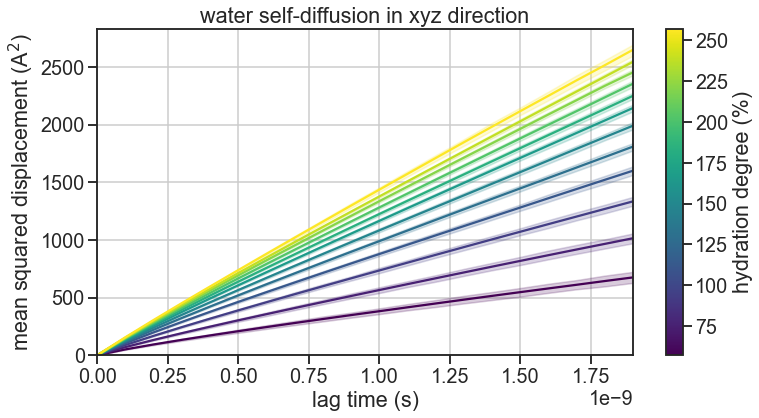

In [282]:
fig, ax = plt.subplots(figsize=(12,6))
sns.set_style("ticks")
sns.set_context("talk", font_scale=1.2)

ddir="xyz"

data=msd_tdf[(msd_tdf["z"]>0) & (msd_tdf["z"]<670) 
             & (msd_tdf["direction"]==ddir)
             & (msd_tdf["state"]=="simNPT")
             #& (msd_tdf["nwater"]==12550)
            ]

g = sns.lineplot(x="time", y='MSD', data=data, 
                 hue="nwater", 
                 #style="hydration_degree", 
                 #ci="sd", err_style="band",
                 #markers=True, 
                 palette="viridis",
                 legend="full")

g.set_xlabel("lag time (s)")
g.set_ylabel("mean squared displacement (A$^2$)")
g.set_title("water self-diffusion in {} direction".format(ddir))
g.set_xlim(xmin=0.,xmax=1.9e-9)
g.set_ylim(ymin=0)

# add colorbar
norm = plt.Normalize(57, 257)
sm = plt.cm.ScalarMappable(cmap="viridis", norm=norm)
sm.set_array([])
# Remove the legend and add a colorbar
ax.get_legend().remove()
ax.figure.colorbar(sm, label='hydration degree (%)')

#plt.legend(title='water count', 
           #bbox_to_anchor=(1.05, 0.95)
#          )

plt.grid()
#plt.savefig(savedir+'water_self-diffusivity_ac_plot_nwat.png')
#plt.savefig('/Users/vassaux/Desktop/poster_JJC-ARC/water_self-diffusivity_ac_plot_nwat.svg')
plt.show()

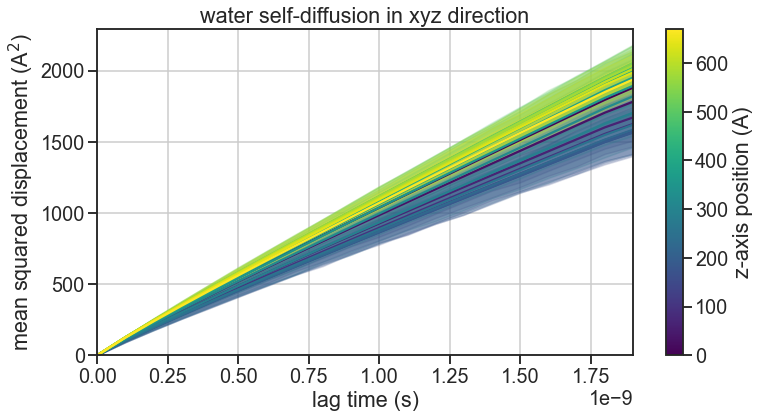

In [283]:
fig, ax = plt.subplots(figsize=(12,6))
sns.set_style("ticks")
sns.set_context("talk", font_scale=1.2)

ddir="xyz"

data=msd_tdf[(msd_tdf["z"]>0) & (msd_tdf["z"]<670) 
             & (msd_tdf["direction"]==ddir)
             & (msd_tdf["state"]=="simNPT")
             #& (msd_tdf["nwater"]==12550)
            ]

g = sns.lineplot(x="time", y='MSD', data=data, 
                 hue="z", 
                 #style="hydration_degree", 
                 #ci="sd", err_style="band",
                 #markers=True, 
                 palette="viridis",
                 legend="full")

g.set_xlabel("lag time (s)")
g.set_ylabel("mean squared displacement (A$^2$)")
g.set_title("water self-diffusion in {} direction".format(ddir))
g.set_xlim(xmin=0.,xmax=1.9e-9)
g.set_ylim(ymin=0)

# add colorbar
norm = plt.Normalize(0, 670)
sm = plt.cm.ScalarMappable(cmap="viridis", norm=norm)
sm.set_array([])
# Remove the legend and add a colorbar
ax.get_legend().remove()
ax.figure.colorbar(sm, label='z-axis position (A)')

#plt.legend(title='water count', 
           #bbox_to_anchor=(1.05, 0.95)
#          )

plt.grid()
#plt.savefig(savedir+'water_self-diffusivity_ac_plot_nwat.png')
#plt.savefig('/Users/vassaux/Desktop/poster_JJC-ARC/water_self-diffusivity_ac_plot_nwat.svg')
plt.show()

In [241]:
for ddir in msd_tdf['direction'].unique():
    for nwat in msd_tdf['nwater'].unique():
        for rep in msd_tdf['replica'].unique():
            for z in msd_tdf['z'].unique():
                df = msd_tdf[(np.floor(msd_tdf["z"])==np.floor(z)) & (msd_tdf["nwater"]==nwat) & 
                             (msd_tdf["direction"]==ddir) & (msd_tdf["replica"]==rep)]
                try:
                    linear_model = linregress(np.log(df.time[1:]), np.log(df.MSD[1:]))
                    tmp = df.iloc[:1][['z','replica','hydration_degree','nwater','direction']]
                    tmp['exp'] = linear_model.slope
                    tmp['error'] = linear_model.stderr
                    exp_df = exp_df.append(tmp, ignore_index=True)
                except ValueError:
                    print("Inputs must not be empty for {} {} {} {}".format(ddir, nwat, rep, z))

Inputs must not be empty for x 56550 2 -84.48275862068965
Inputs must not be empty for x 56550 2 -53.44827586206896
Inputs must not be empty for x 56550 2 -22.41379310344828
Inputs must not be empty for x 56550 2 8.620689655172413
Inputs must not be empty for x 56550 2 39.65517241379311
Inputs must not be empty for x 56550 2 70.6896551724138
Inputs must not be empty for x 56550 2 101.72413793103448
Inputs must not be empty for x 56550 2 132.75862068965515
Inputs must not be empty for x 56550 2 163.79310344827587
Inputs must not be empty for x 56550 2 194.82758620689657
Inputs must not be empty for x 56550 2 225.86206896551727
Inputs must not be empty for x 56550 2 256.8965517241379
Inputs must not be empty for x 56550 2 287.9310344827586
Inputs must not be empty for x 56550 2 318.9655172413793
Inputs must not be empty for x 56550 2 350.0
Inputs must not be empty for x 56550 2 381.0344827586207
Inputs must not be empty for x 56550 2 412.0689655172414
Inputs must not be empty for x 56550

Inputs must not be empty for y 56550 2 -84.48275862068965
Inputs must not be empty for y 56550 2 -53.44827586206896
Inputs must not be empty for y 56550 2 -22.41379310344828
Inputs must not be empty for y 56550 2 8.620689655172413
Inputs must not be empty for y 56550 2 39.65517241379311
Inputs must not be empty for y 56550 2 70.6896551724138
Inputs must not be empty for y 56550 2 101.72413793103448
Inputs must not be empty for y 56550 2 132.75862068965515
Inputs must not be empty for y 56550 2 163.79310344827587
Inputs must not be empty for y 56550 2 194.82758620689657
Inputs must not be empty for y 56550 2 225.86206896551727
Inputs must not be empty for y 56550 2 256.8965517241379
Inputs must not be empty for y 56550 2 287.9310344827586
Inputs must not be empty for y 56550 2 318.9655172413793
Inputs must not be empty for y 56550 2 350.0
Inputs must not be empty for y 56550 2 381.0344827586207
Inputs must not be empty for y 56550 2 412.0689655172414
Inputs must not be empty for y 56550

Inputs must not be empty for z 56550 2 -84.48275862068965
Inputs must not be empty for z 56550 2 -53.44827586206896
Inputs must not be empty for z 56550 2 -22.41379310344828
Inputs must not be empty for z 56550 2 8.620689655172413
Inputs must not be empty for z 56550 2 39.65517241379311
Inputs must not be empty for z 56550 2 70.6896551724138
Inputs must not be empty for z 56550 2 101.72413793103448
Inputs must not be empty for z 56550 2 132.75862068965515
Inputs must not be empty for z 56550 2 163.79310344827587
Inputs must not be empty for z 56550 2 194.82758620689657
Inputs must not be empty for z 56550 2 225.86206896551727
Inputs must not be empty for z 56550 2 256.8965517241379
Inputs must not be empty for z 56550 2 287.9310344827586
Inputs must not be empty for z 56550 2 318.9655172413793
Inputs must not be empty for z 56550 2 350.0
Inputs must not be empty for z 56550 2 381.0344827586207
Inputs must not be empty for z 56550 2 412.0689655172414
Inputs must not be empty for z 56550

Inputs must not be empty for xyz 56550 2 -84.48275862068965
Inputs must not be empty for xyz 56550 2 -53.44827586206896
Inputs must not be empty for xyz 56550 2 -22.41379310344828
Inputs must not be empty for xyz 56550 2 8.620689655172413
Inputs must not be empty for xyz 56550 2 39.65517241379311
Inputs must not be empty for xyz 56550 2 70.6896551724138
Inputs must not be empty for xyz 56550 2 101.72413793103448
Inputs must not be empty for xyz 56550 2 132.75862068965515
Inputs must not be empty for xyz 56550 2 163.79310344827587
Inputs must not be empty for xyz 56550 2 194.82758620689657
Inputs must not be empty for xyz 56550 2 225.86206896551727
Inputs must not be empty for xyz 56550 2 256.8965517241379
Inputs must not be empty for xyz 56550 2 287.9310344827586
Inputs must not be empty for xyz 56550 2 318.9655172413793
Inputs must not be empty for xyz 56550 2 350.0
Inputs must not be empty for xyz 56550 2 381.0344827586207
Inputs must not be empty for xyz 56550 2 412.0689655172414
In

Inputs must not be empty for xyz 56550 6 691.3793103448276
Inputs must not be empty for xyz 56550 6 722.4137931034483
Inputs must not be empty for xyz 56550 6 753.448275862069
Inputs must not be empty for xyz 56550 6 784.4827586206897


/Users/vassaux/source/miniconda3/envs/biomolecular-mdadev/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


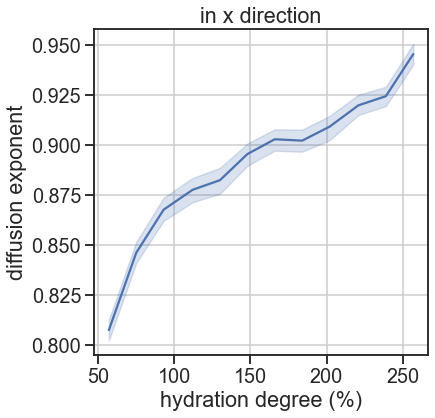

In [251]:
fig, ax = plt.subplots(figsize=(6,6))
sns.set_style("ticks")
sns.set_context("talk", font_scale=1.2)

ddir="x"

data=exp_df[(exp_df["z"]>0) & (exp_df["z"]<670) 
             & (exp_df["direction"]==ddir)
            ]

g = sns.lineplot("hydration_degree", 'exp', data=data, 
                 #hue="z", 
                 #style="hydration_degree", 
                 #ci="sd", err_style="band",
                 #markers=True, 
                 palette="viridis",
                 legend="full")

g.set_xlabel("hydration degree (%)")
g.set_ylabel("diffusion exponent")
g.set_title("in {} direction".format(ddir))
#g.set_xlim(xmin=0, xmax=670)

plt.grid()
#plt.savefig(savedir+'water_self-diffusivity_ac_plot_nwat.png')
#plt.savefig('/Users/vassaux/Desktop/poster_JJC-ARC/water_self-diffusivity_ac_plot_nwat.svg')
plt.show()

/Users/vassaux/source/miniconda3/envs/biomolecular-mdadev/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


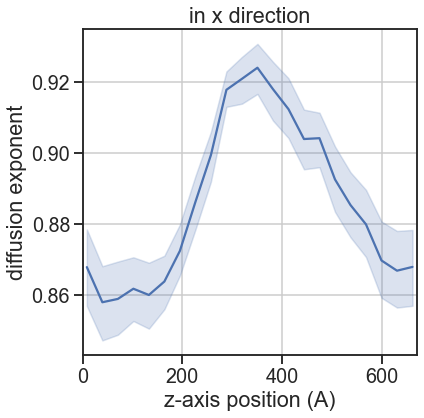

In [250]:
fig, ax = plt.subplots(figsize=(6,6))
sns.set_style("ticks")
sns.set_context("talk", font_scale=1.2)

ddir="x"

data=exp_df[(exp_df["z"]>0) & (exp_df["z"]<670) 
             & (exp_df["direction"]==ddir)
            ]

g = sns.lineplot("z", 'exp', data=data, 
                 #hue="z", 
                 #style="hydration_degree", 
                 #ci="sd", err_style="band",
                 #markers=True, 
                 palette="viridis",
                 legend="full")

g.set_xlabel("z-axis position (A)")
g.set_ylabel("diffusion exponent")
g.set_title("in {} direction".format(ddir))
g.set_xlim(xmin=0, xmax=670)


plt.grid()
#plt.savefig(savedir+'water_self-diffusivity_ac_plot_nwat.png')
#plt.savefig('/Users/vassaux/Desktop/poster_JJC-ARC/water_self-diffusivity_ac_plot_nwat.svg')
plt.show()

## Water self-diffusion coefficient

In [267]:
def compute_selfdiff_cell_water_stime(universe, zone=[0,0,0,0,0,0], diff_dir="xyz", stime=0, sstep=1, dt=0.5e-9):
    selection = "resname WAT and name O \
          and prop x >= {} and prop x<{} \
          and prop y >= {} and prop y<{} \
          and prop z >= {} and prop z<{}".format(zone[0], zone[1], zone[2], zone[3], zone[4], zone[5])
    #print(selection)
    MSD_analysis = msd.EinsteinMSD(universe, selection, msd_type=diff_dir, fft=False)
    MSD_analysis.run(start=stime, step=sstep)
    MSD_res = MSD_analysis.results
    lagtimes = np.arange(0,len(MSD_res.timeseries))*dt
    linear_model = linregress(lagtimes[3:], MSD_res.timeseries[3:]) # We remove the three first frames to avoid fitting the ballistic regime
    slope = linear_model.slope
    error = linear_model.stderr
    dim_factor = len(d)
    D = slope* 1e-20 * 1/(2*dim_factor)
    D_err = error* 1e-20 * 1/(2*dim_factor)
    print(D, D_err)
    return D, D_err

In [243]:
def transf1():
    """
    Translate all coordinates by Zmin angstroms up along the Z dimension.
    """
    def translate(ts):
        zmin = ts.positions[:,2].min()
        ts.positions[:,2] = np.rint(ts.positions[:,2] - zmin)
        return ts
    return translate

In [244]:
def load_universe_replica_water(nwater=14000, replica=1, state="simNPT"):
    # trajectory info: T=50e-9s, nts=25000000, dts=2e-15s, nfr=100, dfr=dts*nts/nfr=0.5e-9s
    #main_dir = "/Users/vassaux/kathleen_home/tmp/model_collagen/npt_relaxation/production_60ns/NPT50NS1ATM298K12550WAT/"
    #main_dir = "/Users/vassaux/sng_wrk72/tmp/NPT50NS1ATM298K12550WAT/"
    main_dir = "/Users/vassaux/tmp/model_collagen/NPT50NS1ATM298K12550WAT/"   
    data_dir = main_dir+"{}WAT/rep{}/".format(nwater,replica)
    sim_name = "3hr2_clean_amber_mutations_modifications_missing_charged_minim_pbc_solvated_equilibrated_hydrated".format(nwater)
    if state=="simNPT":
        u = mda.Universe(data_dir+sim_name+".pdb", data_dir+"/simNPT_unwrapped.dcd")
        dt=2e-15*50000
        start = 80
    elif state=="relax_constraint":
        u = mda.Universe(data_dir+sim_name+".pdb", data_dir+"/relax_constraint_extended/relax_constraint_unwrapped.dcd")
        dt=2e-15*10000
        start = 1
    print(u.trajectory)
    print(type(u))
    return u, dt, start

In [264]:
msd_tdf = pd.DataFrame()
column_names=["xmin","xmax","ymin","ymax","zmin","zmax", "self-diffusivity", "regerr"]

# mapping
x = np.linspace(-10000, 10000, num=2) # np.linspace(-80, 60, num=12)
y = np.linspace(-10000, 10000, num=2) # np.linspace(-20, 40, num=10)
z = np.linspace(-100, 800, num=60) # np.linspace(-100, 800, num=30)

# list water molecule counts
list_water=np.arange(12550, 13000, 3000) #57000
# list_water=["12550"] #["D13500","I14000","I15000","I16000","I17000"]

# ensemble of replicas
list_rep=[1,2,3,4,5,6] # [1,2,3,4,5,6]

# state
list_state=["simNPT"] # "relax_constraint" "simNPT"

# MSD directions
list_dir= ['xyz','x','y','z'] # ['x','y','z','xyz']

for nwat in list_water:
    # loop over ranges and compute msd in square zones
    for rep in list_rep:
        sstep=1
        for state in list_state:
            # load water molecules
            univ, sdt, sstime = load_universe_replica_water(nwat,rep,state)
            # wrap/unwrap atoms coordinates
            #wrap = mdt.wrap(univ.atoms)
            ##unwrap = mdt.unwrap(univ.atoms)
            #workflow = [wrap,
            #            #unwrap
            #            transf1()
            #           ]
            # apply transform
            #univ.trajectory.add_transformations(*workflow)
            for d in list_dir:
                for j in range(len(z)-1):
                    zone = [x[0],x[-1],y[0],y[-1],z[j],z[j+1]]
                    print(zone)
                    D, D_err = compute_selfdiff_cell_water_stime(univ, zone, diff_dir=d,stime=sstime,sstep=sstep,dt=sdt)
                    msd_df = pd.DataFrame(np.concatenate((zone,[D, D_err])).reshape(1,-1), columns=column_names)
                    msd_df['direction'] = d
                    msd_df['replica'] = rep
                    msd_df['nwater'] = nwat
                    msd_df['state'] = state
                    msd_df['hydration_degree'] = np.rint(np.round(nwat/22000,2)*100)
                    msd_df["x"] = (msd_df["xmin"]+msd_df["xmax"])/2
                    msd_df["y"] = (msd_df["ymin"]+msd_df["ymax"])/2
                    msd_df["z"] = (msd_df["zmin"]+msd_df["zmax"])/2
                    msd_df['upper_regerr'] = 0.5*msd_df['regerr'] + msd_df['self-diffusivity']
                    msd_df['lower_regerr'] = -0.5*msd_df['regerr'] + msd_df['self-diffusivity']
                    msd_df["z_nm"] = msd_df["z"]/10
                    msd_tdf = msd_tdf.append(msd_df, ignore_index=True)

/Users/vassaux/source/miniconda3/envs/biomolecular-mdadev/lib/python3.8/site-packages/MDAnalysis/topology/PDBParser.py:317: UserWarning: Element information is missing, elements attribute will not be populated. If needed these can be guessed using MDAnalysis.topology.guessers.
  warnings.warn("Element information is missing, elements attribute "
/Users/vassaux/source/miniconda3/envs/biomolecular-mdadev/lib/python3.8/site-packages/MDAnalysis/analysis/msd.py:379: RuntimeWarning: Mean of empty slice.
  self.results.timeseries = self.results.msds_by_particle.mean(axis=1)
/Users/vassaux/source/miniconda3/envs/biomolecular-mdadev/lib/python3.8/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


<DCDReader /Users/vassaux/tmp/model_collagen/NPT50NS1ATM298K12550WAT/12550WAT/rep1//simNPT_unwrapped.dcd with 100 frames of 76744 atoms>
<class 'MDAnalysis.core.universe.Universe'>
[-10000.0, 10000.0, -10000.0, 10000.0, -100.0, -84.7457627118644]
nan nan
[-10000.0, 10000.0, -10000.0, 10000.0, -84.7457627118644, -69.49152542372882]
nan nan
[-10000.0, 10000.0, -10000.0, 10000.0, -69.49152542372882, -54.23728813559322]
nan nan
[-10000.0, 10000.0, -10000.0, 10000.0, -54.23728813559322, -38.983050847457626]
nan nan
[-10000.0, 10000.0, -10000.0, 10000.0, -38.983050847457626, -23.728813559322035]
nan nan
[-10000.0, 10000.0, -10000.0, 10000.0, -23.728813559322035, -8.474576271186436]
5.224969333651176e-10 2.824243625950242e-11
[-10000.0, 10000.0, -10000.0, 10000.0, -8.474576271186436, 6.779661016949149]
8.432070991357446e-10 8.411725471148912e-12
[-10000.0, 10000.0, -10000.0, 10000.0, 6.779661016949149, 22.033898305084747]
6.965976674038453e-10 4.012072042037476e-12
[-10000.0, 10000.0, -10000.

2.2940976358998374e-10 4.185226589778361e-12
[-10000.0, 10000.0, -10000.0, 10000.0, 174.5762711864407, 189.83050847457628]
2.453474826016607e-10 4.849811226225576e-12
[-10000.0, 10000.0, -10000.0, 10000.0, 189.83050847457628, 205.08474576271186]
2.201955588620998e-10 4.136101909920626e-12
[-10000.0, 10000.0, -10000.0, 10000.0, 205.08474576271186, 220.33898305084745]
1.937707324583116e-10 4.859682998863644e-12
[-10000.0, 10000.0, -10000.0, 10000.0, 220.33898305084745, 235.59322033898303]
2.7863203951634397e-10 2.026303172862884e-12
[-10000.0, 10000.0, -10000.0, 10000.0, 235.59322033898303, 250.84745762711867]
2.380519997016453e-10 5.374636741471543e-12
[-10000.0, 10000.0, -10000.0, 10000.0, 250.84745762711867, 266.10169491525426]
2.301248439232291e-10 3.2145303338741348e-12
[-10000.0, 10000.0, -10000.0, 10000.0, 266.10169491525426, 281.35593220338984]
2.799671035324918e-10 6.206476685588589e-12
[-10000.0, 10000.0, -10000.0, 10000.0, 281.35593220338984, 296.6101694915254]
3.0822625524042

4.859951963858398e-10 1.1875787098677391e-11
[-10000.0, 10000.0, -10000.0, 10000.0, 449.1525423728814, 464.4067796610169]
5.262895689290336e-10 1.5069086358682537e-11
[-10000.0, 10000.0, -10000.0, 10000.0, 464.4067796610169, 479.66101694915255]
4.98442196844196e-10 1.826342015795416e-11
[-10000.0, 10000.0, -10000.0, 10000.0, 479.66101694915255, 494.9152542372882]
4.606012429832338e-10 1.1127680690869926e-11
[-10000.0, 10000.0, -10000.0, 10000.0, 494.9152542372882, 510.1694915254237]
4.193357146633671e-10 6.507543652188676e-12
[-10000.0, 10000.0, -10000.0, 10000.0, 510.1694915254237, 525.4237288135594]
3.6550193089532256e-10 3.509410524568809e-12
[-10000.0, 10000.0, -10000.0, 10000.0, 525.4237288135594, 540.6779661016949]
4.259044543236627e-10 7.047200542339867e-12
[-10000.0, 10000.0, -10000.0, 10000.0, 540.6779661016949, 555.9322033898305]
3.396927352341577e-10 4.856147738924649e-12
[-10000.0, 10000.0, -10000.0, 10000.0, 555.9322033898305, 571.1864406779661]
3.631924489767987e-10 9.312

5.656382744177615e-11 3.662904973279145e-11
[-10000.0, 10000.0, -10000.0, 10000.0, 708.4745762711865, 723.728813559322]
nan nan
[-10000.0, 10000.0, -10000.0, 10000.0, 723.728813559322, 738.9830508474577]
nan nan
[-10000.0, 10000.0, -10000.0, 10000.0, 738.9830508474577, 754.2372881355932]
nan nan
[-10000.0, 10000.0, -10000.0, 10000.0, 754.2372881355932, 769.4915254237288]
nan nan
[-10000.0, 10000.0, -10000.0, 10000.0, 769.4915254237288, 784.7457627118645]
nan nan
[-10000.0, 10000.0, -10000.0, 10000.0, 784.7457627118645, 800.0]
nan nan
<DCDReader /Users/vassaux/tmp/model_collagen/NPT50NS1ATM298K12550WAT/12550WAT/rep2//simNPT_unwrapped.dcd with 100 frames of 76744 atoms>
<class 'MDAnalysis.core.universe.Universe'>
[-10000.0, 10000.0, -10000.0, 10000.0, -100.0, -84.7457627118644]
nan nan
[-10000.0, 10000.0, -10000.0, 10000.0, -84.7457627118644, -69.49152542372882]
nan nan
[-10000.0, 10000.0, -10000.0, 10000.0, -69.49152542372882, -54.23728813559322]
nan nan
[-10000.0, 10000.0, -10000.0, 10

1.8167269625212435e-10 7.292652015819189e-12
[-10000.0, 10000.0, -10000.0, 10000.0, 67.79661016949152, 83.05084745762713]
2.3823582708060337e-10 1.5634505208490708e-12
[-10000.0, 10000.0, -10000.0, 10000.0, 83.05084745762713, 98.30508474576271]
2.755657138544463e-10 2.7831467566485006e-12
[-10000.0, 10000.0, -10000.0, 10000.0, 98.30508474576271, 113.5593220338983]
2.2915324741053232e-10 6.147178449984137e-12
[-10000.0, 10000.0, -10000.0, 10000.0, 113.5593220338983, 128.8135593220339]
2.571672860345553e-10 5.182357658166299e-12
[-10000.0, 10000.0, -10000.0, 10000.0, 128.8135593220339, 144.0677966101695]
2.0602830489384497e-10 8.211853210682206e-12
[-10000.0, 10000.0, -10000.0, 10000.0, 144.0677966101695, 159.3220338983051]
2.1052235811586287e-10 5.685045602422409e-12
[-10000.0, 10000.0, -10000.0, 10000.0, 159.3220338983051, 174.5762711864407]
2.2136335779193377e-10 6.659103159770565e-12
[-10000.0, 10000.0, -10000.0, 10000.0, 174.5762711864407, 189.83050847457628]
2.4482016642522635e-10 

2.7946798277641675e-10 6.961634758684997e-12
[-10000.0, 10000.0, -10000.0, 10000.0, 342.37288135593224, 357.6271186440678]
4.1343424482709317e-10 3.7258384184791564e-12
[-10000.0, 10000.0, -10000.0, 10000.0, 357.6271186440678, 372.8813559322034]
2.7985088351527913e-10 9.53357510129416e-12
[-10000.0, 10000.0, -10000.0, 10000.0, 372.8813559322034, 388.135593220339]
3.388052452813315e-10 5.367252188940753e-12
[-10000.0, 10000.0, -10000.0, 10000.0, 388.135593220339, 403.3898305084746]
4.078412236778121e-10 9.558893885855486e-12
[-10000.0, 10000.0, -10000.0, 10000.0, 403.3898305084746, 418.6440677966102]
4.5500820843357955e-10 4.9448537551068605e-12
[-10000.0, 10000.0, -10000.0, 10000.0, 418.6440677966102, 433.89830508474574]
5.775115417423209e-10 5.7978450709472774e-12
[-10000.0, 10000.0, -10000.0, 10000.0, 433.89830508474574, 449.1525423728814]
5.097657806708646e-10 6.605172859398389e-12
[-10000.0, 10000.0, -10000.0, 10000.0, 449.1525423728814, 464.4067796610169]
4.850830543159339e-10 3.5

1.2966696979995486e-09 1.3898544202403465e-11
[-10000.0, 10000.0, -10000.0, 10000.0, 616.9491525423729, 632.2033898305085]
1.1634416906821878e-09 2.0509981640323056e-11
[-10000.0, 10000.0, -10000.0, 10000.0, 632.2033898305085, 647.457627118644]
8.593929630825737e-10 3.263738433555138e-11
[-10000.0, 10000.0, -10000.0, 10000.0, 647.457627118644, 662.7118644067797]
8.583472932209734e-10 1.8490710517334224e-11
[-10000.0, 10000.0, -10000.0, 10000.0, 662.7118644067797, 677.9661016949152]
1.151068293203275e-09 2.1650263508566558e-11
[-10000.0, 10000.0, -10000.0, 10000.0, 677.9661016949152, 693.2203389830509]
1.1511582860070284e-09 1.0998763542657744e-11
[-10000.0, 10000.0, -10000.0, 10000.0, 693.2203389830509, 708.4745762711865]
6.424567423649044e-10 9.990915977762887e-11
[-10000.0, 10000.0, -10000.0, 10000.0, 708.4745762711865, 723.728813559322]
nan nan
[-10000.0, 10000.0, -10000.0, 10000.0, 723.728813559322, 738.9830508474577]
nan nan
[-10000.0, 10000.0, -10000.0, 10000.0, 738.9830508474577

nan nan
[-10000.0, 10000.0, -10000.0, 10000.0, -84.7457627118644, -69.49152542372882]
nan nan
[-10000.0, 10000.0, -10000.0, 10000.0, -69.49152542372882, -54.23728813559322]
nan nan
[-10000.0, 10000.0, -10000.0, 10000.0, -54.23728813559322, -38.983050847457626]
nan nan
[-10000.0, 10000.0, -10000.0, 10000.0, -38.983050847457626, -23.728813559322035]
1.950121084498222e-10 7.014453666062685e-11
[-10000.0, 10000.0, -10000.0, 10000.0, -23.728813559322035, -8.474576271186436]
1.346020081205734e-09 5.91561503965913e-11
[-10000.0, 10000.0, -10000.0, 10000.0, -8.474576271186436, 6.779661016949149]
4.585184785865559e-10 1.053354054967776e-11
[-10000.0, 10000.0, -10000.0, 10000.0, 6.779661016949149, 22.033898305084747]
5.001283960736227e-10 6.0821607575748306e-12
[-10000.0, 10000.0, -10000.0, 10000.0, 22.033898305084747, 37.288135593220346]
4.2738051910488715e-10 1.230819685939161e-11
[-10000.0, 10000.0, -10000.0, 10000.0, 37.288135593220346, 52.54237288135593]
3.3419177257314717e-10 7.28001335143

1.6199949103553907e-10 7.953551311561666e-12
[-10000.0, 10000.0, -10000.0, 10000.0, 189.83050847457628, 205.08474576271186]
1.9601526796450224e-10 5.3935711407643e-12
[-10000.0, 10000.0, -10000.0, 10000.0, 205.08474576271186, 220.33898305084745]
2.4543516846019e-10 3.3504977650000894e-12
[-10000.0, 10000.0, -10000.0, 10000.0, 220.33898305084745, 235.59322033898303]
1.9510048678989755e-10 1.513620326945574e-12
[-10000.0, 10000.0, -10000.0, 10000.0, 235.59322033898303, 250.84745762711867]
2.2096733635121238e-10 2.529907096728257e-12
[-10000.0, 10000.0, -10000.0, 10000.0, 250.84745762711867, 266.10169491525426]
2.0163585446121302e-10 1.972741510594329e-12
[-10000.0, 10000.0, -10000.0, 10000.0, 266.10169491525426, 281.35593220338984]
1.1773442857008746e-10 3.1715822408256924e-12
[-10000.0, 10000.0, -10000.0, 10000.0, 281.35593220338984, 296.6101694915254]
2.3068638082756617e-10 9.95161906779706e-12
[-10000.0, 10000.0, -10000.0, 10000.0, 296.6101694915254, 311.864406779661]
3.05454358283513

1.1744508496934608e-09 1.899780728664096e-11
[-10000.0, 10000.0, -10000.0, 10000.0, 464.4067796610169, 479.66101694915255]
1.162746427980126e-09 3.7965299468298474e-11
[-10000.0, 10000.0, -10000.0, 10000.0, 479.66101694915255, 494.9152542372882]
8.99281828695847e-10 8.403660197707307e-12
[-10000.0, 10000.0, -10000.0, 10000.0, 494.9152542372882, 510.1694915254237]
1.2688717212518483e-09 2.3956770057118386e-11
[-10000.0, 10000.0, -10000.0, 10000.0, 510.1694915254237, 525.4237288135594]
1.1175028187875663e-09 1.1526279979719038e-11
[-10000.0, 10000.0, -10000.0, 10000.0, 525.4237288135594, 540.6779661016949]
1.4508325641219407e-09 7.475056587177956e-12
[-10000.0, 10000.0, -10000.0, 10000.0, 540.6779661016949, 555.9322033898305]
1.3620999802220283e-09 1.197985651944318e-11
[-10000.0, 10000.0, -10000.0, 10000.0, 555.9322033898305, 571.1864406779661]
1.4837733436933394e-09 3.0345921441844956e-11
[-10000.0, 10000.0, -10000.0, 10000.0, 571.1864406779661, 586.4406779661017]
1.1280493511771296e-0

7.336157127627248e-10 8.9022011225308e-12
[-10000.0, 10000.0, -10000.0, 10000.0, 647.457627118644, 662.7118644067797]
6.875468647746585e-10 4.310933861919233e-12
[-10000.0, 10000.0, -10000.0, 10000.0, 662.7118644067797, 677.9661016949152]
6.834394205536835e-10 1.2798335694779784e-11
[-10000.0, 10000.0, -10000.0, 10000.0, 677.9661016949152, 693.2203389830509]
5.557446709439482e-10 1.8728086202406876e-11
[-10000.0, 10000.0, -10000.0, 10000.0, 693.2203389830509, 708.4745762711865]
6.105775998447499e-10 5.791698981061371e-11
[-10000.0, 10000.0, -10000.0, 10000.0, 708.4745762711865, 723.728813559322]
nan nan
[-10000.0, 10000.0, -10000.0, 10000.0, 723.728813559322, 738.9830508474577]
nan nan
[-10000.0, 10000.0, -10000.0, 10000.0, 738.9830508474577, 754.2372881355932]
nan nan
[-10000.0, 10000.0, -10000.0, 10000.0, 754.2372881355932, 769.4915254237288]
nan nan
[-10000.0, 10000.0, -10000.0, 10000.0, 769.4915254237288, 784.7457627118645]
nan nan
[-10000.0, 10000.0, -10000.0, 10000.0, 784.7457627

3.454145788081231e-10 8.506169412734601e-12
[-10000.0, 10000.0, -10000.0, 10000.0, 22.033898305084747, 37.288135593220346]
2.897567037909749e-10 1.4763142255244634e-11
[-10000.0, 10000.0, -10000.0, 10000.0, 37.288135593220346, 52.54237288135593]
3.0190640821683065e-10 4.563391884869172e-12
[-10000.0, 10000.0, -10000.0, 10000.0, 52.54237288135593, 67.79661016949152]
2.2458435706817306e-10 8.567337643190761e-12
[-10000.0, 10000.0, -10000.0, 10000.0, 67.79661016949152, 83.05084745762713]
2.57654985160252e-10 4.020578717729948e-12
[-10000.0, 10000.0, -10000.0, 10000.0, 83.05084745762713, 98.30508474576271]
2.193222337062566e-10 4.305218514700891e-12
[-10000.0, 10000.0, -10000.0, 10000.0, 98.30508474576271, 113.5593220338983]
2.655420764334243e-10 6.419564499827746e-12
[-10000.0, 10000.0, -10000.0, 10000.0, 113.5593220338983, 128.8135593220339]
2.1321488845537837e-10 3.512339149671546e-12
[-10000.0, 10000.0, -10000.0, 10000.0, 128.8135593220339, 144.0677966101695]
2.1157688488541704e-10 3.2

6.760121643991822e-10 3.8520264165492176e-12
[-10000.0, 10000.0, -10000.0, 10000.0, 296.6101694915254, 311.864406779661]
5.994024607311089e-10 1.8430407768058606e-11
[-10000.0, 10000.0, -10000.0, 10000.0, 311.864406779661, 327.1186440677966]
9.414057660198136e-10 2.369646165003726e-11
[-10000.0, 10000.0, -10000.0, 10000.0, 327.1186440677966, 342.37288135593224]
9.058142866522427e-10 1.317039373246998e-11
[-10000.0, 10000.0, -10000.0, 10000.0, 342.37288135593224, 357.6271186440678]
1.084004370183821e-09 6.920033870991846e-12
[-10000.0, 10000.0, -10000.0, 10000.0, 357.6271186440678, 372.8813559322034]
1.0171073093739246e-09 1.562712357063962e-11
[-10000.0, 10000.0, -10000.0, 10000.0, 372.8813559322034, 388.135593220339]
1.095359650177994e-09 2.0721800569461697e-11
[-10000.0, 10000.0, -10000.0, 10000.0, 388.135593220339, 403.3898305084746]
1.0328961428440504e-09 9.03870427336278e-12
[-10000.0, 10000.0, -10000.0, 10000.0, 403.3898305084746, 418.6440677966102]
1.2605882024588454e-09 2.39780

7.799232090898292e-10 5.950523975529569e-12
[-10000.0, 10000.0, -10000.0, 10000.0, 540.6779661016949, 555.9322033898305]
8.492054046138857e-10 6.148078584250596e-12
[-10000.0, 10000.0, -10000.0, 10000.0, 555.9322033898305, 571.1864406779661]
7.912548832083978e-10 9.328181792956467e-12
[-10000.0, 10000.0, -10000.0, 10000.0, 571.1864406779661, 586.4406779661017]
8.017572857395348e-10 7.715033264725624e-12
[-10000.0, 10000.0, -10000.0, 10000.0, 586.4406779661017, 601.6949152542373]
6.495117231203421e-10 8.516836120728407e-12
[-10000.0, 10000.0, -10000.0, 10000.0, 601.6949152542373, 616.9491525423729]
7.923146606791845e-10 5.534228736304085e-12
[-10000.0, 10000.0, -10000.0, 10000.0, 616.9491525423729, 632.2033898305085]
6.220326417579201e-10 8.087387616207332e-12
[-10000.0, 10000.0, -10000.0, 10000.0, 632.2033898305085, 647.457627118644]
7.294866834019398e-10 3.5812770432612986e-12
[-10000.0, 10000.0, -10000.0, 10000.0, 647.457627118644, 662.7118644067797]
7.142546383755866e-10 8.632816516

nan nan
[-10000.0, 10000.0, -10000.0, 10000.0, -84.7457627118644, -69.49152542372882]
nan nan
[-10000.0, 10000.0, -10000.0, 10000.0, -69.49152542372882, -54.23728813559322]
nan nan
[-10000.0, 10000.0, -10000.0, 10000.0, -54.23728813559322, -38.983050847457626]
1.1522023867151035e-10 6.945115923114378e-11
[-10000.0, 10000.0, -10000.0, 10000.0, -38.983050847457626, -23.728813559322035]
5.244004648128643e-10 6.991675053213873e-11
[-10000.0, 10000.0, -10000.0, 10000.0, -23.728813559322035, -8.474576271186436]
3.857934894693127e-10 8.52603281692433e-12
[-10000.0, 10000.0, -10000.0, 10000.0, -8.474576271186436, 6.779661016949149]
4.759042181181811e-10 1.1707003926861244e-11
[-10000.0, 10000.0, -10000.0, 10000.0, 6.779661016949149, 22.033898305084747]
3.9934291224667815e-10 1.0426247099068935e-11
[-10000.0, 10000.0, -10000.0, 10000.0, 22.033898305084747, 37.288135593220346]
4.389641794918326e-10 4.176842009402791e-12
[-10000.0, 10000.0, -10000.0, 10000.0, 37.288135593220346, 52.54237288135593

3.201368425302131e-10 7.159348100117048e-12
[-10000.0, 10000.0, -10000.0, 10000.0, 189.83050847457628, 205.08474576271186]
3.9808569933969914e-10 6.115093841961732e-12
[-10000.0, 10000.0, -10000.0, 10000.0, 205.08474576271186, 220.33898305084745]
4.1411478309644074e-10 5.649534636802128e-12
[-10000.0, 10000.0, -10000.0, 10000.0, 220.33898305084745, 235.59322033898303]
3.2583060616405437e-10 7.50262207725395e-12
[-10000.0, 10000.0, -10000.0, 10000.0, 235.59322033898303, 250.84745762711867]
4.782841506789879e-10 6.902758128398951e-12
[-10000.0, 10000.0, -10000.0, 10000.0, 250.84745762711867, 266.10169491525426]
2.803566151827843e-10 7.950828227089821e-12
[-10000.0, 10000.0, -10000.0, 10000.0, 266.10169491525426, 281.35593220338984]
2.9260529309547037e-10 5.382620393495615e-12
[-10000.0, 10000.0, -10000.0, 10000.0, 281.35593220338984, 296.6101694915254]
2.697599133815493e-10 1.3194615009386287e-11
[-10000.0, 10000.0, -10000.0, 10000.0, 296.6101694915254, 311.864406779661]
8.52337555042778

8.292003413028191e-10 3.780992049758378e-12
[-10000.0, 10000.0, -10000.0, 10000.0, 433.89830508474574, 449.1525423728814]
8.452932819181812e-10 6.256610363478009e-12
[-10000.0, 10000.0, -10000.0, 10000.0, 449.1525423728814, 464.4067796610169]
6.902647826912879e-10 7.934123294598545e-12
[-10000.0, 10000.0, -10000.0, 10000.0, 464.4067796610169, 479.66101694915255]
7.494933143999034e-10 4.527345787587922e-12
[-10000.0, 10000.0, -10000.0, 10000.0, 479.66101694915255, 494.9152542372882]
7.628808296742772e-10 1.575529751810166e-11
[-10000.0, 10000.0, -10000.0, 10000.0, 494.9152542372882, 510.1694915254237]
8.096722620815073e-10 7.52968508961942e-12
[-10000.0, 10000.0, -10000.0, 10000.0, 510.1694915254237, 525.4237288135594]
6.486439208138607e-10 2.929668302065913e-12
[-10000.0, 10000.0, -10000.0, 10000.0, 525.4237288135594, 540.6779661016949]
7.38260055426242e-10 7.587860448903867e-12
[-10000.0, 10000.0, -10000.0, 10000.0, 540.6779661016949, 555.9322033898305]
7.639770075446528e-10 1.4068106

2.9930636312300556e-10 3.438092038085046e-11
[-10000.0, 10000.0, -10000.0, 10000.0, 708.4745762711865, 723.728813559322]
nan nan
[-10000.0, 10000.0, -10000.0, 10000.0, 723.728813559322, 738.9830508474577]
nan nan
[-10000.0, 10000.0, -10000.0, 10000.0, 738.9830508474577, 754.2372881355932]
nan nan
[-10000.0, 10000.0, -10000.0, 10000.0, 754.2372881355932, 769.4915254237288]
nan nan
[-10000.0, 10000.0, -10000.0, 10000.0, 769.4915254237288, 784.7457627118645]
nan nan
[-10000.0, 10000.0, -10000.0, 10000.0, 784.7457627118645, 800.0]
nan nan
[-10000.0, 10000.0, -10000.0, 10000.0, -100.0, -84.7457627118644]
nan nan
[-10000.0, 10000.0, -10000.0, 10000.0, -84.7457627118644, -69.49152542372882]
nan nan
[-10000.0, 10000.0, -10000.0, 10000.0, -69.49152542372882, -54.23728813559322]
nan nan
[-10000.0, 10000.0, -10000.0, 10000.0, -54.23728813559322, -38.983050847457626]
nan nan
[-10000.0, 10000.0, -10000.0, 10000.0, -38.983050847457626, -23.728813559322035]
2.951187841083671e-11 2.2156067335867917e-1

3.356364998301931e-10 3.2920305214119486e-12
[-10000.0, 10000.0, -10000.0, 10000.0, 83.05084745762713, 98.30508474576271]
4.5371557531793617e-10 8.558324420252665e-12
[-10000.0, 10000.0, -10000.0, 10000.0, 98.30508474576271, 113.5593220338983]
3.700242609677188e-10 4.981006690866949e-12
[-10000.0, 10000.0, -10000.0, 10000.0, 113.5593220338983, 128.8135593220339]
4.5254927134710696e-10 4.115740617868791e-12
[-10000.0, 10000.0, -10000.0, 10000.0, 128.8135593220339, 144.0677966101695]
3.6700971869201083e-10 9.241886749858937e-12
[-10000.0, 10000.0, -10000.0, 10000.0, 144.0677966101695, 159.3220338983051]
3.130154152540797e-10 4.0555218144720716e-12
[-10000.0, 10000.0, -10000.0, 10000.0, 159.3220338983051, 174.5762711864407]
4.5902254660987514e-10 9.84470587141071e-12
[-10000.0, 10000.0, -10000.0, 10000.0, 174.5762711864407, 189.83050847457628]
3.3659608042541973e-10 2.7493683216399793e-12
[-10000.0, 10000.0, -10000.0, 10000.0, 189.83050847457628, 205.08474576271186]
3.8815694441608196e-10

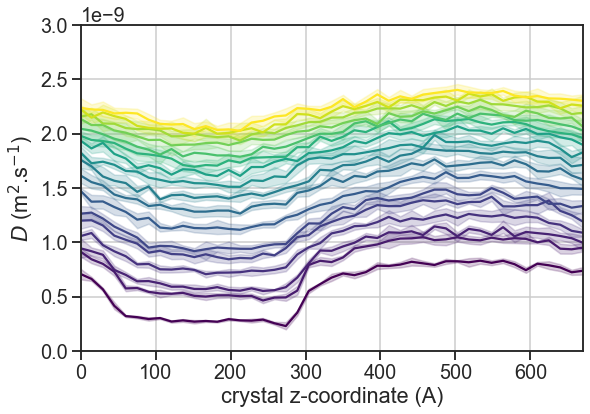

In [45]:
fig, ax = plt.subplots(figsize=(9,6))
sns.set_style("ticks")
sns.set_context("talk", font_scale=1.2)

ddir="xyz"

data=msd_tdf[(msd_tdf["zmin"]>-10) & (msd_tdf["zmax"]<700) & (msd_tdf["direction"]==ddir)
             #& (msd_tdf["nwater"]!=48550) & (msd_tdf["nwater"]!=24550) 
            #& (msd_tdf["replica"]==6)
             & (msd_tdf["state"]=="simNPT")
            ]

g = sns.lineplot(x="z", y='self-diffusivity', data=data, 
                 hue="hydration_degree", 
                 #style="hydration_degree", 
                 #ci="sd", err_style="band",
                 #markers=True, 
                 palette="viridis",
                 legend="full")

g.set_xlabel("crystal z-coordinate (A)")
g.set_ylabel("$D$ (m$^2$.s$^{-1}$)")
#g.set_title("water self-diffusion in {} direction".format(ddir))
g.set_xlim(xmin=0.0, xmax=670)
g.set_ylim(ymin=0.0, ymax=3.e-9)

# add colorbar
norm = plt.Normalize(57, 257)
sm = plt.cm.ScalarMappable(cmap="viridis", norm=norm)
sm.set_array([])
# Remove the legend and add a colorbar
ax.get_legend().remove()
#ax.figure.colorbar(sm, label='hydration degree (%)')

#plt.legend(title='water count', 
           #bbox_to_anchor=(1.05, 0.95)
#          )

plt.grid()
#plt.savefig(savedir+'water_self-diffusivity_ac_plot_nwat.png')
#plt.savefig('/Users/vassaux/Desktop/poster_JJC-ARC/water_self-diffusivity_ac_plot_nwat.svg')
plt.show()

In [115]:
msd_tdf_gap = msd_tdf[(msd_tdf['z']>350) & (msd_tdf['z']<600)].groupby(['replica','nwater','direction'], as_index=False).mean()
msd_tdf_gap['zone'] = "gap"
msd_tdf_overlap = msd_tdf[(msd_tdf['z']>50) & (msd_tdf['z']<250)].groupby(['replica','nwater','direction'], as_index=False).mean()
msd_tdf_overlap['zone'] = "overlap"
msd_tdf_diff = msd_tdf_gap.copy()
msd_tdf_diff['self-diffusivity'] = msd_tdf_gap['self-diffusivity'] - msd_tdf_overlap['self-diffusivity']
msd_tdf_diff['zone'] = 'gap - overlap'
msd_tdf_zone = pd.concat([msd_tdf_gap, msd_tdf_overlap, msd_tdf_diff])

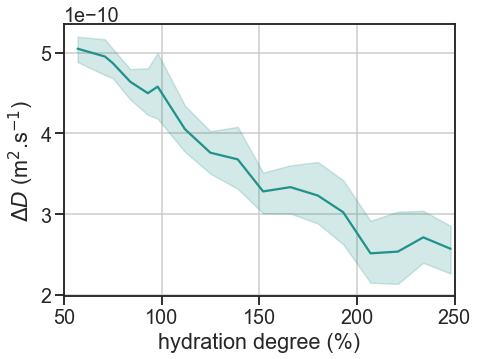

In [120]:
fig, ax = plt.subplots(figsize=(7,5))
sns.set_style("ticks")
sns.set_context("talk", font_scale=1.2)

ddir="xyz"

data=msd_tdf_zone[(msd_tdf_zone["direction"]==ddir)
                  & (msd_tdf_zone["zone"].str.contains("-"))
                 ]

g = sns.lineplot(x="hydration_degree", y='self-diffusivity', data=data, 
                 hue="zone", 
                 #style="hydration_degree", 
                 #ci="sd", err_style="band",
                 #markers=True, 
                 palette="viridis",
                 legend=False)

g.set_xlabel("hydration degree (%)")
g.set_ylabel("$\Delta D$ (m$^2$.s$^{-1}$)")
#g.set_title("water self-diffusion in {} direction".format(ddir))
g.set_xlim(xmin=50.0, xmax=250)
#g.set_ylim(ymin=0.0, ymax=3.e-9)

plt.grid()
#plt.savefig(savedir+'water_self-diffusivity_ac_plot_nwat.png')
#plt.savefig('/Users/vassaux/Desktop/poster_JJC-ARC/water_self-diffusivity_ac_plot_nwat.svg')
plt.show()

## Radial distribution of water molecules around tropocollagens

In [125]:
import MDAnalysis.analysis.rdf as RDF

In [126]:
def compute_interrdf(atomgroup1, atomgroup2, tmin=0, tmax=-1, qmin=0.0, qmax=20.0, nbins=100):
    rdf = RDF.InterRDF(atomgroup1, atomgroup2, 
                       range=[qmin, qmax], 
                       nbins=nbins)
    rdf.run()#start=tmin, stop=tmax)
    return rdf.results.bins, rdf.results.rdf

In [127]:
def load_universe_replica_water_unwrapped(nwater=12550, replica=1,state="simNPT"):
    # trajectory info: T=50e-9s, nts=25000000, dts=2e-15s, nfr=100, dfr=dts*nts/nfr=0.5e-9s
    main_dir = "/Users/vassaux/sng_wrk72/tmp/NPT50NS1ATM298K12550WAT/"
    data_dir = main_dir+"{}WAT/rep{}/".format(nwater,replica)
    sim_name = "3hr2_clean_amber_mutations_modifications_missing_charged_minim_pbc_solvated_equilibrated_hydrated".format(nwater)
    if state=="simNPT":
        u = mda.Universe(data_dir+sim_name+".pdb", data_dir+"/simNPT_unwrapped.dcd")
    elif state=="relax_constraint":
        u = mda.Universe(data_dir+sim_name+".pdb", data_dir+"/relax_constraint_extended/relax_constraint_unwrapped.dcd")
    print(u.trajectory)
    print(type(u))
    return u

### Whole microfibril

In [143]:
# list water molecule counts
list_water=np.arange(32550, 57000, 2000)
#list_water=[12550]

# ensemble of replicas
list_rep=[1,2,3,4,5,6] #[1,2,3,4,5,6]

# state
list_state=["simNPT"] # "relax_constraint" "simNPT"

# atoms to include in RDF
select_ca='name CA'
select_wat='resname WAT and name O'

tdf = pd.DataFrame()
for nwat in list_water:
    for rep in list_rep:
        for state in list_state:
            univ = load_universe_replica_water_unwrapped(nwat,rep,state)
            #
            acarbs=univ.select_atoms(select_ca)
            owats=univ.select_atoms(select_wat)
            #
            df = pd.DataFrame()
            #
            #workflow=[flatten_z]
            #univ.trajectory.add_transformations(*workflow)
            #print(univ.atoms.positions[:,2])
            #
            bins, rdf = compute_interrdf(acarbs, owats, tmin=80, tmax=-1, qmin=0, qmax=15.0, nbins=150)
            df["bins"] = bins
            df["rdf"] = rdf
            df['replica'] = rep
            df['state'] = state
            df['nwater'] = nwat
            df['hydr_degree'] = np.rint(np.round(nwat/22000,2)*100)
            tdf = tdf.append(df, ignore_index=True)

<DCDReader /Users/vassaux/sng_wrk72/tmp/NPT50NS1ATM298K12550WAT/32550WAT/rep1//simNPT_unwrapped.dcd with 100 frames of 136744 atoms>
<class 'MDAnalysis.core.universe.Universe'>
<DCDReader /Users/vassaux/sng_wrk72/tmp/NPT50NS1ATM298K12550WAT/32550WAT/rep2//simNPT_unwrapped.dcd with 100 frames of 136744 atoms>
<class 'MDAnalysis.core.universe.Universe'>
<DCDReader /Users/vassaux/sng_wrk72/tmp/NPT50NS1ATM298K12550WAT/32550WAT/rep3//simNPT_unwrapped.dcd with 100 frames of 136744 atoms>
<class 'MDAnalysis.core.universe.Universe'>
<DCDReader /Users/vassaux/sng_wrk72/tmp/NPT50NS1ATM298K12550WAT/32550WAT/rep4//simNPT_unwrapped.dcd with 100 frames of 136744 atoms>
<class 'MDAnalysis.core.universe.Universe'>
<DCDReader /Users/vassaux/sng_wrk72/tmp/NPT50NS1ATM298K12550WAT/32550WAT/rep5//simNPT_unwrapped.dcd with 100 frames of 136744 atoms>
<class 'MDAnalysis.core.universe.Universe'>
<DCDReader /Users/vassaux/sng_wrk72/tmp/NPT50NS1ATM298K12550WAT/32550WAT/rep6//simNPT_unwrapped.dcd with 100 frames

<DCDReader /Users/vassaux/sng_wrk72/tmp/NPT50NS1ATM298K12550WAT/46550WAT/rep6//simNPT_unwrapped.dcd with 100 frames of 178744 atoms>
<class 'MDAnalysis.core.universe.Universe'>
<DCDReader /Users/vassaux/sng_wrk72/tmp/NPT50NS1ATM298K12550WAT/48550WAT/rep1//simNPT_unwrapped.dcd with 99 frames of 184744 atoms>
<class 'MDAnalysis.core.universe.Universe'>
<DCDReader /Users/vassaux/sng_wrk72/tmp/NPT50NS1ATM298K12550WAT/48550WAT/rep2//simNPT_unwrapped.dcd with 100 frames of 184744 atoms>
<class 'MDAnalysis.core.universe.Universe'>
<DCDReader /Users/vassaux/sng_wrk72/tmp/NPT50NS1ATM298K12550WAT/48550WAT/rep3//simNPT_unwrapped.dcd with 100 frames of 184744 atoms>
<class 'MDAnalysis.core.universe.Universe'>
<DCDReader /Users/vassaux/sng_wrk72/tmp/NPT50NS1ATM298K12550WAT/48550WAT/rep4//simNPT_unwrapped.dcd with 100 frames of 184744 atoms>
<class 'MDAnalysis.core.universe.Universe'>
<DCDReader /Users/vassaux/sng_wrk72/tmp/NPT50NS1ATM298K12550WAT/48550WAT/rep5//simNPT_unwrapped.dcd with 100 frames 

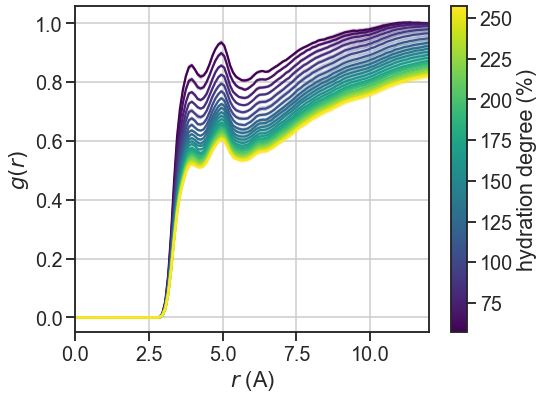

In [147]:
fig, ax = plt.subplots(1,1, figsize=(8,6))
sns.set_theme(style="ticks")
sns.set_context("talk", font_scale=1.2)

data=tdf
#
sns.lineplot(x="bins", y='rdf', data=data, 
                  hue="hydr_degree",
                  #style="state",
                  #markers=True, 
                  palette="viridis", 
                  #ci="sd", err_style="band",
                  ax=ax
                 )
#
ax.set_xlabel("$r$ (A)")
ax.set_ylabel("$g(r)$")
ax.set_xlim(xmin=0., xmax=12.)
#ax.set_ylim(ymin=0.0, ymax=15)
#ax.set_yscale("log")
#
# Remove the legend
ax.get_legend().remove()
#
ax.grid()

# add colorbar
norm = plt.Normalize(57., 257.)
sm = plt.cm.ScalarMappable(cmap="viridis", norm=norm)
sm.set_array([])
ax.figure.colorbar(sm, label='hydration degree (%)')

#plt.legend(bbox_to_anchor=(1.05, 0.95))

plt.tight_layout()
plt.show()

### Overlap region

In [150]:
# list water molecule counts
list_water=np.arange(12550, 57000, 2000)
#list_water=[12550]

# ensemble of replicas
list_rep=[1,2,3,4,5,6] #[1,2,3,4,5,6]

# state
list_state=["simNPT"] # "relax_constraint" "simNPT"

# atoms to include in RDF
select_ca='name CA'
select_wat='resname WAT and name O'

tdf = pd.DataFrame()
for nwat in list_water:
    for rep in list_rep:
        for state in list_state:
            univ = load_universe_replica_water_unwrapped(nwat,rep,state)
            #    
            select_zreg='prop z >= {} and prop z<{}'.format(0,300)
            acarbs=univ.select_atoms(select_ca+' and '+select_zreg)
            owats=univ.select_atoms(select_wat+' and '+select_zreg)
            #
            df = pd.DataFrame()
            #
            #workflow=[flatten_z]
            #univ.trajectory.add_transformations(*workflow)
            #print(univ.atoms.positions[:,2])
            #
            bins, rdf = compute_interrdf(acarbs, owats, tmin=80, tmax=-1, qmin=0, qmax=15.0, nbins=150)
            df["bins"] = bins
            df["rdf"] = rdf
            df['replica'] = rep
            df['state'] = state
            df['nwater'] = nwat
            df['hydr_degree'] = np.rint(np.round(nwat/22000,2)*100)
            tdf = tdf.append(df, ignore_index=True)

<DCDReader /Users/vassaux/sng_wrk72/tmp/NPT50NS1ATM298K12550WAT/12550WAT/rep1//simNPT_unwrapped.dcd with 100 frames of 76744 atoms>
<class 'MDAnalysis.core.universe.Universe'>
<DCDReader /Users/vassaux/sng_wrk72/tmp/NPT50NS1ATM298K12550WAT/12550WAT/rep2//simNPT_unwrapped.dcd with 100 frames of 76744 atoms>
<class 'MDAnalysis.core.universe.Universe'>
<DCDReader /Users/vassaux/sng_wrk72/tmp/NPT50NS1ATM298K12550WAT/12550WAT/rep3//simNPT_unwrapped.dcd with 100 frames of 76744 atoms>
<class 'MDAnalysis.core.universe.Universe'>
<DCDReader /Users/vassaux/sng_wrk72/tmp/NPT50NS1ATM298K12550WAT/12550WAT/rep4//simNPT_unwrapped.dcd with 100 frames of 76744 atoms>
<class 'MDAnalysis.core.universe.Universe'>
<DCDReader /Users/vassaux/sng_wrk72/tmp/NPT50NS1ATM298K12550WAT/12550WAT/rep5//simNPT_unwrapped.dcd with 100 frames of 76744 atoms>
<class 'MDAnalysis.core.universe.Universe'>
<DCDReader /Users/vassaux/sng_wrk72/tmp/NPT50NS1ATM298K12550WAT/12550WAT/rep6//simNPT_unwrapped.dcd with 100 frames of 7

<DCDReader /Users/vassaux/sng_wrk72/tmp/NPT50NS1ATM298K12550WAT/26550WAT/rep6//simNPT_unwrapped.dcd with 100 frames of 118744 atoms>
<class 'MDAnalysis.core.universe.Universe'>
<DCDReader /Users/vassaux/sng_wrk72/tmp/NPT50NS1ATM298K12550WAT/28550WAT/rep1//simNPT_unwrapped.dcd with 100 frames of 124744 atoms>
<class 'MDAnalysis.core.universe.Universe'>
<DCDReader /Users/vassaux/sng_wrk72/tmp/NPT50NS1ATM298K12550WAT/28550WAT/rep2//simNPT_unwrapped.dcd with 100 frames of 124744 atoms>
<class 'MDAnalysis.core.universe.Universe'>
<DCDReader /Users/vassaux/sng_wrk72/tmp/NPT50NS1ATM298K12550WAT/28550WAT/rep3//simNPT_unwrapped.dcd with 100 frames of 124744 atoms>
<class 'MDAnalysis.core.universe.Universe'>
<DCDReader /Users/vassaux/sng_wrk72/tmp/NPT50NS1ATM298K12550WAT/28550WAT/rep4//simNPT_unwrapped.dcd with 100 frames of 124744 atoms>
<class 'MDAnalysis.core.universe.Universe'>
<DCDReader /Users/vassaux/sng_wrk72/tmp/NPT50NS1ATM298K12550WAT/28550WAT/rep5//simNPT_unwrapped.dcd with 100 frames

KeyboardInterrupt: 

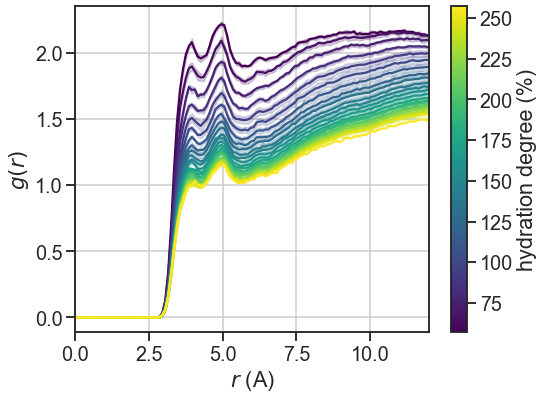

In [158]:
fig, ax = plt.subplots(1,1, figsize=(8,6))
sns.set_theme(style="ticks")
sns.set_context("talk", font_scale=1.2)

data=tdf
#
sns.lineplot(x="bins", y='rdf', data=data, 
                  hue="hydr_degree",
                  #style="state",
                  #markers=True, 
                  palette="viridis", 
                  #ci="sd", err_style="band",
                  ax=ax
                 )
#
ax.set_xlabel("$r$ (A)")
ax.set_ylabel("$g(r)$")
ax.set_xlim(xmin=0., xmax=12.)
#ax.set_ylim(ymin=0.0, ymax=15)
#ax.set_yscale("log")
#
# Remove the legend
ax.get_legend().remove()
#
ax.grid()

# add colorbar
norm = plt.Normalize(57., 257.)
sm = plt.cm.ScalarMappable(cmap="viridis", norm=norm)
sm.set_array([])
ax.figure.colorbar(sm, label='hydration degree (%)')

#plt.legend(bbox_to_anchor=(1.05, 0.95))

plt.tight_layout()
plt.show()

### Gap region

In [ ]:
# list water molecule counts
list_water=np.arange(12550, 57000, 2000)
#list_water=[12550]

# ensemble of replicas
list_rep=[1,2,3,4,5,6] #[1,2,3,4,5,6]

# state
list_state=["simNPT"] # "relax_constraint" "simNPT"

# atoms to include in RDF
select_ca='name CA'
select_wat='resname WAT and name O'

tdf = pd.DataFrame()
for nwat in list_water:
    for rep in list_rep:
        for state in list_state:
            univ = load_universe_replica_water_unwrapped(nwat,rep,state)
            #    
            select_zreg='prop z >= {} and prop z<{}'.format(305,670)
            acarbs=univ.select_atoms(select_ca+' and '+select_zreg)
            owats=univ.select_atoms(select_wat+' and '+select_zreg)
            #
            df = pd.DataFrame()
            #
            #workflow=[flatten_z]
            #univ.trajectory.add_transformations(*workflow)
            #print(univ.atoms.positions[:,2])
            #
            bins, rdf = compute_interrdf(acarbs, owats, tmin=80, tmax=-1, qmin=0, qmax=15.0, nbins=150)
            df["bins"] = bins
            df["rdf"] = rdf
            df['replica'] = rep
            df['state'] = state
            df['nwater'] = nwat
            df['hydr_degree'] = np.rint(np.round(nwat/22000,2)*100)
            tdf = tdf.append(df, ignore_index=True)

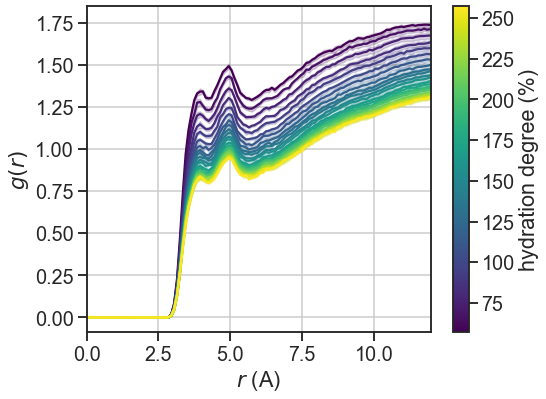

In [161]:
fig, ax = plt.subplots(1,1, figsize=(8,6))
sns.set_theme(style="ticks")
sns.set_context("talk", font_scale=1.2)

data=tdf
#
sns.lineplot(x="bins", y='rdf', data=data, 
                  hue="hydr_degree",
                  #style="state",
                  #markers=True, 
                  palette="viridis", 
                  #ci="sd", err_style="band",
                  ax=ax
                 )
#
ax.set_xlabel("$r$ (A)")
ax.set_ylabel("$g(r)$")
ax.set_xlim(xmin=0., xmax=12.)
#ax.set_ylim(ymin=0.0, ymax=5.0)
#ax.set_yscale("log")
#
# Remove the legend
ax.get_legend().remove()
#
ax.grid()

# add colorbar
norm = plt.Normalize(57., 257.)
sm = plt.cm.ScalarMappable(cmap="viridis", norm=norm)
sm.set_array([])
ax.figure.colorbar(sm, label='hydration degree (%)')

#plt.legend(bbox_to_anchor=(1.05, 0.95))

plt.tight_layout()
plt.show()

## Intermolecular distance between helix central axis
Helix central line and dimensions computations are done with python scripts stored in the NPTBLABLA/scripts directory

In [64]:
import MDAnalysis.analysis.rdf as RDF

In [65]:
def compute_interrdf(atomgroup1, atomgroup2, tmin=0, tmax=-1, qmin=0.0, qmax=20.0, nbins=100):
    rdf = RDF.InterRDF(atomgroup1, atomgroup2, 
                       range=[qmin, qmax], 
                       nbins=nbins)
    rdf.run(start=tmin, stop=tmax)
    return rdf.results.bins, rdf.results.rdf

In [310]:
def load_cline_protein_nwater_replica(nwater=12550, replica=1):
    datadir='/Users/vassaux/sng_wrk72/tmp/NPT50NS1ATM298K12550WAT/{}WAT/rep{}/'.format(nwater, replica)

    filename='mean-trajectory_helices_1000cores.npy'
    raw_traj = np.load(datadir+filename)
    filename='trajectory_dimensions.npy'
    full_dimensions = np.load(datadir+filename)

    # create molecule with N particles (x, y and z)
    ## create the Universe
    N_particles=raw_traj.shape[1]
    resindices = np.arange(N_particles)
    cline = mda.Universe.empty(N_particles,
                               n_residues=N_particles,
                               atom_resindex=resindices,
                               #residue_segindex=segindices,
                               trajectory=True) # necessary for adding coordinates
    cline.load_new(raw_traj[:,:,:3])
    #cline.atoms.positions = raw_traj[0,:,:3]
    cline.add_TopologyAttr('resid', list(range(1, N_particles+1)))

    # add dimensions to coarse-grained system
    for t in np.arange(cline.trajectory.n_frames):
        cline.trajectory[t].dimensions = full_dimensions[t]

    # wrap coordinates
    ag = cline.atoms
    transform0 = mda.transformations.wrap(ag)
    transform1 = mda.transformations.wrap(ag)
    workflow = [transform0, transform1]
    cline.trajectory.add_transformations(*workflow)
    return cline

### Whole microfibril

In [332]:
# list water molecule counts
list_water=np.arange(12550, 57000, 2000)
#list_water=[12550]

# ensemble of replicas
list_rep=[1,2,3,4,5,6] #[1,2,3,4,5,6]

# state
list_state=["simNPT"] # "relax_constraint" "simNPT"

tdf = pd.DataFrame()
for nwat in list_water:
    for rep in list_rep:
        for state in list_state:
            univ = load_cline_protein_nwater_replica(nwater=nwat, replica=rep)
            #
            print(nwat, rep, univ.atoms.n_atoms)
            df = pd.DataFrame()
            #
            #workflow=[flatten_z]
            #univ.trajectory.add_transformations(*workflow)
            #print(univ.atoms.positions[:,2])
            #
            bins, protein_rdf = compute_interrdf(univ.atoms, univ.atoms, tmin=80, tmax=-1, qmin=1, qmax=30.0, nbins=300)
            df["bins"] = bins
            df["CA_rdf"] = protein_rdf
            df['replica'] = rep
            df['state'] = state
            df['nwater'] = nwat
            df['hydr_degree'] = np.rint(np.round(nwat/22000,2)*100)
            tdf = tdf.append(df, ignore_index=True)

/Users/vassaux/source/miniconda3/envs/biomolecular-mdadev/lib/python3.8/site-packages/MDAnalysis/core/universe.py:439: UserWarning: Segments specified but no segment_resindex given.  All residues will be placed in first Segment
  warnings.warn(


100
12550 1 999
100
12550 2 999
100
12550 3 999
100
12550 4 999
100
12550 5 999
100
12550 6 999
100
14550 1 999
100
14550 2 999
100
14550 3 999
100
14550 4 999
100
14550 5 999
100
14550 6 999
100
16550 1 999
100
16550 2 999
100
16550 3 999
100
16550 4 999
100
16550 5 999
100
16550 6 999
100
18550 1 999
100
18550 2 999
100
18550 3 999
100
18550 4 999
100
18550 5 999
100
18550 6 999
100
20550 1 999
100
20550 2 999
100
20550 3 999
100
20550 4 999
100
20550 5 999
100
20550 6 999
100
22550 1 999
100
22550 2 999
100
22550 3 999
100
22550 4 999
100
22550 5 999
100
22550 6 999
100
24550 1 999
100
24550 2 999
100
24550 3 999
100
24550 4 999
100
24550 5 999
100
24550 6 999
100
26550 1 999
100
26550 2 999
100
26550 3 999
100
26550 4 999
100
26550 5 999
100
26550 6 999
100
28550 1 999
100
28550 2 999
100
28550 3 999
100
28550 4 999
100
28550 5 999
100
28550 6 999
100
30550 1 999
100
30550 2 999
100
30550 3 999
100
30550 4 999
100
30550 5 999
100
30550 6 999
100
32550 1 999
100
32550 2 999
100
3255

ZeroDivisionError: float division by zero

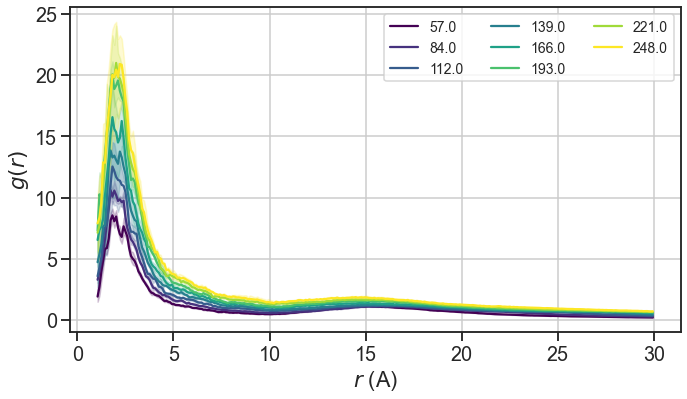

In [367]:
fig, ax = plt.subplots(1,1, figsize=(10,6))
sns.set_theme(style="ticks")
sns.set_context("talk", font_scale=1.2)

#nwater=12550
state="simNPT"

data=tdf[
         (tdf['state']==state)
         & (tdf['nwater']-550)/1000%6==0
        ]
#
sns.lineplot(x="bins", y='CA_rdf', data=data, 
             hue="hydr_degree",
             #style="state",
             #markers=True, 
             palette="viridis", 
             #ci="sd", err_style="band",
             legend="full",
             ax=ax
            )
#
ax.set_xlabel("$r$ (A)")
ax.set_ylabel("$g(r)$")
#ax.set_xlim(xmin=0., xmax=10.)
#ax.set_ylim(ymin=0.0, ymax=2.)
#ax.set_yscale("log")
#ax.set_title("state: {}".format(state))
#
# Remove the legend
#ax.get_legend().remove()
#
ax.grid()

# add colorbar
#norm = plt.Normalize(57., 257.)
#sm = plt.cm.ScalarMappable(cmap="viridis", norm=norm)
#sm.set_array([])
#ax.figure.colorbar(sm, label='hydration degree (%)')

plt.legend(#bbox_to_anchor=(1.05, 0.95), 
           ncol=3, fontsize="14")

plt.tight_layout()
plt.show()

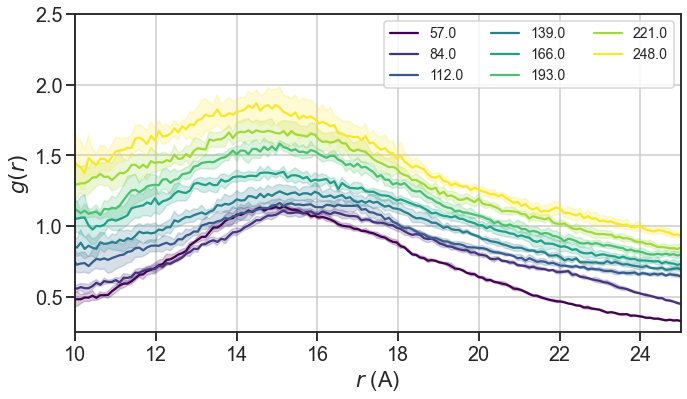

In [370]:
fig, ax = plt.subplots(1,1, figsize=(10,6))
sns.set_theme(style="ticks")
sns.set_context("talk", font_scale=1.2)

#nwater=12550
state="simNPT"

data=tdf[
         (tdf['state']==state)
         & (tdf['nwater']-550)/1000%6==0
        ]
#
sns.lineplot(x="bins", y='CA_rdf', data=data, 
             hue="hydr_degree",
             #style="state",
             #markers=True, 
             palette="viridis", 
             #ci="sd", err_style="band",
             legend="full",
             ax=ax
            )
#
ax.set_xlabel("$r$ (A)")
ax.set_ylabel("$g(r)$")
ax.set_xlim(xmin=10., xmax=25.)
ax.set_ylim(ymin=0.25, ymax=2.50)
#ax.set_yscale("log")
#ax.set_title("state: {}".format(state))
#
# Remove the legend
#ax.get_legend().remove()
#
ax.grid()

# add colorbar
#norm = plt.Normalize(57., 257.)
#sm = plt.cm.ScalarMappable(cmap="viridis", norm=norm)
#sm.set_array([])
#ax.figure.colorbar(sm, label='hydration degree (%)')

plt.legend(#bbox_to_anchor=(1.05, 0.95), 
           ncol=3, fontsize="14")

plt.tight_layout()
plt.show()

### Gap region

In [300]:
# list water molecule counts
list_water=np.arange(12550, 57000, 2000)
#list_water=[12550]

# ensemble of replicas
list_rep=[1,2,3,4,5,6] #[1,2,3,4,5,6]

# state
list_state=["simNPT"] # "relax_constraint" "simNPT"

tdf = pd.DataFrame()
for nwat in list_water:
    for rep in list_rep:
        for state in list_state:
            univ = load_cline_protein_nwater_replica(nwater=nwat, replica=rep)
            select_zreg='prop z >= {} and prop z<{}'.format(305,670)
            zreg_selection=univ.select_atoms(select_zreg)
            #
            print(nwat, rep, zreg_selection.n_atoms)
            df = pd.DataFrame()
            #
            #workflow=[flatten_z]
            #univ.trajectory.add_transformations(*workflow)
            #print(univ.atoms.positions[:,2])
            #
            bins, protein_rdf = compute_interrdf(zreg_selection, zreg_selection, tmin=80, tmax=-1, qmin=1, qmax=30.0, nbins=300)
            df["bins"] = bins
            df["CA_rdf"] = protein_rdf
            df['replica'] = rep
            df['state'] = state
            df['nwater'] = nwat
            df['hydr_degree'] = np.rint(np.round(nwat/22000,2)*100)
            tdf = tdf.append(df, ignore_index=True)

/Users/vassaux/source/miniconda3/envs/biomolecular-mdadev/lib/python3.8/site-packages/MDAnalysis/core/universe.py:439: UserWarning: Segments specified but no segment_resindex given.  All residues will be placed in first Segment
  warnings.warn(


IndexError: Index 99 exceeds length of trajectory (99).

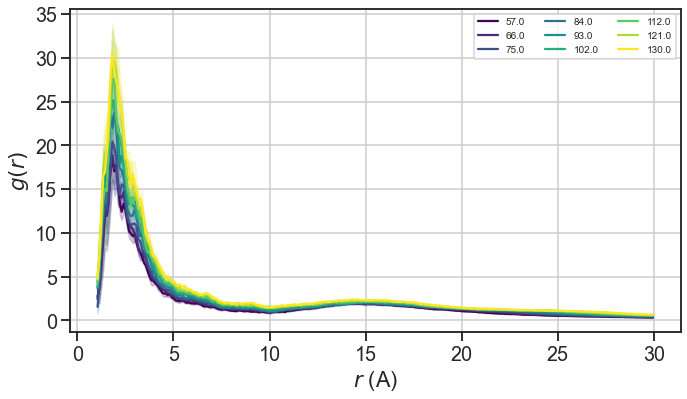

In [345]:
fig, ax = plt.subplots(1,1, figsize=(10,6))
sns.set_theme(style="ticks")
sns.set_context("talk", font_scale=1.2)

#nwater=12550
state="simNPT"

data=tdf[
         (tdf['state']==state)
        &(tdf['nwater']<30000)
        ]
#
sns.lineplot(x="bins", y='CA_rdf', data=data, 
             hue="hydr_degree",
             #style="state",
             #markers=True, 
             palette="viridis", 
             #ci="sd", err_style="band",
             legend="full",
             ax=ax
            )
#
ax.set_xlabel("$r$ (A)")
ax.set_ylabel("$g(r)$")
#ax.set_xlim(xmin=0., xmax=10.)
#ax.set_ylim(ymin=0.0, ymax=2.)
#ax.set_yscale("log")
#ax.set_title("state: {}".format(state))
#
# Remove the legend
#ax.get_legend().remove()
#
ax.grid()

# add colorbar
#norm = plt.Normalize(57., 257.)
#sm = plt.cm.ScalarMappable(cmap="viridis", norm=norm)
#sm.set_array([])
#ax.figure.colorbar(sm, label='hydration degree (%)')

plt.legend(#bbox_to_anchor=(1.05, 0.95), 
           ncol=3, fontsize="10")

plt.tight_layout()
plt.show()

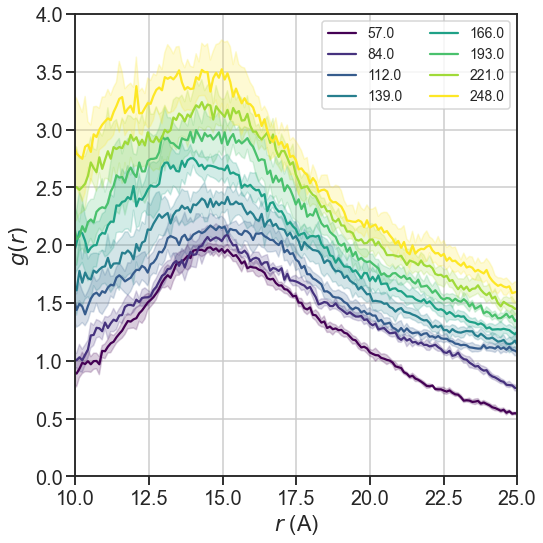

In [374]:
fig, ax = plt.subplots(1,1, figsize=(8,8))
sns.set_theme(style="ticks")
sns.set_context("talk", font_scale=1.2)

#nwater=12550
state="simNPT"

data=tdf[
          (tdf['state']==state)
        #& (tdf['nwater']<30000)
        & (tdf['nwater']-550)/1000%6==0
        ]
#
sns.lineplot(x="bins", y='CA_rdf', data=data, 
             hue="hydr_degree",
             #style="state",
             #markers=True, 
             palette="viridis", 
             #ci="sd", err_style="band",
             legend="full",
             ax=ax
            )
#
ax.set_xlabel("$r$ (A)")
ax.set_ylabel("$g(r)$")
ax.set_xlim(xmin=10., xmax=25.)
ax.set_ylim(ymin=0.0, ymax=4.0)
#ax.set_yscale("log")
#ax.set_title("state: {}".format(state))
#
# Remove the legend
#ax.get_legend().remove()
#
ax.grid()

# add colorbar
#norm = plt.Normalize(57., 257.)
#sm = plt.cm.ScalarMappable(cmap="viridis", norm=norm)
#sm.set_array([])
#ax.figure.colorbar(sm, label='hydration degree (%)')

plt.legend(#bbox_to_anchor=(1.05, 0.95), 
           ncol=2, fontsize="14")

plt.tight_layout()
plt.show()

### Overlap region

In [300]:
# list water molecule counts
list_water=np.arange(12550, 57000, 2000)
#list_water=[12550]

# ensemble of replicas
list_rep=[1,2,3,4,5,6] #[1,2,3,4,5,6]

# state
list_state=["simNPT"] # "relax_constraint" "simNPT"

tdf = pd.DataFrame()
for nwat in list_water:
    for rep in list_rep:
        for state in list_state:
            univ = load_cline_protein_nwater_replica(nwater=nwat, replica=rep)
            select_zreg='prop z >= {} and prop z<{}'.format(0,300)
            zreg_selection=univ.select_atoms(select_zreg)
            #
            print(nwat, rep, zreg_selection.n_atoms)
            df = pd.DataFrame()
            #
            #workflow=[flatten_z]
            #univ.trajectory.add_transformations(*workflow)
            #print(univ.atoms.positions[:,2])
            #
            bins, protein_rdf = compute_interrdf(zreg_selection, zreg_selection, tmin=80, tmax=-1, qmin=1, qmax=30.0, nbins=300)
            df["bins"] = bins
            df["CA_rdf"] = protein_rdf
            df['replica'] = rep
            df['state'] = state
            df['nwater'] = nwat
            df['hydr_degree'] = np.rint(np.round(nwat/22000,2)*100)
            tdf = tdf.append(df, ignore_index=True)

/Users/vassaux/source/miniconda3/envs/biomolecular-mdadev/lib/python3.8/site-packages/MDAnalysis/core/universe.py:439: UserWarning: Segments specified but no segment_resindex given.  All residues will be placed in first Segment
  warnings.warn(


IndexError: Index 99 exceeds length of trajectory (99).

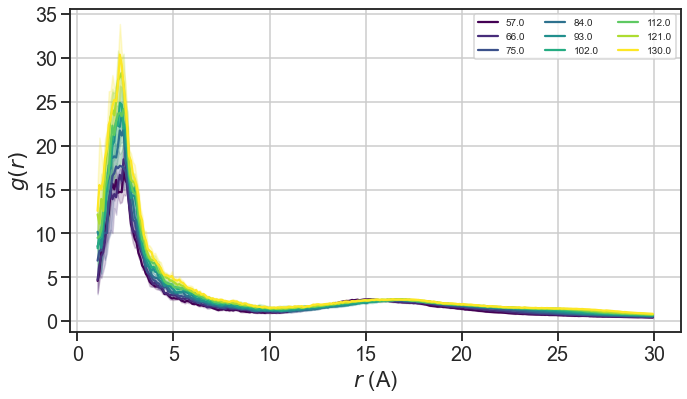

In [348]:
fig, ax = plt.subplots(1,1, figsize=(10,6))
sns.set_theme(style="ticks")
sns.set_context("talk", font_scale=1.2)

#nwater=12550
state="simNPT"

data=tdf[
          (tdf['state']==state)
        & (tdf['nwater']<30000)
        #& (tdf['nwater']-550)/1000%6==0
        ]
#
sns.lineplot(x="bins", y='CA_rdf', data=data, 
             hue="hydr_degree",
             #style="state",
             #markers=True, 
             palette="viridis", 
             #ci="sd", err_style="band",
             legend="full",
             ax=ax
            )
#
ax.set_xlabel("$r$ (A)")
ax.set_ylabel("$g(r)$")
#ax.set_xlim(xmin=0., xmax=10.)
#ax.set_ylim(ymin=0.0, ymax=2.)
#ax.set_yscale("log")
#ax.set_title("state: {}".format(state))
#
# Remove the legend
#ax.get_legend().remove()
#
ax.grid()

# add colorbar
#norm = plt.Normalize(57., 257.)
#sm = plt.cm.ScalarMappable(cmap="viridis", norm=norm)
#sm.set_array([])
#ax.figure.colorbar(sm, label='hydration degree (%)')

plt.legend(#bbox_to_anchor=(1.05, 0.95), 
           ncol=3, fontsize="10")

plt.tight_layout()
plt.show()

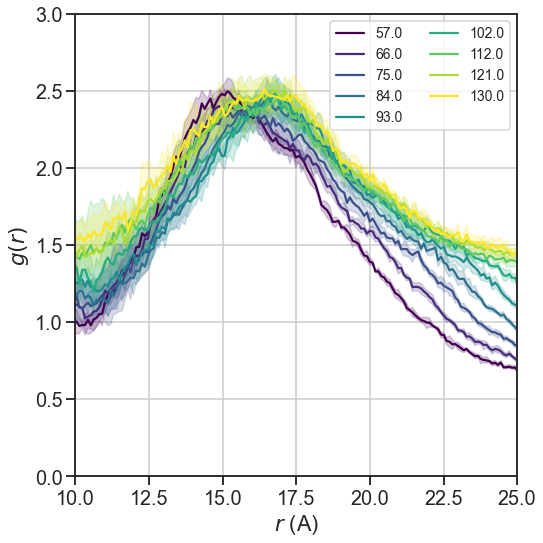

In [351]:
fig, ax = plt.subplots(1,1, figsize=(8,8))
sns.set_theme(style="ticks")
sns.set_context("talk", font_scale=1.2)

#nwater=12550
state="simNPT"

data=tdf[
          (tdf['state']==state)
        #& (tdf['nwater']<30000)
        & (tdf['nwater']-550)/1000%6==0
        ]
#
sns.lineplot(x="bins", y='CA_rdf', data=data, 
             hue="hydr_degree",
             #style="state",
             #markers=True, 
             palette="viridis", 
             #ci="sd", err_style="band",
             legend="full",
             ax=ax
            )
#
ax.set_xlabel("$r$ (A)")
ax.set_ylabel("$g(r)$")
ax.set_xlim(xmin=10., xmax=25.)
ax.set_ylim(ymin=0.0, ymax=3.)
#ax.set_yscale("log")
#ax.set_title("state: {}".format(state))
#
# Remove the legend
#ax.get_legend().remove()
#
ax.grid()

# add colorbar
#norm = plt.Normalize(57., 257.)
#sm = plt.cm.ScalarMappable(cmap="viridis", norm=norm)
#sm.set_array([])
#ax.figure.colorbar(sm, label='hydration degree (%)')

plt.legend(#bbox_to_anchor=(1.05, 0.95), 
           ncol=2, fontsize="14")

plt.tight_layout()
plt.show()

## Radial distribution of water molecules around water molecules

In [165]:
import MDAnalysis.analysis.rdf as RDF

In [166]:
def compute_interrdf(atomgroup1, atomgroup2, tmin=0, tmax=-1, qmin=0.0, qmax=20.0, nbins=100):
    rdf = RDF.InterRDF(atomgroup1, atomgroup2, 
                       range=[qmin, qmax], 
                       nbins=nbins)
    rdf.run(start=tmin, stop=tmax)
    return rdf.results.bins, rdf.results.rdf

In [167]:
def load_universe_local():
    # trajectory info: T=50e-9s, nts=25000000, dts=2e-15s, nfr=100, dfr=dts*nts/nfr=0.5e-9s
    main_dir = "/Users/vassaux/Downloads/"
    sim_name = "3hr2_clean_amber_mutations_modifications_missing_charged_minim_pbc_solvated_equilibrated_hydrated"
    u = mda.Universe(main_dir+sim_name+".pdb", main_dir+"/simNPT_unwrapped.dcd")
    return u

In [168]:
def load_universe_replica_water_unwrapped(nwater=12550, replica=1,state="simNPT"):
    # trajectory info: T=50e-9s, nts=25000000, dts=2e-15s, nfr=100, dfr=dts*nts/nfr=0.5e-9s
    main_dir = "/Users/vassaux/sng_wrk72/tmp/NPT50NS1ATM298K12550WAT/"
    data_dir = main_dir+"{}WAT/rep{}/".format(nwater,replica)
    sim_name = "3hr2_clean_amber_mutations_modifications_missing_charged_minim_pbc_solvated_equilibrated_hydrated".format(nwater)
    if state=="simNPT":
        u = mda.Universe(data_dir+sim_name+".pdb", data_dir+"/simNPT_unwrapped.dcd")
    elif state=="relax_constraint":
        u = mda.Universe(data_dir+sim_name+".pdb", data_dir+"/relax_constraint_extended/relax_constraint_unwrapped.dcd")
    print(u.trajectory)
    print(type(u))
    return u

### Whole crystal

In [42]:
# mapping
z = np.linspace(-100, 800, num=2) # np.linspace(-100, 800, num=30)

# list water molecule counts
list_water=np.arange(56550, 57000, 2000)
#list_water=[12550]

# ensemble of replicas
list_rep=[1,2,3,4,5,6]

# state
list_state=["simNPT"] # "relax_constraint" "simNPT"

# atoms to include in RDF
select_water = "resname WAT and name O"
#tdf = pd.DataFrame()
for nwat in list_water:
    for rep in list_rep:
        for state in list_state:
            univ = load_universe_replica_water_unwrapped(nwat,rep,state)
            #univ = load_universe_local()
            for j in range(len(z)-1):
                select_zreg='prop z >= {} and prop z<{}'.format(z[j],z[j+1])
                select_water_z=select_water+" and "+select_zreg
                #
                water_z=univ.select_atoms(select_water_z)
                print(water_z.n_atoms, water_z.n_atoms)
                df = pd.DataFrame()
                #
                bins, protein_rdf = compute_interrdf(water_z, water_z, tmin=80, tmax=-1, qmax=10.0, nbins=300)
                df["bins"] = bins
                df["O_rdf"] = protein_rdf
                df['z'] = (z[j]+z[j+1])/2
                df["z_cg"] = np.round(df['z']/100,0)*100
                df['replica'] = rep
                df['state'] = state
                df['nwater'] = nwat
                df['hydr_degree'] = np.rint(np.round(nwat/22000,2)*100)
                tdf = tdf.append(df, ignore_index=True)

/Users/vassaux/source/miniconda3/envs/biomolecular-mdadev/lib/python3.8/site-packages/MDAnalysis/topology/PDBParser.py:317: UserWarning: Element information is missing, elements attribute will not be populated. If needed these can be guessed using MDAnalysis.topology.guessers.
  warnings.warn("Element information is missing, elements attribute "


<DCDReader /Users/vassaux/sng_wrk72/tmp/NPT50NS1ATM298K12550WAT/56550WAT/rep1//simNPT_unwrapped.dcd with 100 frames of 208744 atoms>
<class 'MDAnalysis.core.universe.Universe'>
56550 56550
<DCDReader /Users/vassaux/sng_wrk72/tmp/NPT50NS1ATM298K12550WAT/56550WAT/rep2//simNPT_unwrapped.dcd with 75 frames of 208744 atoms>
<class 'MDAnalysis.core.universe.Universe'>
56550 56550


ZeroDivisionError: float division by zero

/Users/vassaux/source/miniconda3/envs/biomolecular-mdadev/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


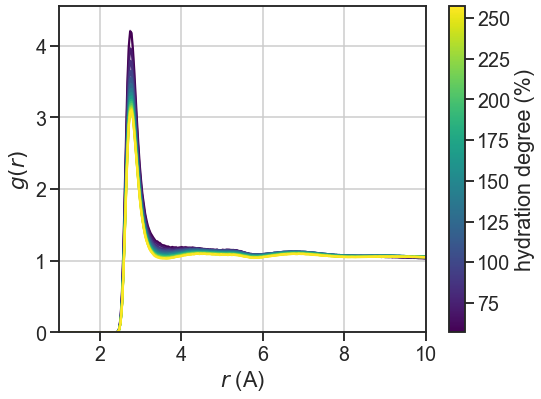

In [49]:
fig, ax = plt.subplots(1,1, figsize=(8,6))
sns.set_theme(style="ticks")
sns.set_context("talk", font_scale=1.2)

nwater=12550
state="simNPT"

data=tdf[#(tdf['nwater']==nwater) &
         (tdf["z"]>-10) & (tdf["z"]<680) &
         (tdf['state']==state)
        ]
#
sns.lineplot("bins", 'O_rdf', data=data, 
                  hue="hydr_degree",
                  #style="state",
                  #markers=True, 
                  palette="viridis", 
                  #ci="sd", err_style="band",
                  ax=ax
                 )
#
ax.set_xlabel("$r$ (A)")
ax.set_ylabel("$g(r)$")
ax.set_xlim(xmin=1.0, xmax=10.)
ax.set_ylim(ymin=0.0, ymax=4.55)
#ax.set_yscale("log")
#ax.set_title("state: {}".format(state))
#
# Remove the legend
ax.get_legend().remove()
#
ax.grid()

# add colorbar
norm = plt.Normalize(57., 257.)
sm = plt.cm.ScalarMappable(cmap="viridis", norm=norm)
sm.set_array([])
ax.figure.colorbar(sm, label='hydration degree (%)')

plt.tight_layout()
plt.show()

/Users/vassaux/source/miniconda3/envs/biomolecular-mdadev/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


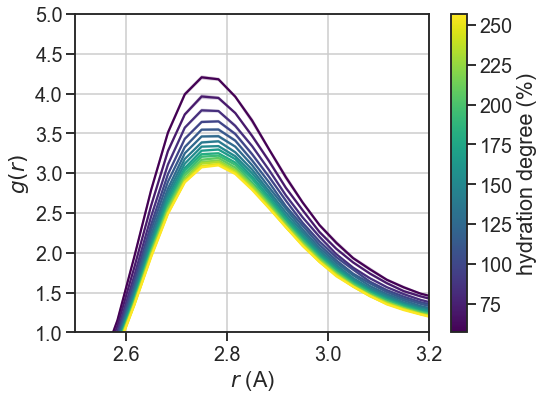

In [45]:
fig, ax = plt.subplots(1,1, figsize=(8,6))
sns.set_theme(style="ticks")
sns.set_context("talk", font_scale=1.2)

nwater=12550
state="simNPT"

data=tdf[#(tdf['nwater']==nwater) &
         (tdf["z"]>-10) & (tdf["z"]<680) &
         (tdf['state']==state)
        ]
#
sns.lineplot("bins", 'O_rdf', data=data, 
                  hue="hydr_degree",
                  #style="state",
                  #markers=True, 
                  palette="viridis", 
                  #ci="sd", err_style="band",
                  ax=ax
                 )
#
ax.set_xlabel("$r$ (A)")
ax.set_ylabel("$g(r)$")
ax.set_xlim(xmin=2.5, xmax=3.2)
ax.set_ylim(ymin=1.0, ymax=5)
#ax.set_yscale("log")
#ax.set_title("state: {}".format(state))
#
# Remove the legend
ax.get_legend().remove()
#
ax.grid()

# add colorbar
norm = plt.Normalize(57., 257.)
sm = plt.cm.ScalarMappable(cmap="viridis", norm=norm)
sm.set_array([])
ax.figure.colorbar(sm, label='hydration degree (%)')

plt.tight_layout()
plt.show()

/Users/vassaux/source/miniconda3/envs/biomolecular-mdadev/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


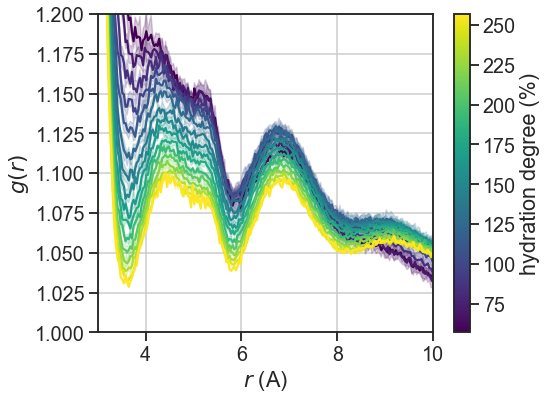

In [47]:
fig, ax = plt.subplots(1,1, figsize=(8,6))
sns.set_theme(style="ticks")
sns.set_context("talk", font_scale=1.2)

nwater=12550
state="simNPT"

data=tdf[#(tdf['nwater']==nwater) &
         (tdf["z"]>-10) & (tdf["z"]<680) &
         (tdf['state']==state)
        ]
#
sns.lineplot("bins", 'O_rdf', data=data, 
                  hue="hydr_degree",
                  #style="state",
                  #markers=True, 
                  palette="viridis", 
                  #ci="sd", err_style="band",
                  ax=ax
                 )
#
ax.set_xlabel("$r$ (A)")
ax.set_ylabel("$g(r)$")
ax.set_xlim(xmin=3.0, xmax=10.)
ax.set_ylim(ymin=1.0, ymax=1.2)
#ax.set_yscale("log")
#ax.set_title("state: {}".format(state))
#
# Remove the legend
ax.get_legend().remove()
#
ax.grid()

# add colorbar
norm = plt.Normalize(57., 257.)
sm = plt.cm.ScalarMappable(cmap="viridis", norm=norm)
sm.set_array([])
ax.figure.colorbar(sm, label='hydration degree (%)')

plt.tight_layout()
plt.show()

### Gap and Overlap regions

In [54]:
# mapping
z = [[50.,250.],[350.,650.]] #np.linspace(350, 600, num=2) # np.linspace(-100, 800, num=30)

# list water molecule counts
list_water=np.arange(12550, 57000, 3000)
#list_water=[12550]

# ensemble of replicas
list_rep=[1,2,3,4,5,6]

# state
list_state=["simNPT"] # "relax_constraint" "simNPT"

# atoms to include in RDF
select_water = "resname WAT and name O"
tdf = pd.DataFrame()
for nwat in list_water:
    for rep in list_rep:
        for state in list_state:
            univ = load_universe_replica_water_unwrapped(nwat,rep,state)
            #univ = load_universe_local()
            for (j,k) in z:
                select_zreg='prop z >= {} and prop z<{}'.format(j,k)
                select_water_z=select_water+" and "+select_zreg
                #
                water_z=univ.select_atoms(select_water_z)
                print(water_z.n_atoms, water_z.n_atoms)
                df = pd.DataFrame()
                #
                bins, protein_rdf = compute_interrdf(water_z, water_z, tmin=80, tmax=-1, qmax=10.0, nbins=300)
                df["bins"] = bins
                df["O_rdf"] = protein_rdf
                df['z'] = (j+k)/2
                df["z_cg"] = np.round(df['z']/100,0)*100
                df['replica'] = rep
                df['state'] = state
                df['nwater'] = nwat
                df['hydr_degree'] = np.rint(np.round(nwat/22000,2)*100)
                tdf = tdf.append(df, ignore_index=True)

<DCDReader /Users/vassaux/sng_wrk72/tmp/NPT50NS1ATM298K12550WAT/12550WAT/rep1//simNPT_unwrapped.dcd with 100 frames of 76744 atoms>
<class 'MDAnalysis.core.universe.Universe'>
3186 3186
6267 6267
<DCDReader /Users/vassaux/sng_wrk72/tmp/NPT50NS1ATM298K12550WAT/12550WAT/rep2//simNPT_unwrapped.dcd with 100 frames of 76744 atoms>
<class 'MDAnalysis.core.universe.Universe'>
3171 3171
6267 6267
<DCDReader /Users/vassaux/sng_wrk72/tmp/NPT50NS1ATM298K12550WAT/12550WAT/rep3//simNPT_unwrapped.dcd with 100 frames of 76744 atoms>
<class 'MDAnalysis.core.universe.Universe'>
3205 3205
6263 6263
<DCDReader /Users/vassaux/sng_wrk72/tmp/NPT50NS1ATM298K12550WAT/12550WAT/rep4//simNPT_unwrapped.dcd with 100 frames of 76744 atoms>
<class 'MDAnalysis.core.universe.Universe'>
3205 3205
6242 6242
<DCDReader /Users/vassaux/sng_wrk72/tmp/NPT50NS1ATM298K12550WAT/12550WAT/rep5//simNPT_unwrapped.dcd with 100 frames of 76744 atoms>
<class 'MDAnalysis.core.universe.Universe'>
3183 3183
6271 6271
<DCDReader /Users/va

14390 14390
<DCDReader /Users/vassaux/sng_wrk72/tmp/NPT50NS1ATM298K12550WAT/33550WAT/rep1//simNPT_unwrapped.dcd with 100 frames of 139744 atoms>
<class 'MDAnalysis.core.universe.Universe'>
9376 9376
15624 15624
<DCDReader /Users/vassaux/sng_wrk72/tmp/NPT50NS1ATM298K12550WAT/33550WAT/rep2//simNPT_unwrapped.dcd with 100 frames of 139744 atoms>
<class 'MDAnalysis.core.universe.Universe'>
9434 9434
15605 15605
<DCDReader /Users/vassaux/sng_wrk72/tmp/NPT50NS1ATM298K12550WAT/33550WAT/rep3//simNPT_unwrapped.dcd with 100 frames of 139744 atoms>
<class 'MDAnalysis.core.universe.Universe'>
9434 9434
15646 15646
<DCDReader /Users/vassaux/sng_wrk72/tmp/NPT50NS1ATM298K12550WAT/33550WAT/rep4//simNPT_unwrapped.dcd with 100 frames of 139744 atoms>
<class 'MDAnalysis.core.universe.Universe'>
9400 9400
15597 15597
<DCDReader /Users/vassaux/sng_wrk72/tmp/NPT50NS1ATM298K12550WAT/33550WAT/rep5//simNPT_unwrapped.dcd with 100 frames of 139744 atoms>
<class 'MDAnalysis.core.universe.Universe'>
9468 9468
15698

23615 23615
<DCDReader /Users/vassaux/sng_wrk72/tmp/NPT50NS1ATM298K12550WAT/51550WAT/rep6//simNPT_unwrapped.dcd with 100 frames of 193744 atoms>
<class 'MDAnalysis.core.universe.Universe'>
14802 14802
23546 23546
<DCDReader /Users/vassaux/sng_wrk72/tmp/NPT50NS1ATM298K12550WAT/54550WAT/rep1//simNPT_unwrapped.dcd with 100 frames of 202744 atoms>
<class 'MDAnalysis.core.universe.Universe'>
15495 15495
24897 24897
<DCDReader /Users/vassaux/sng_wrk72/tmp/NPT50NS1ATM298K12550WAT/54550WAT/rep2//simNPT_unwrapped.dcd with 100 frames of 202744 atoms>
<class 'MDAnalysis.core.universe.Universe'>
15722 15722
24928 24928
<DCDReader /Users/vassaux/sng_wrk72/tmp/NPT50NS1ATM298K12550WAT/54550WAT/rep3//simNPT_unwrapped.dcd with 100 frames of 202744 atoms>
<class 'MDAnalysis.core.universe.Universe'>
15628 15628
24829 24829
<DCDReader /Users/vassaux/sng_wrk72/tmp/NPT50NS1ATM298K12550WAT/54550WAT/rep4//simNPT_unwrapped.dcd with 100 frames of 202744 atoms>
<class 'MDAnalysis.core.universe.Universe'>
15522 1

/Users/vassaux/source/miniconda3/envs/biomolecular-mdadev/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


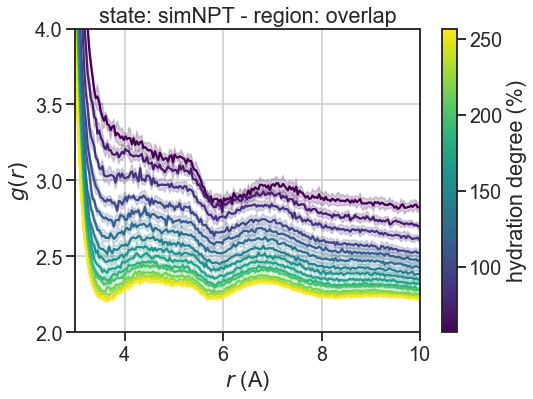

In [60]:
fig, ax = plt.subplots(1,1, figsize=(8,6))
sns.set_theme(style="ticks")
sns.set_context("talk", font_scale=1.2)

state="simNPT"

data=tdf[#(tdf['nwater']==nwater) &
         (tdf["z"]<300.) &
         (tdf['state']==state)
        ]
#
sns.lineplot("bins", 'O_rdf', data=data, 
                  hue="hydr_degree",
                  #style="state",
                  #markers=True, 
                  palette="viridis", 
                  #ci="sd", err_style="band",
                  ax=ax
                 )
#
ax.set_xlabel("$r$ (A)")
ax.set_ylabel("$g(r)$")
ax.set_xlim(xmin=3., xmax=10.)
ax.set_ylim(ymin=2., ymax=4.)
#ax.set_yscale("log")
ax.set_title("state: {} - region: overlap".format(state ))
#
# Remove the legend
ax.get_legend().remove()
#
ax.grid()

# add colorbar
norm = plt.Normalize(57., 257.)
sm = plt.cm.ScalarMappable(cmap="viridis", norm=norm)
sm.set_array([])
ax.figure.colorbar(sm, label='hydration degree (%)')

plt.tight_layout()
plt.show()

/Users/vassaux/source/miniconda3/envs/biomolecular-mdadev/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


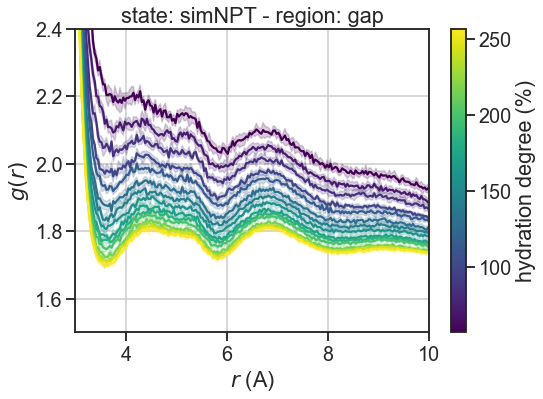

In [61]:
fig, ax = plt.subplots(1,1, figsize=(8,6))
sns.set_theme(style="ticks")
sns.set_context("talk", font_scale=1.2)

state="simNPT"

data=tdf[#(tdf['nwater']==nwater) &
         (tdf["z"]>300.) &
         (tdf['state']==state)
        ]
#
sns.lineplot("bins", 'O_rdf', data=data, 
                  hue="hydr_degree",
                  #style="state",
                  #markers=True, 
                  palette="viridis", 
                  #ci="sd", err_style="band",
                  ax=ax
                 )
#
ax.set_xlabel("$r$ (A)")
ax.set_ylabel("$g(r)$")
ax.set_xlim(xmin=3., xmax=10.)
ax.set_ylim(ymin=1.5, ymax=2.4)
#ax.set_yscale("log")
ax.set_title("state: {} - region: gap".format(state ))
#
# Remove the legend
ax.get_legend().remove()
#
ax.grid()

# add colorbar
norm = plt.Normalize(57., 257.)
sm = plt.cm.ScalarMappable(cmap="viridis", norm=norm)
sm.set_array([])
ax.figure.colorbar(sm, label='hydration degree (%)')

plt.tight_layout()
plt.show()

## Hydrogen bonds

In [3]:
from MDAnalysis.analysis.hydrogenbonds.hbond_analysis import HydrogenBondAnalysis as HBA

In [4]:
def load_universe_replica_water_unwrapped(nwater=12550, replica=1,state="simNPT"):
    # trajectory info: T=50e-9s, nts=25000000, dts=2e-15s, nfr=100, dfr=dts*nts/nfr=0.5e-9s
    #main_dir = "/Users/vassaux/kathleen_home/tmp/model_collagen/npt_relaxation/production_60ns/NPT50NS1ATM298K12550WAT/"
    main_dir = "/Users/vassaux/sng_wrk72/tmp/NPT50NS1ATM298K12550WAT/"
    data_dir = main_dir+"{}WAT/rep{}/".format(nwater,replica)
    sim_name = "3hr2_clean_amber_mutations_modifications_missing_charged_minim_pbc_solvated_equilibrated_hydrated"
    if state=="simNPT":
        u = mda.Universe(data_dir+sim_name+".prmtop", data_dir+"/simNPT_unwrapped.dcd")
    elif state=="relax_constraint":
        u = mda.Universe(data_dir+sim_name+".prmtop", data_dir+"/relax_constraint_extended/relax_constraint_unwrapped.dcd")
    print(u.trajectory)
    print(type(u))
    return u

### Hydrogen bond lifetime at physiological hydration

In [88]:
def compute_hbonds_lifetime(univ):
    tdf = pd.DataFrame()
    hbonds_waterwater = HBA(universe=univ, update_selections=False, hydrogens_sel='(resname WAT and name H*)', acceptors_sel='resname WAT')
    hbonds_waterwater.run(step=1)
    arr_ww = hbonds_waterwater.lifetime()
    df_ww = pd.DataFrame(arr_ww.T,  columns=['tau','autocorrelation'])
    df_ww["type"] = "w-w"
    tdf = tdf.append(df_ww, ignore_index=True)
    #
    hbonds_waterprotein = HBA(universe=univ, update_selections=False, hydrogens_sel='(resname WAT and name H*)', acceptors_sel='protein')
    hbonds_waterprotein.run(step=1)
    arr_wp = hbonds_waterprotein.lifetime()
    df_wp = pd.DataFrame(arr_wp.T,  columns=['tau','autocorrelation'])
    df_wp["type"] = "w-p"
    tdf = tdf.append(df_wp, ignore_index=True)
    #
    hbonds_proteinwater = HBA(universe=univ, update_selections=False, hydrogens_sel='(protein and name H*)', acceptors_sel='resname WAT')
    hbonds_proteinwater.run(step=1)
    arr_pw = hbonds_proteinwater.lifetime()
    df_pw = pd.DataFrame(arr_pw.T,  columns=['tau','autocorrelation'])
    df_pw["type"] = "p-w"
    tdf = tdf.append(df_pw, ignore_index=True)
    #
    hbonds_proteinprotein = HBA(universe=univ, update_selections=False, hydrogens_sel='(protein and name H*)', acceptors_sel='protein')
    hbonds_proteinprotein.run(step=1)
    arr_pp = hbonds_proteinprotein.lifetime()
    df_pp = pd.DataFrame(arr_pp.T,  columns=['tau','autocorrelation'])
    df_pp["type"] = "p-p"
    tdf = tdf.append(df_pp, ignore_index=True)
    #
    return tdf

In [135]:
dt=2e-15*50000 #timestep * steps between frame

# list water molecule counts
list_water=np.arange(12550, 57000, 3000)

# ensemble of replicas
list_rep=[1,2,3,4,5,6]

# state
list_state=["simNPT"] # "relax_constraint" "simNPT"

tdf = pd.DataFrame()
for nwat in list_water:
    for rep in list_rep:
        for state in list_state:
            univ = load_universe_replica_water_unwrapped(nwat,rep,state)
            df = compute_hbonds_lifetime(univ)
            df['replica'] = rep
            df['state'] = state
            df['nwater'] = nwat
            df['hydration_degree'] = np.rint(np.round(nwat/22000,2)*100)
            df['lagtime'] = df["tau"]*dt 
            tdf = tdf.append(df, ignore_index=True)

<DCDReader /Users/vassaux/kathleen_home/tmp/model_collagen/npt_relaxation/production_60ns/NPT50NS1ATM298K12550WAT/12550WAT/rep1//simNPT_unwrapped.dcd with 100 frames of 76744 atoms>
<class 'MDAnalysis.core.universe.Universe'>
<DCDReader /Users/vassaux/kathleen_home/tmp/model_collagen/npt_relaxation/production_60ns/NPT50NS1ATM298K12550WAT/14550WAT/rep1//simNPT_unwrapped.dcd with 100 frames of 82744 atoms>
<class 'MDAnalysis.core.universe.Universe'>
<DCDReader /Users/vassaux/kathleen_home/tmp/model_collagen/npt_relaxation/production_60ns/NPT50NS1ATM298K12550WAT/16550WAT/rep1//simNPT_unwrapped.dcd with 100 frames of 88744 atoms>
<class 'MDAnalysis.core.universe.Universe'>
<DCDReader /Users/vassaux/kathleen_home/tmp/model_collagen/npt_relaxation/production_60ns/NPT50NS1ATM298K12550WAT/18550WAT/rep1//simNPT_unwrapped.dcd with 100 frames of 94744 atoms>
<class 'MDAnalysis.core.universe.Universe'>
<DCDReader /Users/vassaux/kathleen_home/tmp/model_collagen/npt_relaxation/production_60ns/NPT50N

### Hydrogen bonds involving at least one water molecule

In [90]:
def compute_hbonds_onewater(univ):
    hbonds_waterwater = HBA(universe=univ, update_selections=False, hydrogens_sel='(resname WAT and name H*)', acceptors_sel='resname WAT')
    hbonds_waterwater.run(step=10)
    hbonds_waterprotein = HBA(universe=univ, update_selections=False, hydrogens_sel='(resname WAT and name H*)', acceptors_sel='protein')
    hbonds_waterprotein.run(step=10)
    hbonds_proteinwater = HBA(universe=univ, update_selections=False, hydrogens_sel='(protein and name H*)', acceptors_sel='resname WAT')
    hbonds_proteinwater.run(step=10)
    arr = [["w-w", hbonds_waterwater.count_by_time().mean(), hbonds_waterwater.count_by_time().std()],
           ["w-p", hbonds_waterprotein.count_by_time().mean(), hbonds_waterprotein.count_by_time().std()],
           ["p-w", hbonds_proteinwater.count_by_time().mean(), hbonds_proteinwater.count_by_time().std()]]
    tdf = pd.DataFrame(arr, columns=["type", "mean", "std"])
    return tdf

In [91]:
# list water molecule counts
list_water=np.arange(12550, 57000, 2000)

# ensemble of replicas
list_rep=[1,2,3,4,5,6]

# state
list_state=["simNPT"] # "relax_constraint" "simNPT"

tdf = pd.DataFrame()
for nwat in list_water:
    for rep in list_rep:
        for state in list_state:
            univ = load_universe_replica_water_unwrapped(nwat,rep,state)
            df = compute_hbonds_onewater(univ)
            df['replica'] = rep
            df['state'] = state
            df['nwater'] = nwat
            df["hbond_per_water_per_type"] = df['mean']/df['nwater']
            df['hydration_degree'] = np.rint(np.round(nwat/22000,2)*100)
            tdf = tdf.append(df, ignore_index=True)

<DCDReader /Users/vassaux/sng_wrk72/tmp/NPT50NS1ATM298K12550WAT/12550WAT/rep1//simNPT_unwrapped.dcd with 100 frames of 76744 atoms>
<class 'MDAnalysis.core.universe.Universe'>
<DCDReader /Users/vassaux/sng_wrk72/tmp/NPT50NS1ATM298K12550WAT/12550WAT/rep2//simNPT_unwrapped.dcd with 100 frames of 76744 atoms>
<class 'MDAnalysis.core.universe.Universe'>
<DCDReader /Users/vassaux/sng_wrk72/tmp/NPT50NS1ATM298K12550WAT/12550WAT/rep3//simNPT_unwrapped.dcd with 100 frames of 76744 atoms>
<class 'MDAnalysis.core.universe.Universe'>
<DCDReader /Users/vassaux/sng_wrk72/tmp/NPT50NS1ATM298K12550WAT/12550WAT/rep4//simNPT_unwrapped.dcd with 100 frames of 76744 atoms>
<class 'MDAnalysis.core.universe.Universe'>
<DCDReader /Users/vassaux/sng_wrk72/tmp/NPT50NS1ATM298K12550WAT/12550WAT/rep5//simNPT_unwrapped.dcd with 100 frames of 76744 atoms>
<class 'MDAnalysis.core.universe.Universe'>
<DCDReader /Users/vassaux/sng_wrk72/tmp/NPT50NS1ATM298K12550WAT/12550WAT/rep6//simNPT_unwrapped.dcd with 100 frames of 7

<DCDReader /Users/vassaux/sng_wrk72/tmp/NPT50NS1ATM298K12550WAT/26550WAT/rep6//simNPT_unwrapped.dcd with 100 frames of 118744 atoms>
<class 'MDAnalysis.core.universe.Universe'>
<DCDReader /Users/vassaux/sng_wrk72/tmp/NPT50NS1ATM298K12550WAT/28550WAT/rep1//simNPT_unwrapped.dcd with 100 frames of 124744 atoms>
<class 'MDAnalysis.core.universe.Universe'>
<DCDReader /Users/vassaux/sng_wrk72/tmp/NPT50NS1ATM298K12550WAT/28550WAT/rep2//simNPT_unwrapped.dcd with 100 frames of 124744 atoms>
<class 'MDAnalysis.core.universe.Universe'>
<DCDReader /Users/vassaux/sng_wrk72/tmp/NPT50NS1ATM298K12550WAT/28550WAT/rep3//simNPT_unwrapped.dcd with 100 frames of 124744 atoms>
<class 'MDAnalysis.core.universe.Universe'>
<DCDReader /Users/vassaux/sng_wrk72/tmp/NPT50NS1ATM298K12550WAT/28550WAT/rep4//simNPT_unwrapped.dcd with 100 frames of 124744 atoms>
<class 'MDAnalysis.core.universe.Universe'>
<DCDReader /Users/vassaux/sng_wrk72/tmp/NPT50NS1ATM298K12550WAT/28550WAT/rep5//simNPT_unwrapped.dcd with 100 frames

<DCDReader /Users/vassaux/sng_wrk72/tmp/NPT50NS1ATM298K12550WAT/42550WAT/rep5//simNPT_unwrapped.dcd with 100 frames of 166744 atoms>
<class 'MDAnalysis.core.universe.Universe'>
<DCDReader /Users/vassaux/sng_wrk72/tmp/NPT50NS1ATM298K12550WAT/42550WAT/rep6//simNPT_unwrapped.dcd with 100 frames of 166744 atoms>
<class 'MDAnalysis.core.universe.Universe'>
<DCDReader /Users/vassaux/sng_wrk72/tmp/NPT50NS1ATM298K12550WAT/44550WAT/rep1//simNPT_unwrapped.dcd with 100 frames of 172744 atoms>
<class 'MDAnalysis.core.universe.Universe'>
<DCDReader /Users/vassaux/sng_wrk72/tmp/NPT50NS1ATM298K12550WAT/44550WAT/rep2//simNPT_unwrapped.dcd with 100 frames of 172744 atoms>
<class 'MDAnalysis.core.universe.Universe'>
<DCDReader /Users/vassaux/sng_wrk72/tmp/NPT50NS1ATM298K12550WAT/44550WAT/rep3//simNPT_unwrapped.dcd with 100 frames of 172744 atoms>
<class 'MDAnalysis.core.universe.Universe'>
<DCDReader /Users/vassaux/sng_wrk72/tmp/NPT50NS1ATM298K12550WAT/44550WAT/rep4//simNPT_unwrapped.dcd with 100 frames

#### Hydrogen bond count

/Users/vassaux/source/miniconda3/envs/biomolecular-mdadev/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


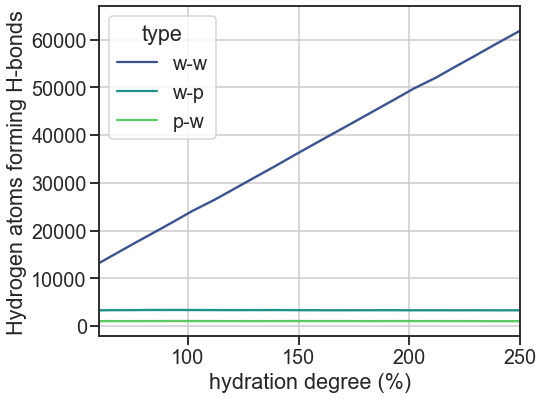

In [100]:
fig, ax = plt.subplots(1,1, figsize=(8,6))
sns.set_theme(style="ticks")
sns.set_context("talk", font_scale=1.2)

data=tdf[(tdf["state"]=="simNPT")]# & ((tdf["nwater"]-12550)%8000==0)]
#
sns.lineplot("hydration_degree", 'mean', data=data, 
                  hue="type",
                  markers=True, 
                  palette="viridis", 
                  ci="sd",
                  ax=ax
                 )
#ax.fill_between(data.hydration_degree, data.lower, data.upper, alpha=1.0)
#
ax.set_xlabel("hydration degree (%)")
ax.set_ylabel(r"Hydrogen atoms forming H-bonds")
ax.set_xlim(xmin=60., xmax=250.)
#ax.set_ylim(ymin=0.0, ymax=15)
#ax.set_yscale("log")
#ax.set_title("state: {} - water count: {}".format(state, nwater))
#
ax.grid()

#plt.legend(title="hydration degree (%)", bbox_to_anchor=(0.98, 0.85), loc='upper right')

plt.tight_layout()
plt.show()

#### Hydrogen bond variation

In [233]:
diff_tdf = pd.DataFrame()
for htype in tdf['type'].unique():
    for rep in tdf['replica'].unique():
        tmp = tdf[(tdf['type']==htype)&(tdf['replica']==rep)][['nwater','hydration_degree']]
        tmp['diff_mean'] = tdf[(tdf['type']==htype)&(tdf['replica']==rep)]['mean'].diff()
        tmp['replica'] = rep
        tmp['type'] = htype
        diff_tdf=pd.concat([diff_tdf,tmp], axis=0)

nwater  hydration_degree  diff_mean  replica type
0     12550              57.0        NaN        1  w-w
18    14550              66.0   2356.000        1  w-w
36    16550              75.0   2338.200        1  w-w
54    18550              84.0   2321.300        1  w-w
72    20550              93.0   2301.300        1  w-w
..      ...               ...        ...      ...  ...
341   48550             221.0     14.500        6  p-w
359   50550             230.0     -1.900        6  p-w
377   52550             239.0    -12.900        6  p-w
395   54550             248.0    -15.200        6  p-w
413   56550             257.0     15.825        6  p-w

[414 rows x 5 columns]

/Users/vassaux/source/miniconda3/envs/biomolecular-mdadev/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/vassaux/source/miniconda3/envs/biomolecular-mdadev/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


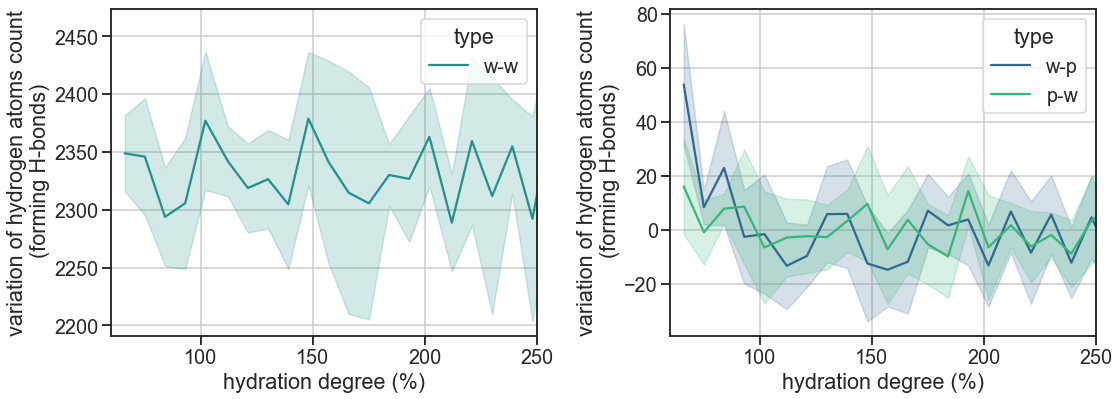

In [234]:
fig, ax = plt.subplots(1,2, figsize=(16,6))
sns.set_theme(style="ticks")
sns.set_context("talk", font_scale=1.2)

data=diff_tdf
#
sns.lineplot("hydration_degree", 'diff_mean', data=data[data['type']=="w-w"], 
                  hue="type",
                  markers=True, 
                  palette="viridis", 
                  ci="sd",
                  ax=ax[0]
                 )
sns.lineplot("hydration_degree", 'diff_mean', data=data[data['type']!="w-w"], 
                  hue="type",
                  markers=True, 
                  palette="viridis", 
                  ci="sd",
                  ax=ax[1]
                 )
#ax.fill_between(data.hydration_degree, data.lower, data.upper, alpha=1.0)
#
ax[0].set_xlabel("hydration degree (%)")
ax[0].set_ylabel("variation of hydrogen atoms count\n (forming H-bonds)")
ax[0].set_xlim(xmin=60., xmax=250.)
ax[1].set_xlabel("hydration degree (%)")
ax[1].set_ylabel("variation of hydrogen atoms count\n (forming H-bonds)")
ax[1].set_xlim(xmin=60., xmax=250.)
#
ax[0].grid()
ax[1].grid()

#plt.legend(title="hydration degree (%)", bbox_to_anchor=(0.98, 0.85), loc='upper right')

plt.tight_layout()
plt.show()

#### Hydrogen bonds per water molecule

In [101]:
tdf["hbond_per_water_per_type"] = tdf['mean']/tdf['nwater']

In [102]:
tdf[tdf["type"]=="w-w"]["hbond_per_water_per_type"] = tdf[tdf["type"]=="w-w"]["hbond_per_water_per_type"]*2

<ipython-input-102-9fe29e7a3ca0>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tdf[tdf["type"]=="w-w"]["hbond_per_water_per_type"] = tdf[tdf["type"]=="w-w"]["hbond_per_water_per_type"]*2


In [110]:
tdf = tdf.groupby(['nwater','type'],as_index=False).mean()

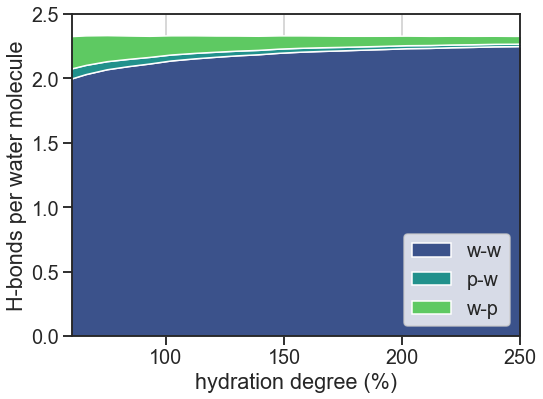

In [112]:
fig, ax = plt.subplots(1,1, figsize=(8,6))
sns.set_theme(style="ticks")
sns.set_context("talk", font_scale=1.2)
palette = sns.color_palette("viridis", 3)

x=tdf[tdf["type"]=="w-w"]["hydration_degree"]
y1=tdf[tdf["type"]=="w-w"]["hbond_per_water_per_type"]*2
y2=tdf[tdf["type"]=="p-w"]["hbond_per_water_per_type"]
y3=tdf[tdf["type"]=="w-p"]["hbond_per_water_per_type"]
 
# Basic stacked area chart.
ax.stackplot(x,y1, y2, y3, labels=['w-w','p-w','w-p'], colors=palette)
ax.legend(loc='lower right')

#ax.fill_between(data.hydration_degree, data.lower, data.upper, alpha=1.0)
#
ax.set_xlabel("hydration degree (%)")
ax.set_ylabel(r"H-bonds per water molecule")
ax.set_xlim(xmin=60., xmax=250.)
ax.set_ylim(ymin=0, ymax=2.5)
#ax.set_yscale("log")
#ax.set_title("state: {} - water count: {}".format(state, nwater))
#
ax.grid()

#plt.legend(title="hydration degree (%)", bbox_to_anchor=(0.98, 0.85), loc='upper right')

plt.tight_layout()
plt.show()

### Hydrogen bonds involving at least one amino acid

In [6]:
def compute_hbonds_oneamino(univ,tstart=80):
    hbonds_waterprotein = HBA(universe=univ, update_selections=False, hydrogens_sel='(resname WAT and name H*)', acceptors_sel='protein')
    hbonds_waterprotein.run(start=tstart)
    hbonds_proteinwater = HBA(universe=univ, update_selections=False, hydrogens_sel='(protein and name H*)', acceptors_sel='resname WAT')
    hbonds_proteinwater.run(start=tstart)
    hbonds_proteinprotein = HBA(universe=univ, update_selections=False, hydrogens_sel='(protein and name H*)', acceptors_sel='protein')
    hbonds_proteinprotein.run(start=tstart)
    arr = [["p-p", hbonds_proteinprotein.count_by_time().mean(), hbonds_proteinprotein.count_by_time().std()],
           ["w-p", hbonds_waterprotein.count_by_time().mean(), hbonds_waterprotein.count_by_time().std()],
           ["p-w", hbonds_proteinwater.count_by_time().mean(), hbonds_proteinwater.count_by_time().std()]]
    tdf = pd.DataFrame(arr, columns=["type", "mean", "std"])
    return tdf

In [9]:
# list water molecule counts
list_water=np.arange(12550, 57000, 3000) # 57000

# ensemble of replicas
list_rep=[1,2,3,4,5,6] # [1,2,3,4,5,6]

# state
list_state=["simNPT"] # "relax_constraint" "simNPT"

tdf = pd.DataFrame()
for nwat in list_water:
    for rep in list_rep:
        for state in list_state:
            univ = load_universe_replica_water_unwrapped(nwat,rep,state)
            df = compute_hbonds_oneamino(univ,50)
            df['replica'] = rep
            df['state'] = state
            df['nwater'] = nwat
            df['hydration_degree'] = np.rint(np.round(nwat/22000,2)*100)
            tdf = tdf.append(df, ignore_index=True)

<DCDReader /Users/vassaux/sng_wrk72/tmp/NPT50NS1ATM298K12550WAT/12550WAT/rep1//simNPT_unwrapped.dcd with 100 frames of 76744 atoms>
<class 'MDAnalysis.core.universe.Universe'>
<DCDReader /Users/vassaux/sng_wrk72/tmp/NPT50NS1ATM298K12550WAT/12550WAT/rep2//simNPT_unwrapped.dcd with 100 frames of 76744 atoms>
<class 'MDAnalysis.core.universe.Universe'>
<DCDReader /Users/vassaux/sng_wrk72/tmp/NPT50NS1ATM298K12550WAT/12550WAT/rep3//simNPT_unwrapped.dcd with 100 frames of 76744 atoms>
<class 'MDAnalysis.core.universe.Universe'>
<DCDReader /Users/vassaux/sng_wrk72/tmp/NPT50NS1ATM298K12550WAT/12550WAT/rep4//simNPT_unwrapped.dcd with 100 frames of 76744 atoms>
<class 'MDAnalysis.core.universe.Universe'>
<DCDReader /Users/vassaux/sng_wrk72/tmp/NPT50NS1ATM298K12550WAT/12550WAT/rep5//simNPT_unwrapped.dcd with 100 frames of 76744 atoms>
<class 'MDAnalysis.core.universe.Universe'>
<DCDReader /Users/vassaux/sng_wrk72/tmp/NPT50NS1ATM298K12550WAT/12550WAT/rep6//simNPT_unwrapped.dcd with 100 frames of 7

/Users/vassaux/source/miniconda3/envs/biomolecular-mdadev/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


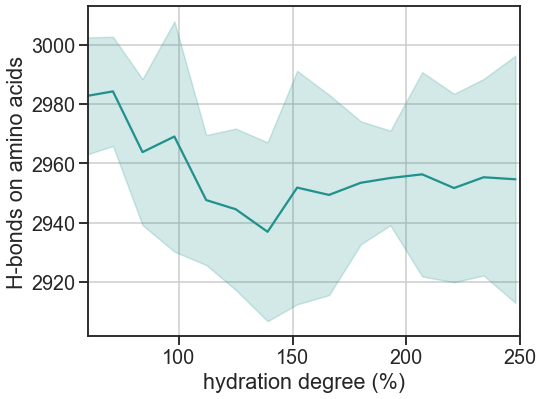

In [149]:
fig, ax = plt.subplots(1,1, figsize=(8,6))
sns.set_theme(style="ticks")
sns.set_context("talk", font_scale=1.2)

palette = sns.color_palette("viridis", 6)

data=tdf[(tdf["state"]=="simNPT") & (tdf["type"]=="p-p")]
#
sns.lineplot("hydration_degree", 'mean', data=data, 
                  hue="type",
                  markers=True, 
                  palette="viridis", 
                  ci="sd",
                  ax=ax
                 )
#ax.fill_between(data.hydration_degree, data.lower, data.upper, alpha=0.2, color=palette[2])
#
ax.set_xlabel("hydration degree (%)")
ax.set_ylabel(r"H-bonds on amino acids")
ax.set_xlim(xmin=60., xmax=250.)
#ax.set_ylim(ymin=0.0, ymax=15)
#ax.set_yscale("log")
#ax.set_title("state: {} - water count: {}".format(state, nwater))
#
ax.grid()

# Remove the legend and add a colorbar
ax.get_legend().remove()

#plt.legend(title="hydration degree (%)", bbox_to_anchor=(0.98, 0.85), loc='upper right')

plt.tight_layout()
plt.show()

/Users/vassaux/source/miniconda3/envs/biomolecular-mdadev/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


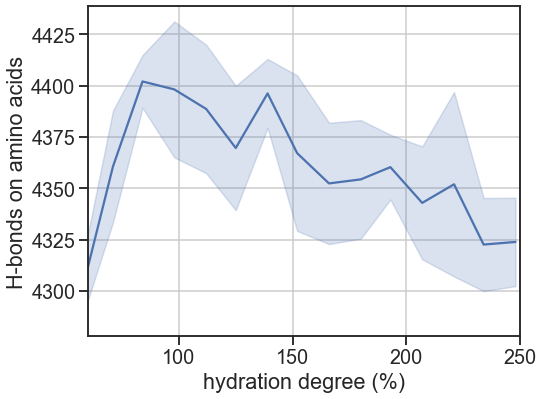

In [28]:
fig, ax = plt.subplots(1,1, figsize=(8,6))
sns.set_theme(style="ticks")
sns.set_context("talk", font_scale=1.2)

palette = sns.color_palette("viridis", 6)

protein_tdf = tdf[(tdf["type"].str.contains('w'))].groupby(['nwater','replica'],as_index=False).sum()
protein_tdf['hydration_degree'] = np.rint(np.round(protein_tdf['nwater']/22000,2)*100)

data=protein_tdf
#
sns.lineplot("hydration_degree", 'mean', data=data, 
                  #hue="replica",
                  markers=True, 
                  palette="viridis", 
                  ci="sd",
                  ax=ax
                 )
#ax.fill_between(data.hydration_degree, data.lower, data.upper, alpha=0.2, color=palette[1])
#
ax.set_xlabel("hydration degree (%)")
ax.set_ylabel(r"H-bonds on amino acids")
ax.set_xlim(xmin=60., xmax=250.)
#ax.set_ylim(ymin=0, ymax=7450)
#ax.set_yscale("log")
#ax.set_title("state: {} - water count: {}".format(state, nwater))
#
ax.grid()

#plt.legend(title="hydration degree (%)", bbox_to_anchor=(0.98, 0.85), loc='upper right')

plt.tight_layout()
plt.show()

#### Overlap region

In [150]:
def compute_hbonds_oneamino_overlap(univ):
    zmax = 305
    hbonds_waterprotein = HBA(universe=univ, update_selections=False, hydrogens_sel='(resname WAT and name H*) and (prop z<{})'.format(zmax), acceptors_sel='protein')
    hbonds_waterprotein.run(start=80)
    hbonds_proteinwater = HBA(universe=univ, update_selections=False, hydrogens_sel='(protein and name H*) and (prop z<{})'.format(zmax), acceptors_sel='resname WAT')
    hbonds_proteinwater.run(start=80)
    hbonds_proteinprotein = HBA(universe=univ, update_selections=False, hydrogens_sel='(protein and name H*) and (prop z<{})'.format(zmax), acceptors_sel='protein')
    hbonds_proteinprotein.run(start=80)
    arr = [["p-p", hbonds_proteinprotein.count_by_time().mean(), hbonds_proteinprotein.count_by_time().std()],
           ["w-p", hbonds_waterprotein.count_by_time().mean(), hbonds_waterprotein.count_by_time().std()],
           ["p-w", hbonds_proteinwater.count_by_time().mean(), hbonds_proteinwater.count_by_time().std()]]
    tdf = pd.DataFrame(arr, columns=["type", "mean", "std"])
    return tdf

In [151]:
# list water molecule counts
list_water=np.arange(12550, 57000, 3000)

# ensemble of replicas
list_rep=[1,2,3,4,5,6] # [1,2,3,4,5,6]

# state
list_state=["simNPT"] # "relax_constraint" "simNPT"

tdf = pd.DataFrame()
for nwat in list_water:
    for rep in list_rep:
        for state in list_state:
            univ = load_universe_replica_water_unwrapped(nwat,rep,state)
            df = compute_hbonds_oneamino_overlap(univ)
            df['replica'] = rep
            df['state'] = state
            df['nwater'] = nwat
            df['hydration_degree'] = np.rint(np.round(nwat/22000,2)*100)
            tdf = tdf.append(df, ignore_index=True)

<DCDReader /Users/vassaux/sng_wrk72/tmp/NPT50NS1ATM298K12550WAT/12550WAT/rep1//simNPT_unwrapped.dcd with 100 frames of 76744 atoms>
<class 'MDAnalysis.core.universe.Universe'>
<DCDReader /Users/vassaux/sng_wrk72/tmp/NPT50NS1ATM298K12550WAT/12550WAT/rep2//simNPT_unwrapped.dcd with 100 frames of 76744 atoms>
<class 'MDAnalysis.core.universe.Universe'>
<DCDReader /Users/vassaux/sng_wrk72/tmp/NPT50NS1ATM298K12550WAT/12550WAT/rep3//simNPT_unwrapped.dcd with 100 frames of 76744 atoms>
<class 'MDAnalysis.core.universe.Universe'>
<DCDReader /Users/vassaux/sng_wrk72/tmp/NPT50NS1ATM298K12550WAT/12550WAT/rep4//simNPT_unwrapped.dcd with 100 frames of 76744 atoms>
<class 'MDAnalysis.core.universe.Universe'>
<DCDReader /Users/vassaux/sng_wrk72/tmp/NPT50NS1ATM298K12550WAT/12550WAT/rep5//simNPT_unwrapped.dcd with 100 frames of 76744 atoms>
<class 'MDAnalysis.core.universe.Universe'>
<DCDReader /Users/vassaux/sng_wrk72/tmp/NPT50NS1ATM298K12550WAT/12550WAT/rep6//simNPT_unwrapped.dcd with 100 frames of 7

<DCDReader /Users/vassaux/sng_wrk72/tmp/NPT50NS1ATM298K12550WAT/33550WAT/rep6//simNPT_unwrapped.dcd with 100 frames of 139744 atoms>
<class 'MDAnalysis.core.universe.Universe'>
<DCDReader /Users/vassaux/sng_wrk72/tmp/NPT50NS1ATM298K12550WAT/36550WAT/rep1//simNPT_unwrapped.dcd with 100 frames of 148744 atoms>
<class 'MDAnalysis.core.universe.Universe'>
<DCDReader /Users/vassaux/sng_wrk72/tmp/NPT50NS1ATM298K12550WAT/36550WAT/rep2//simNPT_unwrapped.dcd with 100 frames of 148744 atoms>
<class 'MDAnalysis.core.universe.Universe'>
<DCDReader /Users/vassaux/sng_wrk72/tmp/NPT50NS1ATM298K12550WAT/36550WAT/rep3//simNPT_unwrapped.dcd with 100 frames of 148744 atoms>
<class 'MDAnalysis.core.universe.Universe'>
<DCDReader /Users/vassaux/sng_wrk72/tmp/NPT50NS1ATM298K12550WAT/36550WAT/rep4//simNPT_unwrapped.dcd with 100 frames of 148744 atoms>
<class 'MDAnalysis.core.universe.Universe'>
<DCDReader /Users/vassaux/sng_wrk72/tmp/NPT50NS1ATM298K12550WAT/36550WAT/rep5//simNPT_unwrapped.dcd with 100 frames

/Users/vassaux/source/miniconda3/envs/biomolecular-mdadev/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


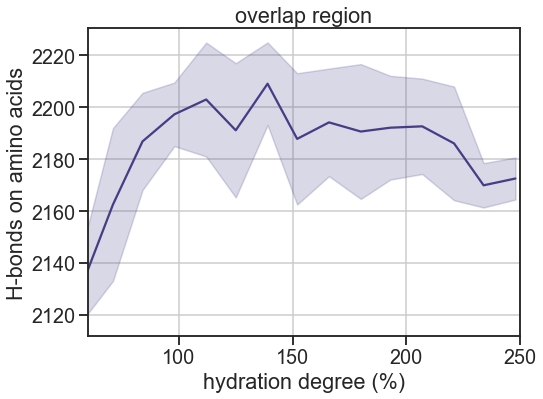

In [24]:
fig, ax = plt.subplots(1,1, figsize=(8,6))
sns.set_theme(style="ticks")
sns.set_context("talk", font_scale=1.2)

palette = sns.color_palette("viridis", 10)

protein_tdf = tdf[(tdf["type"].str.contains('w'))].groupby(['nwater','replica'],as_index=False).sum()
protein_tdf['hydration_degree'] = np.rint(np.round(protein_tdf['nwater']/22000,2)*100)

data=protein_tdf
#
sns.lineplot("hydration_degree", 'mean', data=data, 
                  #hue="replica",
                  markers=True, 
                  color=palette[1], 
                  ci="sd",
                  ax=ax
                 )
#ax.fill_between(data.hydration_degree, data.lower, data.upper, alpha=0.2, color=palette[1])
#
ax.set_xlabel("hydration degree (%)")
ax.set_ylabel(r"H-bonds on amino acids")
ax.set_xlim(xmin=60., xmax=250.)
#ax.set_ylim(ymin=0.0, ymax=15)
#ax.set_yscale("log")
ax.set_title("overlap region")
#
ax.grid()

#plt.legend(title="hydration degree (%)", bbox_to_anchor=(0.98, 0.85), loc='upper right')

plt.tight_layout()
plt.show()

#### Gap region

In [155]:
def compute_hbonds_oneamino_gap(univ):
    zmin = 305
    hbonds_waterprotein = HBA(universe=univ, update_selections=False, hydrogens_sel='(resname WAT and name H*) and (prop z >= {})'.format(zmin), acceptors_sel='protein')
    hbonds_waterprotein.run(start=80)
    hbonds_proteinwater = HBA(universe=univ, update_selections=False, hydrogens_sel='(protein and name H*) and (prop z >= {})'.format(zmin), acceptors_sel='resname WAT')
    hbonds_proteinwater.run(start=80)
    hbonds_proteinprotein = HBA(universe=univ, update_selections=False, hydrogens_sel='(protein and name H*) and (prop z >= {})'.format(zmin), acceptors_sel='protein')
    hbonds_proteinprotein.run(start=80)
    arr = [["p-p", hbonds_proteinprotein.count_by_time().mean(), hbonds_proteinprotein.count_by_time().std()],
           ["w-p", hbonds_waterprotein.count_by_time().mean(), hbonds_waterprotein.count_by_time().std()],
           ["p-w", hbonds_proteinwater.count_by_time().mean(), hbonds_proteinwater.count_by_time().std()]]
    tdf = pd.DataFrame(arr, columns=["type", "mean", "std"])
    return tdf

In [156]:
# list water molecule counts
list_water=np.arange(12550, 57000, 3000)

# ensemble of replicas
list_rep=[1,2,3,4,5,6] # [1,2,3,4,5,6]

# state
list_state=["simNPT"] # "relax_constraint" "simNPT"

tdf = pd.DataFrame()
for nwat in list_water:
    for rep in list_rep:
        for state in list_state:
            univ = load_universe_replica_water_unwrapped(nwat,rep,state)
            df = compute_hbonds_oneamino_gap(univ)
            df['replica'] = rep
            df['state'] = state
            df['nwater'] = nwat
            df['hydration_degree'] = np.rint(np.round(nwat/22000,2)*100)
            tdf = tdf.append(df, ignore_index=True)

<DCDReader /Users/vassaux/sng_wrk72/tmp/NPT50NS1ATM298K12550WAT/12550WAT/rep1//simNPT_unwrapped.dcd with 100 frames of 76744 atoms>
<class 'MDAnalysis.core.universe.Universe'>
<DCDReader /Users/vassaux/sng_wrk72/tmp/NPT50NS1ATM298K12550WAT/12550WAT/rep2//simNPT_unwrapped.dcd with 100 frames of 76744 atoms>
<class 'MDAnalysis.core.universe.Universe'>
<DCDReader /Users/vassaux/sng_wrk72/tmp/NPT50NS1ATM298K12550WAT/12550WAT/rep3//simNPT_unwrapped.dcd with 100 frames of 76744 atoms>
<class 'MDAnalysis.core.universe.Universe'>
<DCDReader /Users/vassaux/sng_wrk72/tmp/NPT50NS1ATM298K12550WAT/12550WAT/rep4//simNPT_unwrapped.dcd with 100 frames of 76744 atoms>
<class 'MDAnalysis.core.universe.Universe'>
<DCDReader /Users/vassaux/sng_wrk72/tmp/NPT50NS1ATM298K12550WAT/12550WAT/rep5//simNPT_unwrapped.dcd with 100 frames of 76744 atoms>
<class 'MDAnalysis.core.universe.Universe'>
<DCDReader /Users/vassaux/sng_wrk72/tmp/NPT50NS1ATM298K12550WAT/12550WAT/rep6//simNPT_unwrapped.dcd with 100 frames of 7

<DCDReader /Users/vassaux/sng_wrk72/tmp/NPT50NS1ATM298K12550WAT/33550WAT/rep6//simNPT_unwrapped.dcd with 100 frames of 139744 atoms>
<class 'MDAnalysis.core.universe.Universe'>
<DCDReader /Users/vassaux/sng_wrk72/tmp/NPT50NS1ATM298K12550WAT/36550WAT/rep1//simNPT_unwrapped.dcd with 100 frames of 148744 atoms>
<class 'MDAnalysis.core.universe.Universe'>
<DCDReader /Users/vassaux/sng_wrk72/tmp/NPT50NS1ATM298K12550WAT/36550WAT/rep2//simNPT_unwrapped.dcd with 100 frames of 148744 atoms>
<class 'MDAnalysis.core.universe.Universe'>
<DCDReader /Users/vassaux/sng_wrk72/tmp/NPT50NS1ATM298K12550WAT/36550WAT/rep3//simNPT_unwrapped.dcd with 100 frames of 148744 atoms>
<class 'MDAnalysis.core.universe.Universe'>
<DCDReader /Users/vassaux/sng_wrk72/tmp/NPT50NS1ATM298K12550WAT/36550WAT/rep4//simNPT_unwrapped.dcd with 100 frames of 148744 atoms>
<class 'MDAnalysis.core.universe.Universe'>
<DCDReader /Users/vassaux/sng_wrk72/tmp/NPT50NS1ATM298K12550WAT/36550WAT/rep5//simNPT_unwrapped.dcd with 100 frames

/Users/vassaux/source/miniconda3/envs/biomolecular-mdadev/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


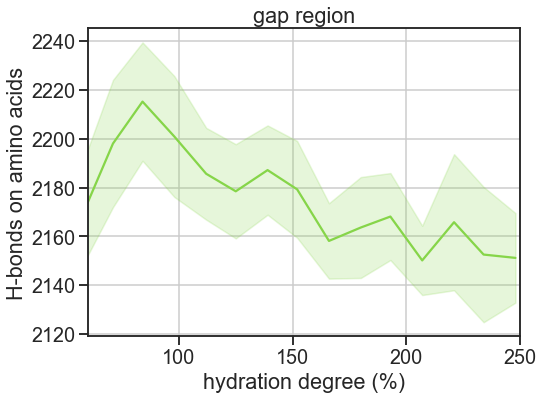

In [26]:
fig, ax = plt.subplots(1,1, figsize=(8,6))
sns.set_theme(style="ticks")
sns.set_context("talk", font_scale=1.2)

palette = sns.color_palette("viridis", 10)

protein_tdf = tdf[(tdf["type"].str.contains('w'))].groupby(['nwater','replica'],as_index=False).sum()
protein_tdf['hydration_degree'] = np.rint(np.round(protein_tdf['nwater']/22000,2)*100)

data=protein_tdf
#
sns.lineplot("hydration_degree", 'mean', data=data, 
                  #hue="replica",
                  markers=True, 
                  color=palette[8], 
                  ci="sd",
                  ax=ax
                 )
#
ax.set_xlabel("hydration degree (%)")
ax.set_ylabel(r"H-bonds on amino acids")
ax.set_xlim(xmin=60., xmax=250.)
#ax.set_ylim(ymin=0.0, ymax=15)
#ax.set_yscale("log")
ax.set_title("gap region")
#
ax.grid()

#plt.legend(title="hydration degree (%)", bbox_to_anchor=(0.98, 0.85), loc='upper right')

plt.tight_layout()
plt.show()

## Energy

### Total energy from simNPT log file

In [69]:
data_dir="/Users/vassaux/sng_wrk72/tmp/NPT50NS1ATM298K12550WAT/12550WAT"
#
list_rep=[2,3,4,5,6]
#
tdf = pd.DataFrame()
#
for rep in list_rep:
    print("replica: {}".format(rep))
    for file in os.listdir("{}/rep{}/".format(data_dir, rep)):
        if file.startswith("simNPT.o"):
            logfile=file

    print("{}/rep{}/{}".format(data_dir, rep, logfile))
    f = open("{}/rep{}/{}".format(data_dir, rep, logfile),"r")
    lines = f.readlines()

    flag_simNPT=False

    for line in lines:
        if "simNPT" in line:
            flag_simNPT=True 
        #
        if flag_simNPT==True:
            if line.startswith('ENERGY:'):
                df = pd.DataFrame([[int(line.split()[1]),float(line.split()[11]),float(line.split()[18])]],
                                  columns=['timestep','energy','volume'])
                df["replica"] = rep
                tdf = pd.concat([tdf, df])

replica: 2
/Users/vassaux/sng_wrk72/tmp/NPT50NS1ATM298K12550WAT/12550WAT//rep2/simNPT.o389997
replica: 3
/Users/vassaux/sng_wrk72/tmp/NPT50NS1ATM298K12550WAT/12550WAT//rep3/simNPT.o390073
replica: 4
/Users/vassaux/sng_wrk72/tmp/NPT50NS1ATM298K12550WAT/12550WAT//rep4/simNPT.o390074
replica: 5
/Users/vassaux/sng_wrk72/tmp/NPT50NS1ATM298K12550WAT/12550WAT//rep5/simNPT.o390075
replica: 6
/Users/vassaux/sng_wrk72/tmp/NPT50NS1ATM298K12550WAT/12550WAT//rep6/simNPT.o390076


In [71]:
tdf["time"] = tdf["timestep"]*2.0e-15

/Users/vassaux/source/miniconda3/envs/biomolecular-mdadev/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


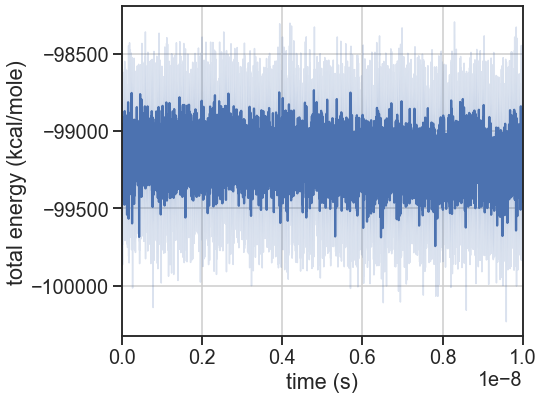

In [74]:
fig, ax = plt.subplots(1,1, figsize=(8,6))
sns.set_theme(style="ticks")
sns.set_context("talk", font_scale=1.2)

data=tdf
#
sns.lineplot("time", 'energy', data=data, 
                  palette="viridis", 
                  ci="sd",
                  ax=ax
                 )
#
ax.set_xlabel("time (s)")
#ax.set_ylabel(r"volume ($\AA^3$)")
ax.set_ylabel(r"total energy (kcal/mole)")
ax.set_xlim(xmin=0., xmax=1.e-8)
#ax.set_ylim(ymin=0.0, ymax=15)
#ax.set_yscale("log")
#ax.set_title("state: {} - water count: {}".format(state, nwater))
#
ax.grid()

#plt.legend(title=r"$N_{max, H_{2}O}$ per bridge")

plt.tight_layout()
plt.show()

### Protein energy from namdenergy log file

In [15]:
dtframe=2.0e-15*50000
data_dir="/Users/vassaux/sng_wrk72/tmp/NPT50NS1ATM298K12550WAT"
#
list_rep=[1,2,3,4,5,6]
list_nwat=np.arange(12550,57550,2000)
#
tdf = pd.DataFrame()
#
for nwat in list_nwat:
    for rep in list_rep:
        logfile = "{}/{}WAT/rep{}/log.namdenergy".format(data_dir, nwat, rep)
        print(logfile)
        f = open(logfile,"r")
        lines = f.readlines()

        for line in lines:
            if line.startswith('ENERGY:'):
                df = pd.DataFrame([[int(line.split()[1]),float(line.split()[2]),float(line.split()[3]),
                                    float(line.split()[4]),float(line.split()[6]),float(line.split()[7])]],
                                  columns=['frame','bond_energy','angle_energy','dihedral_energy',
                                           'electrostatic_energy','vdw_energy'])
                df["replica"] = rep
                df["nwater"] = nwat
                df['hydration_degree'] = np.rint(np.round(nwat/22000,2)*100)
                df["time"] = df["frame"]*dtframe
                tdf = pd.concat([tdf, df])

/Users/vassaux/sng_wrk72/tmp/NPT50NS1ATM298K12550WAT/12550WAT/rep1/log.namdenergy
/Users/vassaux/sng_wrk72/tmp/NPT50NS1ATM298K12550WAT/12550WAT/rep2/log.namdenergy
/Users/vassaux/sng_wrk72/tmp/NPT50NS1ATM298K12550WAT/12550WAT/rep3/log.namdenergy
/Users/vassaux/sng_wrk72/tmp/NPT50NS1ATM298K12550WAT/12550WAT/rep4/log.namdenergy
/Users/vassaux/sng_wrk72/tmp/NPT50NS1ATM298K12550WAT/12550WAT/rep5/log.namdenergy
/Users/vassaux/sng_wrk72/tmp/NPT50NS1ATM298K12550WAT/12550WAT/rep6/log.namdenergy
/Users/vassaux/sng_wrk72/tmp/NPT50NS1ATM298K12550WAT/14550WAT/rep1/log.namdenergy
/Users/vassaux/sng_wrk72/tmp/NPT50NS1ATM298K12550WAT/14550WAT/rep2/log.namdenergy
/Users/vassaux/sng_wrk72/tmp/NPT50NS1ATM298K12550WAT/14550WAT/rep3/log.namdenergy
/Users/vassaux/sng_wrk72/tmp/NPT50NS1ATM298K12550WAT/14550WAT/rep4/log.namdenergy
/Users/vassaux/sng_wrk72/tmp/NPT50NS1ATM298K12550WAT/14550WAT/rep5/log.namdenergy
/Users/vassaux/sng_wrk72/tmp/NPT50NS1ATM298K12550WAT/14550WAT/rep6/log.namdenergy
/Users/vassaux/s

/Users/vassaux/sng_wrk72/tmp/NPT50NS1ATM298K12550WAT/44550WAT/rep5/log.namdenergy
/Users/vassaux/sng_wrk72/tmp/NPT50NS1ATM298K12550WAT/44550WAT/rep6/log.namdenergy
/Users/vassaux/sng_wrk72/tmp/NPT50NS1ATM298K12550WAT/46550WAT/rep1/log.namdenergy
/Users/vassaux/sng_wrk72/tmp/NPT50NS1ATM298K12550WAT/46550WAT/rep2/log.namdenergy
/Users/vassaux/sng_wrk72/tmp/NPT50NS1ATM298K12550WAT/46550WAT/rep3/log.namdenergy
/Users/vassaux/sng_wrk72/tmp/NPT50NS1ATM298K12550WAT/46550WAT/rep4/log.namdenergy
/Users/vassaux/sng_wrk72/tmp/NPT50NS1ATM298K12550WAT/46550WAT/rep5/log.namdenergy
/Users/vassaux/sng_wrk72/tmp/NPT50NS1ATM298K12550WAT/46550WAT/rep6/log.namdenergy
/Users/vassaux/sng_wrk72/tmp/NPT50NS1ATM298K12550WAT/48550WAT/rep1/log.namdenergy
/Users/vassaux/sng_wrk72/tmp/NPT50NS1ATM298K12550WAT/48550WAT/rep2/log.namdenergy
/Users/vassaux/sng_wrk72/tmp/NPT50NS1ATM298K12550WAT/48550WAT/rep3/log.namdenergy
/Users/vassaux/sng_wrk72/tmp/NPT50NS1ATM298K12550WAT/48550WAT/rep4/log.namdenergy
/Users/vassaux/s

/Users/vassaux/source/miniconda3/envs/biomolecular-mdadev/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


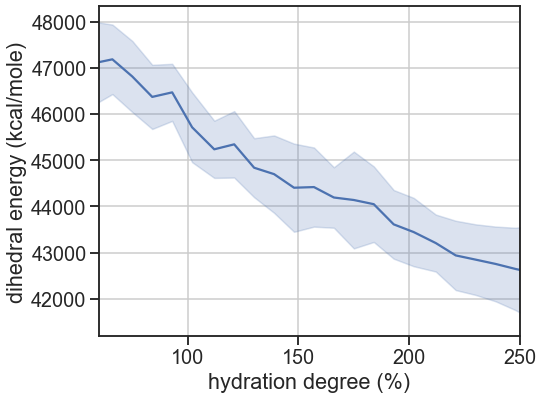

In [28]:
fig, ax = plt.subplots(1,1, figsize=(8,6))
sns.set_theme(style="ticks")
sns.set_context("talk", font_scale=1.2)

data=tdf
#
sns.lineplot("hydration_degree", 'dihedral_energy', data=data,
             palette="viridis", 
             #hue="nwater",
             ci="sd",
             ax=ax
            )
#
ax.set_xlabel("hydration degree (%)")
#ax.set_ylabel(r"volume ($\AA^3$)")
ax.set_ylabel(r"dihedral energy (kcal/mole)")
ax.set_xlim(xmin=60., xmax=250)
#ax.set_ylim(ymin=0.0, ymax=15)
#ax.set_yscale("log")
#ax.set_title("state: {} - water count: {}".format(state, nwater))
#
ax.grid()

#plt.legend(title=r"$N_{max, H_{2}O}$ per bridge")

plt.tight_layout()
plt.show()

## RMSD of the microfibril with hydration

In [29]:
import MDAnalysis.analysis.rms as rms

In [30]:
def load_universe_replica_water_unwrapped(nwater=12550, replica=1,state="simNPT"):
    # trajectory info: T=50e-9s, nts=25000000, dts=2e-15s, nfr=100, dfr=dts*nts/nfr=0.5e-9s
    main_dir = "/Users/vassaux/sng_wrk72/tmp/NPT50NS1ATM298K12550WAT/"
    data_dir = main_dir+"{}WAT/rep{}/".format(nwater,replica)
    sim_name = "3hr2_clean_amber_mutations_modifications_missing_charged_minim_pbc_solvated_equilibrated_hydrated".format(nwater)
    if state=="simNPT":
        u = mda.Universe(data_dir+sim_name+".pdb", data_dir+"/simNPT_unwrapped.dcd")
    elif state=="relax_constraint":
        u = mda.Universe(data_dir+sim_name+".pdb", data_dir+"/relax_constraint_extended/relax_constraint_unwrapped.dcd")
    print(u.trajectory)
    print(type(u))
    return u

### Whole microfibril

In [34]:
#dt=2e-15*50000 #timestep * steps between frame

# mapping
#z = np.linspace(-100, 800, num=30) # np.linspace(-100, 800, num=30)

# list water molecule counts
list_water=np.arange(38550, 57000, 2000)

# ensemble of replicas
list_rep=[1,2,3,4,5,6] # [1,2,3,4,5,6]

# state
list_state=["simNPT"] # "relax_constraint" "simNPT"

#tdf = pd.DataFrame()
for nwat in list_water:
    for rep in list_rep:
        #
        univ = load_universe_replica_water_unwrapped(nwat, rep,"simNPT")

        bb = univ.select_atoms('backbone')
        A = bb.positions.copy()  # coordinates of first frame
        univ.trajectory[-1]         # forward to last frame
        B = bb.positions.copy()  # coordinates of last frame

        rmsd = rms.rmsd(A, B, center=True)
        
        df = pd.DataFrame([[nwat, rep, np.rint(np.round(nwat/22000,2)*100), rmsd]], 
                          columns=['nwater',"replica","hydration_degree","RMSD_backbone"] )
        tdf = tdf.append(df, ignore_index=True)

/Users/vassaux/source/miniconda3/envs/biomolecular-mdadev/lib/python3.8/site-packages/MDAnalysis/topology/PDBParser.py:317: UserWarning: Element information is missing, elements attribute will not be populated. If needed these can be guessed using MDAnalysis.topology.guessers.
  warnings.warn("Element information is missing, elements attribute "


<DCDReader /Users/vassaux/sng_wrk72/tmp/NPT50NS1ATM298K12550WAT/38550WAT/rep1//simNPT_unwrapped.dcd with 100 frames of 154744 atoms>
<class 'MDAnalysis.core.universe.Universe'>
<DCDReader /Users/vassaux/sng_wrk72/tmp/NPT50NS1ATM298K12550WAT/38550WAT/rep2//simNPT_unwrapped.dcd with 100 frames of 154744 atoms>
<class 'MDAnalysis.core.universe.Universe'>
<DCDReader /Users/vassaux/sng_wrk72/tmp/NPT50NS1ATM298K12550WAT/38550WAT/rep3//simNPT_unwrapped.dcd with 100 frames of 154744 atoms>
<class 'MDAnalysis.core.universe.Universe'>
<DCDReader /Users/vassaux/sng_wrk72/tmp/NPT50NS1ATM298K12550WAT/38550WAT/rep4//simNPT_unwrapped.dcd with 100 frames of 154744 atoms>
<class 'MDAnalysis.core.universe.Universe'>
<DCDReader /Users/vassaux/sng_wrk72/tmp/NPT50NS1ATM298K12550WAT/38550WAT/rep5//simNPT_unwrapped.dcd with 100 frames of 154744 atoms>
<class 'MDAnalysis.core.universe.Universe'>
<DCDReader /Users/vassaux/sng_wrk72/tmp/NPT50NS1ATM298K12550WAT/38550WAT/rep6//simNPT_unwrapped.dcd with 100 frames

<DCDReader /Users/vassaux/sng_wrk72/tmp/NPT50NS1ATM298K12550WAT/52550WAT/rep6//simNPT_unwrapped.dcd with 100 frames of 196744 atoms>
<class 'MDAnalysis.core.universe.Universe'>
<DCDReader /Users/vassaux/sng_wrk72/tmp/NPT50NS1ATM298K12550WAT/54550WAT/rep1//simNPT_unwrapped.dcd with 100 frames of 202744 atoms>
<class 'MDAnalysis.core.universe.Universe'>
<DCDReader /Users/vassaux/sng_wrk72/tmp/NPT50NS1ATM298K12550WAT/54550WAT/rep2//simNPT_unwrapped.dcd with 100 frames of 202744 atoms>
<class 'MDAnalysis.core.universe.Universe'>
<DCDReader /Users/vassaux/sng_wrk72/tmp/NPT50NS1ATM298K12550WAT/54550WAT/rep3//simNPT_unwrapped.dcd with 100 frames of 202744 atoms>
<class 'MDAnalysis.core.universe.Universe'>
<DCDReader /Users/vassaux/sng_wrk72/tmp/NPT50NS1ATM298K12550WAT/54550WAT/rep4//simNPT_unwrapped.dcd with 100 frames of 202744 atoms>
<class 'MDAnalysis.core.universe.Universe'>
<DCDReader /Users/vassaux/sng_wrk72/tmp/NPT50NS1ATM298K12550WAT/54550WAT/rep5//simNPT_unwrapped.dcd with 100 frames

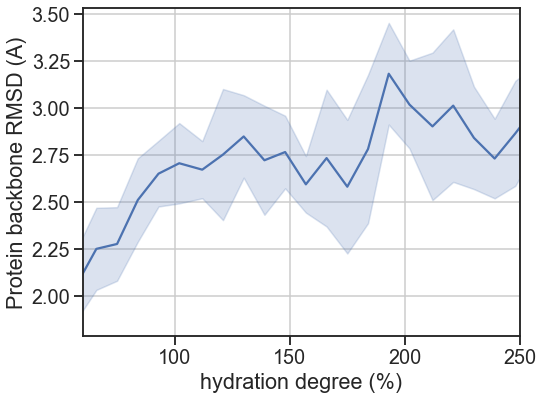

In [36]:
fig, ax = plt.subplots(1,1, figsize=(8,6))
sns.set_theme(style="ticks")
sns.set_context("talk", font_scale=1.2)

data= tdf

sns.lineplot(x="hydration_degree",
             #x="z_cg",
             y="RMSD_backbone", data=data, 
                  #hue="z_cg",
                  #hue="hydration_degree",
                  #markers=True, 
                  palette="viridis", 
                  ci="sd",
                  legend="full",
                  ax=ax
                 )
#
ax.set_xlabel("hydration degree (%)")
ax.set_xlim(xmin=60, xmax=250)
#ax.set_xlabel("z-axis position (A)")
#ax.set_xlim(xmin=0, xmax=600)
ax.set_ylabel("Protein backbone RMSD (A)")
#ax.set_ylim(ymin=0.0, ymax=6)
#ax.set_yscale("log")
#ax.set_title("state: {} - water count: {}".format(state, nwater))

# Remove the legend
#ax.get_legend().remove()
#
ax.grid()

#plt.legend(title="hydration degree (%)", bbox_to_anchor=(0.98, 0.85), loc='upper right')

plt.tight_layout()
plt.show()

### Overlap region

In [37]:
#dt=2e-15*50000 #timestep * steps between frame

# mapping
#z = np.linspace(-100, 800, num=30) # np.linspace(-100, 800, num=30)

# list water molecule counts
list_water=np.arange(12550, 57000, 2000)

# ensemble of replicas
list_rep=[1,2,3,4,5,6] # [1,2,3,4,5,6]

# state
list_state=["simNPT"] # "relax_constraint" "simNPT"

tdf = pd.DataFrame()
for nwat in list_water:
    for rep in list_rep:
        #
        univ = load_universe_replica_water_unwrapped(nwat, rep,"simNPT")

        bb = univ.select_atoms('backbone and (prop z<305)')
        A = bb.positions.copy()  # coordinates of first frame
        univ.trajectory[-1]         # forward to last frame
        B = bb.positions.copy()  # coordinates of last frame

        rmsd = rms.rmsd(A, B, center=True)
        
        df = pd.DataFrame([[nwat, rep, np.rint(np.round(nwat/22000,2)*100), rmsd]], 
                          columns=['nwater',"replica","hydration_degree","RMSD_backbone"] )
        tdf = tdf.append(df, ignore_index=True)

/Users/vassaux/source/miniconda3/envs/biomolecular-mdadev/lib/python3.8/site-packages/MDAnalysis/topology/PDBParser.py:317: UserWarning: Element information is missing, elements attribute will not be populated. If needed these can be guessed using MDAnalysis.topology.guessers.
  warnings.warn("Element information is missing, elements attribute "


<DCDReader /Users/vassaux/sng_wrk72/tmp/NPT50NS1ATM298K12550WAT/12550WAT/rep1//simNPT_unwrapped.dcd with 100 frames of 76744 atoms>
<class 'MDAnalysis.core.universe.Universe'>
<DCDReader /Users/vassaux/sng_wrk72/tmp/NPT50NS1ATM298K12550WAT/12550WAT/rep2//simNPT_unwrapped.dcd with 100 frames of 76744 atoms>
<class 'MDAnalysis.core.universe.Universe'>
<DCDReader /Users/vassaux/sng_wrk72/tmp/NPT50NS1ATM298K12550WAT/12550WAT/rep3//simNPT_unwrapped.dcd with 100 frames of 76744 atoms>
<class 'MDAnalysis.core.universe.Universe'>
<DCDReader /Users/vassaux/sng_wrk72/tmp/NPT50NS1ATM298K12550WAT/12550WAT/rep4//simNPT_unwrapped.dcd with 100 frames of 76744 atoms>
<class 'MDAnalysis.core.universe.Universe'>
<DCDReader /Users/vassaux/sng_wrk72/tmp/NPT50NS1ATM298K12550WAT/12550WAT/rep5//simNPT_unwrapped.dcd with 100 frames of 76744 atoms>
<class 'MDAnalysis.core.universe.Universe'>
<DCDReader /Users/vassaux/sng_wrk72/tmp/NPT50NS1ATM298K12550WAT/12550WAT/rep6//simNPT_unwrapped.dcd with 100 frames of 7

<DCDReader /Users/vassaux/sng_wrk72/tmp/NPT50NS1ATM298K12550WAT/26550WAT/rep6//simNPT_unwrapped.dcd with 100 frames of 118744 atoms>
<class 'MDAnalysis.core.universe.Universe'>
<DCDReader /Users/vassaux/sng_wrk72/tmp/NPT50NS1ATM298K12550WAT/28550WAT/rep1//simNPT_unwrapped.dcd with 100 frames of 124744 atoms>
<class 'MDAnalysis.core.universe.Universe'>
<DCDReader /Users/vassaux/sng_wrk72/tmp/NPT50NS1ATM298K12550WAT/28550WAT/rep2//simNPT_unwrapped.dcd with 100 frames of 124744 atoms>
<class 'MDAnalysis.core.universe.Universe'>
<DCDReader /Users/vassaux/sng_wrk72/tmp/NPT50NS1ATM298K12550WAT/28550WAT/rep3//simNPT_unwrapped.dcd with 100 frames of 124744 atoms>
<class 'MDAnalysis.core.universe.Universe'>
<DCDReader /Users/vassaux/sng_wrk72/tmp/NPT50NS1ATM298K12550WAT/28550WAT/rep4//simNPT_unwrapped.dcd with 100 frames of 124744 atoms>
<class 'MDAnalysis.core.universe.Universe'>
<DCDReader /Users/vassaux/sng_wrk72/tmp/NPT50NS1ATM298K12550WAT/28550WAT/rep5//simNPT_unwrapped.dcd with 100 frames

<DCDReader /Users/vassaux/sng_wrk72/tmp/NPT50NS1ATM298K12550WAT/42550WAT/rep5//simNPT_unwrapped.dcd with 100 frames of 166744 atoms>
<class 'MDAnalysis.core.universe.Universe'>
<DCDReader /Users/vassaux/sng_wrk72/tmp/NPT50NS1ATM298K12550WAT/42550WAT/rep6//simNPT_unwrapped.dcd with 100 frames of 166744 atoms>
<class 'MDAnalysis.core.universe.Universe'>
<DCDReader /Users/vassaux/sng_wrk72/tmp/NPT50NS1ATM298K12550WAT/44550WAT/rep1//simNPT_unwrapped.dcd with 100 frames of 172744 atoms>
<class 'MDAnalysis.core.universe.Universe'>
<DCDReader /Users/vassaux/sng_wrk72/tmp/NPT50NS1ATM298K12550WAT/44550WAT/rep2//simNPT_unwrapped.dcd with 100 frames of 172744 atoms>
<class 'MDAnalysis.core.universe.Universe'>
<DCDReader /Users/vassaux/sng_wrk72/tmp/NPT50NS1ATM298K12550WAT/44550WAT/rep3//simNPT_unwrapped.dcd with 100 frames of 172744 atoms>
<class 'MDAnalysis.core.universe.Universe'>
<DCDReader /Users/vassaux/sng_wrk72/tmp/NPT50NS1ATM298K12550WAT/44550WAT/rep4//simNPT_unwrapped.dcd with 100 frames

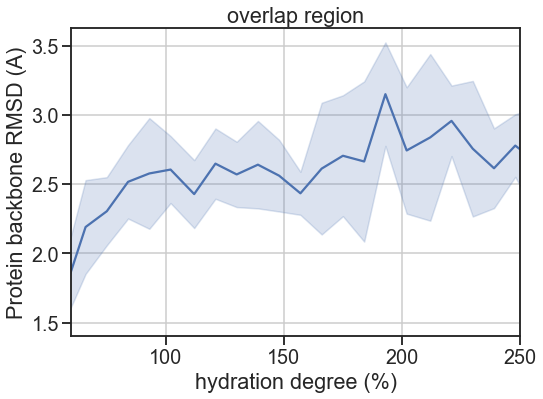

In [61]:
fig, ax = plt.subplots(1,1, figsize=(8,6))
sns.set_theme(style="ticks")
sns.set_context("talk", font_scale=1.2)

data= tdf

sns.lineplot(x="hydration_degree",
             #x="z_cg",
             y="RMSD_backbone", data=data, 
                  #hue="z_cg",
                  #hue="hydration_degree",
                  #markers=True, 
                  palette="viridis", 
                  ci="sd",
                  legend="full",
                  ax=ax
                 )
#
ax.set_xlabel("hydration degree (%)")
ax.set_xlim(xmin=60, xmax=250)
#ax.set_xlabel("z-axis position (A)")
#ax.set_xlim(xmin=0, xmax=600)
ax.set_ylabel("Protein backbone RMSD (A)")
#ax.set_ylim(ymin=0.0, ymax=6)
#ax.set_yscale("log")
ax.set_title("overlap region")

# Remove the legend
#ax.get_legend().remove()
#
ax.grid()

#plt.legend(title="hydration degree (%)", bbox_to_anchor=(0.98, 0.85), loc='upper right')

plt.tight_layout()
plt.show()

### Gap region

In [39]:
#dt=2e-15*50000 #timestep * steps between frame

# mapping
#z = np.linspace(-100, 800, num=30) # np.linspace(-100, 800, num=30)

# list water molecule counts
list_water=np.arange(12550, 57000, 2000)

# ensemble of replicas
list_rep=[1,2,3,4,5,6] # [1,2,3,4,5,6]

# state
list_state=["simNPT"] # "relax_constraint" "simNPT"

tdf = pd.DataFrame()
for nwat in list_water:
    for rep in list_rep:
        #
        univ = load_universe_replica_water_unwrapped(nwat, rep,"simNPT")

        bb = univ.select_atoms('backbone and (prop z>305)')
        A = bb.positions.copy()  # coordinates of first frame
        univ.trajectory[-1]         # forward to last frame
        B = bb.positions.copy()  # coordinates of last frame

        rmsd = rms.rmsd(A, B, center=True)
        
        df = pd.DataFrame([[nwat, rep, np.rint(np.round(nwat/22000,2)*100), rmsd]], 
                          columns=['nwater',"replica","hydration_degree","RMSD_backbone"] )
        tdf = tdf.append(df, ignore_index=True)

<DCDReader /Users/vassaux/sng_wrk72/tmp/NPT50NS1ATM298K12550WAT/12550WAT/rep1//simNPT_unwrapped.dcd with 100 frames of 76744 atoms>
<class 'MDAnalysis.core.universe.Universe'>
<DCDReader /Users/vassaux/sng_wrk72/tmp/NPT50NS1ATM298K12550WAT/12550WAT/rep2//simNPT_unwrapped.dcd with 100 frames of 76744 atoms>
<class 'MDAnalysis.core.universe.Universe'>
<DCDReader /Users/vassaux/sng_wrk72/tmp/NPT50NS1ATM298K12550WAT/12550WAT/rep3//simNPT_unwrapped.dcd with 100 frames of 76744 atoms>
<class 'MDAnalysis.core.universe.Universe'>
<DCDReader /Users/vassaux/sng_wrk72/tmp/NPT50NS1ATM298K12550WAT/12550WAT/rep4//simNPT_unwrapped.dcd with 100 frames of 76744 atoms>
<class 'MDAnalysis.core.universe.Universe'>
<DCDReader /Users/vassaux/sng_wrk72/tmp/NPT50NS1ATM298K12550WAT/12550WAT/rep5//simNPT_unwrapped.dcd with 100 frames of 76744 atoms>
<class 'MDAnalysis.core.universe.Universe'>
<DCDReader /Users/vassaux/sng_wrk72/tmp/NPT50NS1ATM298K12550WAT/12550WAT/rep6//simNPT_unwrapped.dcd with 100 frames of 7

<DCDReader /Users/vassaux/sng_wrk72/tmp/NPT50NS1ATM298K12550WAT/26550WAT/rep6//simNPT_unwrapped.dcd with 100 frames of 118744 atoms>
<class 'MDAnalysis.core.universe.Universe'>
<DCDReader /Users/vassaux/sng_wrk72/tmp/NPT50NS1ATM298K12550WAT/28550WAT/rep1//simNPT_unwrapped.dcd with 100 frames of 124744 atoms>
<class 'MDAnalysis.core.universe.Universe'>
<DCDReader /Users/vassaux/sng_wrk72/tmp/NPT50NS1ATM298K12550WAT/28550WAT/rep2//simNPT_unwrapped.dcd with 100 frames of 124744 atoms>
<class 'MDAnalysis.core.universe.Universe'>
<DCDReader /Users/vassaux/sng_wrk72/tmp/NPT50NS1ATM298K12550WAT/28550WAT/rep3//simNPT_unwrapped.dcd with 100 frames of 124744 atoms>
<class 'MDAnalysis.core.universe.Universe'>
<DCDReader /Users/vassaux/sng_wrk72/tmp/NPT50NS1ATM298K12550WAT/28550WAT/rep4//simNPT_unwrapped.dcd with 100 frames of 124744 atoms>
<class 'MDAnalysis.core.universe.Universe'>
<DCDReader /Users/vassaux/sng_wrk72/tmp/NPT50NS1ATM298K12550WAT/28550WAT/rep5//simNPT_unwrapped.dcd with 100 frames

<DCDReader /Users/vassaux/sng_wrk72/tmp/NPT50NS1ATM298K12550WAT/42550WAT/rep5//simNPT_unwrapped.dcd with 100 frames of 166744 atoms>
<class 'MDAnalysis.core.universe.Universe'>
<DCDReader /Users/vassaux/sng_wrk72/tmp/NPT50NS1ATM298K12550WAT/42550WAT/rep6//simNPT_unwrapped.dcd with 100 frames of 166744 atoms>
<class 'MDAnalysis.core.universe.Universe'>
<DCDReader /Users/vassaux/sng_wrk72/tmp/NPT50NS1ATM298K12550WAT/44550WAT/rep1//simNPT_unwrapped.dcd with 100 frames of 172744 atoms>
<class 'MDAnalysis.core.universe.Universe'>
<DCDReader /Users/vassaux/sng_wrk72/tmp/NPT50NS1ATM298K12550WAT/44550WAT/rep2//simNPT_unwrapped.dcd with 100 frames of 172744 atoms>
<class 'MDAnalysis.core.universe.Universe'>
<DCDReader /Users/vassaux/sng_wrk72/tmp/NPT50NS1ATM298K12550WAT/44550WAT/rep3//simNPT_unwrapped.dcd with 100 frames of 172744 atoms>
<class 'MDAnalysis.core.universe.Universe'>
<DCDReader /Users/vassaux/sng_wrk72/tmp/NPT50NS1ATM298K12550WAT/44550WAT/rep4//simNPT_unwrapped.dcd with 100 frames

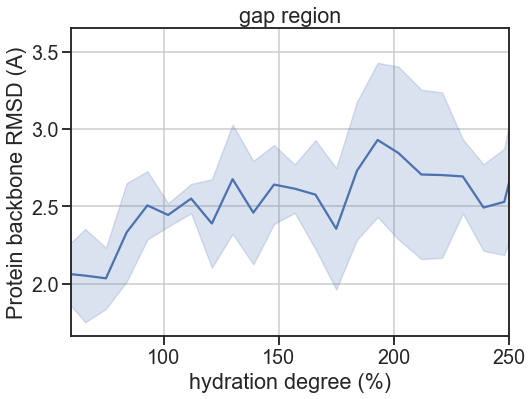

In [54]:
fig, ax = plt.subplots(1,1, figsize=(8,6))
sns.set_theme(style="ticks")
sns.set_context("talk", font_scale=1.2)

data= tdf

sns.lineplot(x="hydration_degree",
             #x="z_cg",
             y="RMSD_backbone", data=data, 
                  #hue="z_cg",
                  #hue="hydration_degree",
                  #markers=True, 
                  palette="viridis", 
                  ci="sd",
                  legend="full",
                  ax=ax
                 )
#
ax.set_xlabel("hydration degree (%)")
ax.set_xlim(xmin=60, xmax=250)
#ax.set_xlabel("z-axis position (A)")
#ax.set_xlim(xmin=0, xmax=600)
ax.set_ylabel("Protein backbone RMSD (A)")
#ax.set_ylim(ymin=0.0, ymax=6)
#ax.set_yscale("log")
ax.set_title("gap region")

# Remove the legend
#ax.get_legend().remove()
#
ax.grid()

#plt.legend(title="hydration degree (%)", bbox_to_anchor=(0.98, 0.85), loc='upper right')

plt.tight_layout()
plt.show()